In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from keras import callbacks 
from tensorflow.keras.layers import Input, concatenate,Dense
from keras.models import Sequential,Model
from keras.layers import Concatenate, Dense,Input, concatenate,Dropout,Flatten
from sklearn.model_selection import KFold
from sklearn.utils import shuffle


In [2]:
#retrieve data
num = 2000 # number of profiles
nvza = 2 # number of channels
nsza=1



In [3]:
# spatial slicing dimensions
s = 82 # output slice size
ts = 82 # input slice size 32

In [4]:
#get the averaged reflectance from the dataset 
r=np.load('monte_carlo_r.npy')
print(r.shape)
r=r.reshape((2000, 82, 2))
print(r.shape)

(2000, 82, 1, 2)
(2000, 82, 2)


In [5]:
#get the averaged reflectance from the dataset 
c=np.load('monte_carlo_cot.npy')
c.shape

(2000, 82)

In [6]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 1600 profiles
test_size: 400 profiles


In [7]:
# DNN over domain -------------------------------------------

def evaluate_model(train_image, test_image, train_label, test_label):

    input_img = Input(shape=(ts,2))
    hn=Flatten()(input_img)
    hn = Dense(82, activation='relu')(hn)#1st fully connected layer
    hn1 =Dense(1024, activation='relu')(hn)
    hn1=Dense(1024, activation='relu')(hn1)
    hn1=Dropout(0.5)(hn1)
    hn1=Dense(8, activation='relu')(hn1) #4th fully connected layer
    out_both = concatenate([hn, hn1], axis=1, name = 'concatenate')
    hn2=Dense(82, activation='linear')(out_both)
    model_m = Model(input_img, outputs=[hn2])
    model_m.summary()


    ltype = 'mean_squared_error'
    ltype2=tf.keras.metrics.RootMeanSquaredError()
    bsize = 128
    eps = 4000

    model_m.compile(optimizer='adam',loss=ltype,metrics=[ltype,ltype2])

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min", patience = 50,restore_best_weights = True,
                                               verbose=1) 

    history = model_m.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.25,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------
    print('test result')

    results = model_m.evaluate(test_image, test_label)
    predictions=model_m.predict(test_image)
    mse = results[0]
    rmse=results[2]
    
    return model_m,rmse,mse,history,predictions

In [8]:
#5-fold cross validation
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,400*4,82,2)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),82))
X_test=np.zeros((n_folds,ratio,82,2))
y_test=np.zeros((n_folds,ratio,82))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 400  401  402 ... 1997 1998 1999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [9]:
c# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= evaluate_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)
    

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 82, 2)]      0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 164)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 82)           13530       flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         84992       dense[0][0]                      
______________________________________________________________________________________________

10/10 [==============================] - 0s 10ms/step - loss: 48.4186 - mean_squared_error: 48.4186 - root_mean_squared_error: 6.9583 - val_loss: 46.5075 - val_mean_squared_error: 46.5075 - val_root_mean_squared_error: 6.8196
Epoch 26/4000
10/10 [==============================] - 0s 10ms/step - loss: 46.8873 - mean_squared_error: 46.8873 - root_mean_squared_error: 6.8474 - val_loss: 45.2581 - val_mean_squared_error: 45.2581 - val_root_mean_squared_error: 6.7274
Epoch 27/4000
10/10 [==============================] - 0s 10ms/step - loss: 46.0325 - mean_squared_error: 46.0325 - root_mean_squared_error: 6.7847 - val_loss: 44.5461 - val_mean_squared_error: 44.5461 - val_root_mean_squared_error: 6.6743
Epoch 28/4000
10/10 [==============================] - 0s 9ms/step - loss: 45.1022 - mean_squared_error: 45.1022 - root_mean_squared_error: 6.7158 - val_loss: 43.9985 - val_mean_squared_error: 43.9985 - val_root_mean_squared_error: 6.6331
Epoch 29/4000
10/10 [==============================] - 

10/10 [==============================] - 0s 9ms/step - loss: 35.2127 - mean_squared_error: 35.2127 - root_mean_squared_error: 5.9340 - val_loss: 34.7074 - val_mean_squared_error: 34.7074 - val_root_mean_squared_error: 5.8913
Epoch 60/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.9458 - mean_squared_error: 34.9458 - root_mean_squared_error: 5.9115 - val_loss: 34.3295 - val_mean_squared_error: 34.3295 - val_root_mean_squared_error: 5.8591
Epoch 61/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.4424 - mean_squared_error: 34.4424 - root_mean_squared_error: 5.8687 - val_loss: 34.1336 - val_mean_squared_error: 34.1336 - val_root_mean_squared_error: 5.8424
Epoch 62/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.3582 - mean_squared_error: 34.3582 - root_mean_squared_error: 5.8616 - val_loss: 33.9098 - val_mean_squared_error: 33.9098 - val_root_mean_squared_error: 5.8232
Epoch 63/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 28.5284 - mean_squared_error: 28.5284 - root_mean_squared_error: 5.3412 - val_loss: 27.6907 - val_mean_squared_error: 27.6907 - val_root_mean_squared_error: 5.2622
Epoch 94/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.0069 - mean_squared_error: 28.0069 - root_mean_squared_error: 5.2921 - val_loss: 27.3929 - val_mean_squared_error: 27.3929 - val_root_mean_squared_error: 5.2338
Epoch 95/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.8614 - mean_squared_error: 27.8614 - root_mean_squared_error: 5.2784 - val_loss: 27.2517 - val_mean_squared_error: 27.2517 - val_root_mean_squared_error: 5.2203
Epoch 96/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.6371 - mean_squared_error: 27.6371 - root_mean_squared_error: 5.2571 - val_loss: 26.9959 - val_mean_squared_error: 26.9959 - val_root_mean_squared_error: 5.1958
Epoch 97/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 25.2317 - mean_squared_error: 25.2317 - root_mean_squared_error: 5.0231 - val_loss: 24.7901 - val_mean_squared_error: 24.7901 - val_root_mean_squared_error: 4.9790
Epoch 128/4000
10/10 [==============================] - 0s 10ms/step - loss: 25.1201 - mean_squared_error: 25.1201 - root_mean_squared_error: 5.0120 - val_loss: 24.8145 - val_mean_squared_error: 24.8145 - val_root_mean_squared_error: 4.9814
Epoch 129/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.2352 - mean_squared_error: 25.2352 - root_mean_squared_error: 5.0235 - val_loss: 24.9668 - val_mean_squared_error: 24.9668 - val_root_mean_squared_error: 4.9967
Epoch 130/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.1911 - mean_squared_error: 25.1911 - root_mean_squared_error: 5.0191 - val_loss: 24.8659 - val_mean_squared_error: 24.8659 - val_root_mean_squared_error: 4.9866
Epoch 131/4000
10/10 [==============================] 

10/10 [==============================] - 0s 9ms/step - loss: 24.4959 - mean_squared_error: 24.4959 - root_mean_squared_error: 4.9493 - val_loss: 24.0889 - val_mean_squared_error: 24.0889 - val_root_mean_squared_error: 4.9080
Epoch 162/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.4430 - mean_squared_error: 24.4430 - root_mean_squared_error: 4.9440 - val_loss: 24.0941 - val_mean_squared_error: 24.0941 - val_root_mean_squared_error: 4.9086
Epoch 163/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.4582 - mean_squared_error: 24.4582 - root_mean_squared_error: 4.9455 - val_loss: 24.2318 - val_mean_squared_error: 24.2318 - val_root_mean_squared_error: 4.9226
Epoch 164/4000
10/10 [==============================] - 0s 10ms/step - loss: 24.3049 - mean_squared_error: 24.3049 - root_mean_squared_error: 4.9300 - val_loss: 24.1150 - val_mean_squared_error: 24.1150 - val_root_mean_squared_error: 4.9107
Epoch 165/4000
10/10 [==============================] 

10/10 [==============================] - 0s 9ms/step - loss: 23.5564 - mean_squared_error: 23.5564 - root_mean_squared_error: 4.8535 - val_loss: 23.4029 - val_mean_squared_error: 23.4029 - val_root_mean_squared_error: 4.8377
Epoch 196/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.3464 - mean_squared_error: 23.3464 - root_mean_squared_error: 4.8318 - val_loss: 23.3484 - val_mean_squared_error: 23.3484 - val_root_mean_squared_error: 4.8320
Epoch 197/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.2620 - mean_squared_error: 23.2620 - root_mean_squared_error: 4.8231 - val_loss: 23.2498 - val_mean_squared_error: 23.2498 - val_root_mean_squared_error: 4.8218
Epoch 198/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.3319 - mean_squared_error: 23.3319 - root_mean_squared_error: 4.8303 - val_loss: 23.3114 - val_mean_squared_error: 23.3114 - val_root_mean_squared_error: 4.8282
Epoch 199/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 22.1553 - mean_squared_error: 22.1553 - root_mean_squared_error: 4.7069 - val_loss: 22.1485 - val_mean_squared_error: 22.1485 - val_root_mean_squared_error: 4.7062
Epoch 230/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.0357 - mean_squared_error: 22.0357 - root_mean_squared_error: 4.6942 - val_loss: 22.2885 - val_mean_squared_error: 22.2885 - val_root_mean_squared_error: 4.7211
Epoch 231/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.0801 - mean_squared_error: 22.0801 - root_mean_squared_error: 4.6989 - val_loss: 22.1442 - val_mean_squared_error: 22.1442 - val_root_mean_squared_error: 4.7058
Epoch 232/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.0018 - mean_squared_error: 22.0018 - root_mean_squared_error: 4.6906 - val_loss: 22.2533 - val_mean_squared_error: 22.2533 - val_root_mean_squared_error: 4.7173
Epoch 233/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 20.5348 - mean_squared_error: 20.5348 - root_mean_squared_error: 4.5315 - val_loss: 20.8773 - val_mean_squared_error: 20.8773 - val_root_mean_squared_error: 4.5692
Epoch 264/4000
10/10 [==============================] - 0s 10ms/step - loss: 20.6455 - mean_squared_error: 20.6455 - root_mean_squared_error: 4.5437 - val_loss: 20.8579 - val_mean_squared_error: 20.8579 - val_root_mean_squared_error: 4.5670
Epoch 265/4000
10/10 [==============================] - 0s 10ms/step - loss: 20.5014 - mean_squared_error: 20.5014 - root_mean_squared_error: 4.5278 - val_loss: 20.8248 - val_mean_squared_error: 20.8248 - val_root_mean_squared_error: 4.5634
Epoch 266/4000
10/10 [==============================] - 0s 10ms/step - loss: 20.3381 - mean_squared_error: 20.3381 - root_mean_squared_error: 4.5098 - val_loss: 20.9317 - val_mean_squared_error: 20.9317 - val_root_mean_squared_error: 4.5751
Epoch 267/4000
10/10 [==============================

10/10 [==============================] - 0s 10ms/step - loss: 19.1247 - mean_squared_error: 19.1247 - root_mean_squared_error: 4.3732 - val_loss: 19.6234 - val_mean_squared_error: 19.6234 - val_root_mean_squared_error: 4.4298
Epoch 298/4000
10/10 [==============================] - 0s 10ms/step - loss: 19.0955 - mean_squared_error: 19.0955 - root_mean_squared_error: 4.3698 - val_loss: 19.9459 - val_mean_squared_error: 19.9459 - val_root_mean_squared_error: 4.4661
Epoch 299/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.2340 - mean_squared_error: 19.2340 - root_mean_squared_error: 4.3856 - val_loss: 19.5440 - val_mean_squared_error: 19.5440 - val_root_mean_squared_error: 4.4209
Epoch 300/4000
10/10 [==============================] - 0s 10ms/step - loss: 19.0732 - mean_squared_error: 19.0732 - root_mean_squared_error: 4.3673 - val_loss: 19.5106 - val_mean_squared_error: 19.5106 - val_root_mean_squared_error: 4.4171
Epoch 301/4000
10/10 [==============================

10/10 [==============================] - 0s 9ms/step - loss: 18.1747 - mean_squared_error: 18.1747 - root_mean_squared_error: 4.2632 - val_loss: 18.6507 - val_mean_squared_error: 18.6507 - val_root_mean_squared_error: 4.3186
Epoch 332/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.1333 - mean_squared_error: 18.1333 - root_mean_squared_error: 4.2583 - val_loss: 18.7970 - val_mean_squared_error: 18.7970 - val_root_mean_squared_error: 4.3356
Epoch 333/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.3560 - mean_squared_error: 18.3560 - root_mean_squared_error: 4.2844 - val_loss: 18.6641 - val_mean_squared_error: 18.6641 - val_root_mean_squared_error: 4.3202
Epoch 334/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.1533 - mean_squared_error: 18.1533 - root_mean_squared_error: 4.2607 - val_loss: 18.6435 - val_mean_squared_error: 18.6435 - val_root_mean_squared_error: 4.3178
Epoch 335/4000
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 17.4655 - mean_squared_error: 17.4655 - root_mean_squared_error: 4.1792 - val_loss: 18.0275 - val_mean_squared_error: 18.0275 - val_root_mean_squared_error: 4.2459
Epoch 366/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.4241 - mean_squared_error: 17.4241 - root_mean_squared_error: 4.1742 - val_loss: 17.9759 - val_mean_squared_error: 17.9759 - val_root_mean_squared_error: 4.2398
Epoch 367/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.4771 - mean_squared_error: 17.4771 - root_mean_squared_error: 4.1806 - val_loss: 18.1408 - val_mean_squared_error: 18.1408 - val_root_mean_squared_error: 4.2592
Epoch 368/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.5827 - mean_squared_error: 17.5827 - root_mean_squared_error: 4.1931 - val_loss: 17.9117 - val_mean_squared_error: 17.9117 - val_root_mean_squared_error: 4.2322
Epoch 369/4000
10/10 [==============================] 

10/10 [==============================] - 0s 10ms/step - loss: 16.9421 - mean_squared_error: 16.9421 - root_mean_squared_error: 4.1161 - val_loss: 17.5120 - val_mean_squared_error: 17.5120 - val_root_mean_squared_error: 4.1847
Epoch 400/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.9078 - mean_squared_error: 16.9078 - root_mean_squared_error: 4.1119 - val_loss: 17.5038 - val_mean_squared_error: 17.5038 - val_root_mean_squared_error: 4.1838
Epoch 401/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.8956 - mean_squared_error: 16.8956 - root_mean_squared_error: 4.1104 - val_loss: 17.4910 - val_mean_squared_error: 17.4910 - val_root_mean_squared_error: 4.1822
Epoch 402/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.9825 - mean_squared_error: 16.9825 - root_mean_squared_error: 4.1210 - val_loss: 17.4503 - val_mean_squared_error: 17.4503 - val_root_mean_squared_error: 4.1773
Epoch 403/4000
10/10 [==============================] 

10/10 [==============================] - 0s 10ms/step - loss: 16.5533 - mean_squared_error: 16.5533 - root_mean_squared_error: 4.0686 - val_loss: 17.1791 - val_mean_squared_error: 17.1791 - val_root_mean_squared_error: 4.1448
Epoch 434/4000
10/10 [==============================] - 0s 10ms/step - loss: 16.5202 - mean_squared_error: 16.5202 - root_mean_squared_error: 4.0645 - val_loss: 17.2402 - val_mean_squared_error: 17.2402 - val_root_mean_squared_error: 4.1521
Epoch 435/4000
10/10 [==============================] - 0s 10ms/step - loss: 16.5485 - mean_squared_error: 16.5485 - root_mean_squared_error: 4.0680 - val_loss: 17.1915 - val_mean_squared_error: 17.1915 - val_root_mean_squared_error: 4.1463
Epoch 436/4000
10/10 [==============================] - 0s 10ms/step - loss: 16.4970 - mean_squared_error: 16.4970 - root_mean_squared_error: 4.0616 - val_loss: 17.1299 - val_mean_squared_error: 17.1299 - val_root_mean_squared_error: 4.1388
Epoch 437/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 16.1871 - mean_squared_error: 16.1871 - root_mean_squared_error: 4.0233 - val_loss: 16.8902 - val_mean_squared_error: 16.8902 - val_root_mean_squared_error: 4.1098
Epoch 468/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2044 - mean_squared_error: 16.2044 - root_mean_squared_error: 4.0255 - val_loss: 17.1251 - val_mean_squared_error: 17.1251 - val_root_mean_squared_error: 4.1382
Epoch 469/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2348 - mean_squared_error: 16.2348 - root_mean_squared_error: 4.0292 - val_loss: 16.8937 - val_mean_squared_error: 16.8937 - val_root_mean_squared_error: 4.1102
Epoch 470/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2176 - mean_squared_error: 16.2176 - root_mean_squared_error: 4.0271 - val_loss: 16.9065 - val_mean_squared_error: 16.9065 - val_root_mean_squared_error: 4.1118
Epoch 471/4000
10/10 [==============================] -

Epoch 501/4000
10/10 [==============================] - 0s 11ms/step - loss: 15.8029 - mean_squared_error: 15.8029 - root_mean_squared_error: 3.9753 - val_loss: 16.6399 - val_mean_squared_error: 16.6399 - val_root_mean_squared_error: 4.0792
Epoch 502/4000
10/10 [==============================] - 0s 10ms/step - loss: 15.7690 - mean_squared_error: 15.7690 - root_mean_squared_error: 3.9710 - val_loss: 16.5531 - val_mean_squared_error: 16.5531 - val_root_mean_squared_error: 4.0686
Epoch 503/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.7420 - mean_squared_error: 15.7420 - root_mean_squared_error: 3.9676 - val_loss: 16.5983 - val_mean_squared_error: 16.5983 - val_root_mean_squared_error: 4.0741
Epoch 504/4000
10/10 [==============================] - 0s 10ms/step - loss: 15.7362 - mean_squared_error: 15.7362 - root_mean_squared_error: 3.9669 - val_loss: 16.6226 - val_mean_squared_error: 16.6226 - val_root_mean_squared_error: 4.0771
Epoch 505/4000
10/10 [===============

10/10 [==============================] - 0s 10ms/step - loss: 15.4315 - mean_squared_error: 15.4315 - root_mean_squared_error: 3.9283 - val_loss: 16.4178 - val_mean_squared_error: 16.4178 - val_root_mean_squared_error: 4.0519
Epoch 536/4000
10/10 [==============================] - 0s 10ms/step - loss: 15.3423 - mean_squared_error: 15.3423 - root_mean_squared_error: 3.9169 - val_loss: 16.2807 - val_mean_squared_error: 16.2807 - val_root_mean_squared_error: 4.0349
Epoch 537/4000
10/10 [==============================] - 0s 10ms/step - loss: 15.5141 - mean_squared_error: 15.5141 - root_mean_squared_error: 3.9388 - val_loss: 16.2981 - val_mean_squared_error: 16.2981 - val_root_mean_squared_error: 4.0371
Epoch 538/4000
10/10 [==============================] - 0s 10ms/step - loss: 15.3940 - mean_squared_error: 15.3940 - root_mean_squared_error: 3.9235 - val_loss: 16.2447 - val_mean_squared_error: 16.2447 - val_root_mean_squared_error: 4.0305
Epoch 539/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 15.0098 - mean_squared_error: 15.0098 - root_mean_squared_error: 3.8742 - val_loss: 16.0762 - val_mean_squared_error: 16.0762 - val_root_mean_squared_error: 4.0095
Epoch 570/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.0504 - mean_squared_error: 15.0504 - root_mean_squared_error: 3.8795 - val_loss: 16.1131 - val_mean_squared_error: 16.1131 - val_root_mean_squared_error: 4.0141
Epoch 571/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.0169 - mean_squared_error: 15.0169 - root_mean_squared_error: 3.8751 - val_loss: 15.8995 - val_mean_squared_error: 15.8995 - val_root_mean_squared_error: 3.9874
Epoch 572/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.8526 - mean_squared_error: 14.8526 - root_mean_squared_error: 3.8539 - val_loss: 15.9689 - val_mean_squared_error: 15.9689 - val_root_mean_squared_error: 3.9961
Epoch 573/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.6393 - mean_squared_error: 14.6393 - root_mean_squared_error: 3.8261 - val_loss: 15.6472 - val_mean_squared_error: 15.6472 - val_root_mean_squared_error: 3.9557
Epoch 603/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.4883 - mean_squared_error: 14.4883 - root_mean_squared_error: 3.8063 - val_loss: 15.6518 - val_mean_squared_error: 15.6518 - val_root_mean_squared_error: 3.9562
Epoch 604/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.4950 - mean_squared_error: 14.4950 - root_mean_squared_error: 3.8072 - val_loss: 15.6315 - val_mean_squared_error: 15.6315 - val_root_mean_squared_error: 3.9537
Epoch 605/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.5666 - mean_squared_error: 14.5666 - root_mean_squared_error: 3.8166 - val_loss: 15.6013 - val_mean_squared_error: 15.6013 - val_root_mean_squared_error: 3.9498
Epoch 606/4000
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 14.2539 - mean_squared_error: 14.2539 - root_mean_squared_error: 3.7754 - val_loss: 15.3471 - val_mean_squared_error: 15.3471 - val_root_mean_squared_error: 3.9175
Epoch 637/4000
10/10 [==============================] - 0s 10ms/step - loss: 14.2801 - mean_squared_error: 14.2801 - root_mean_squared_error: 3.7789 - val_loss: 15.5230 - val_mean_squared_error: 15.5230 - val_root_mean_squared_error: 3.9399
Epoch 638/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.3633 - mean_squared_error: 14.3633 - root_mean_squared_error: 3.7899 - val_loss: 15.3757 - val_mean_squared_error: 15.3757 - val_root_mean_squared_error: 3.9212
Epoch 639/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.2423 - mean_squared_error: 14.2423 - root_mean_squared_error: 3.7739 - val_loss: 15.3608 - val_mean_squared_error: 15.3608 - val_root_mean_squared_error: 3.9193
Epoch 640/4000
10/10 [==============================]

10/10 [==============================] - 0s 10ms/step - loss: 13.8719 - mean_squared_error: 13.8719 - root_mean_squared_error: 3.7245 - val_loss: 14.9958 - val_mean_squared_error: 14.9958 - val_root_mean_squared_error: 3.8724
Epoch 671/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.8946 - mean_squared_error: 13.8946 - root_mean_squared_error: 3.7275 - val_loss: 15.0210 - val_mean_squared_error: 15.0210 - val_root_mean_squared_error: 3.8757
Epoch 672/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.7846 - mean_squared_error: 13.7846 - root_mean_squared_error: 3.7127 - val_loss: 15.1194 - val_mean_squared_error: 15.1194 - val_root_mean_squared_error: 3.8884
Epoch 673/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.9333 - mean_squared_error: 13.9333 - root_mean_squared_error: 3.7327 - val_loss: 15.1768 - val_mean_squared_error: 15.1768 - val_root_mean_squared_error: 3.8957
Epoch 674/4000
10/10 [==============================] 

Epoch 704/4000
10/10 [==============================] - 0s 11ms/step - loss: 13.5003 - mean_squared_error: 13.5003 - root_mean_squared_error: 3.6743 - val_loss: 14.7049 - val_mean_squared_error: 14.7049 - val_root_mean_squared_error: 3.8347
Epoch 705/4000
10/10 [==============================] - 0s 13ms/step - loss: 13.3048 - mean_squared_error: 13.3048 - root_mean_squared_error: 3.6475 - val_loss: 14.6744 - val_mean_squared_error: 14.6744 - val_root_mean_squared_error: 3.8307
Epoch 706/4000
10/10 [==============================] - 0s 14ms/step - loss: 13.4486 - mean_squared_error: 13.4486 - root_mean_squared_error: 3.6672 - val_loss: 14.7843 - val_mean_squared_error: 14.7843 - val_root_mean_squared_error: 3.8450
Epoch 707/4000
10/10 [==============================] - 0s 10ms/step - loss: 13.4524 - mean_squared_error: 13.4524 - root_mean_squared_error: 3.6678 - val_loss: 14.7444 - val_mean_squared_error: 14.7444 - val_root_mean_squared_error: 3.8398
Epoch 708/4000
10/10 [==============

Epoch 738/4000
10/10 [==============================] - 0s 11ms/step - loss: 13.2598 - mean_squared_error: 13.2598 - root_mean_squared_error: 3.6414 - val_loss: 14.5120 - val_mean_squared_error: 14.5120 - val_root_mean_squared_error: 3.8095
Epoch 739/4000
10/10 [==============================] - 0s 11ms/step - loss: 13.1134 - mean_squared_error: 13.1134 - root_mean_squared_error: 3.6212 - val_loss: 14.3734 - val_mean_squared_error: 14.3734 - val_root_mean_squared_error: 3.7912
Epoch 740/4000
10/10 [==============================] - 0s 11ms/step - loss: 13.0826 - mean_squared_error: 13.0826 - root_mean_squared_error: 3.6170 - val_loss: 14.5160 - val_mean_squared_error: 14.5160 - val_root_mean_squared_error: 3.8100
Epoch 741/4000
10/10 [==============================] - 0s 11ms/step - loss: 13.2276 - mean_squared_error: 13.2276 - root_mean_squared_error: 3.6370 - val_loss: 14.4240 - val_mean_squared_error: 14.4240 - val_root_mean_squared_error: 3.7979
Epoch 742/4000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 12.7991 - mean_squared_error: 12.7991 - root_mean_squared_error: 3.5776 - val_loss: 14.2710 - val_mean_squared_error: 14.2710 - val_root_mean_squared_error: 3.7777
Epoch 773/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.7958 - mean_squared_error: 12.7958 - root_mean_squared_error: 3.5771 - val_loss: 14.2038 - val_mean_squared_error: 14.2038 - val_root_mean_squared_error: 3.7688
Epoch 774/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8753 - mean_squared_error: 12.8753 - root_mean_squared_error: 3.5882 - val_loss: 14.1324 - val_mean_squared_error: 14.1324 - val_root_mean_squared_error: 3.7593
Epoch 775/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.7113 - mean_squared_error: 12.7113 - root_mean_squared_error: 3.5653 - val_loss: 14.1157 - val_mean_squared_error: 14.1157 - val_root_mean_squared_error: 3.7571
Epoch 776/4000
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 12.5363 - mean_squared_error: 12.5363 - root_mean_squared_error: 3.5407 - val_loss: 13.8934 - val_mean_squared_error: 13.8934 - val_root_mean_squared_error: 3.7274
Epoch 807/4000
10/10 [==============================] - 0s 10ms/step - loss: 12.4939 - mean_squared_error: 12.4939 - root_mean_squared_error: 3.5347 - val_loss: 13.9978 - val_mean_squared_error: 13.9978 - val_root_mean_squared_error: 3.7414
Epoch 808/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.4884 - mean_squared_error: 12.4884 - root_mean_squared_error: 3.5339 - val_loss: 13.8764 - val_mean_squared_error: 13.8764 - val_root_mean_squared_error: 3.7251
Epoch 809/4000
10/10 [==============================] - 0s 10ms/step - loss: 12.4735 - mean_squared_error: 12.4735 - root_mean_squared_error: 3.5318 - val_loss: 13.8838 - val_mean_squared_error: 13.8838 - val_root_mean_squared_error: 3.7261
Epoch 810/4000
10/10 [==============================

10/10 [==============================] - 0s 12ms/step - loss: 12.1371 - mean_squared_error: 12.1371 - root_mean_squared_error: 3.4838 - val_loss: 13.6492 - val_mean_squared_error: 13.6492 - val_root_mean_squared_error: 3.6945
Epoch 841/4000
10/10 [==============================] - 0s 11ms/step - loss: 12.2373 - mean_squared_error: 12.2373 - root_mean_squared_error: 3.4982 - val_loss: 13.6085 - val_mean_squared_error: 13.6085 - val_root_mean_squared_error: 3.6890
Epoch 842/4000
10/10 [==============================] - 0s 11ms/step - loss: 12.2274 - mean_squared_error: 12.2274 - root_mean_squared_error: 3.4968 - val_loss: 13.6899 - val_mean_squared_error: 13.6899 - val_root_mean_squared_error: 3.7000
Epoch 843/4000
10/10 [==============================] - 0s 11ms/step - loss: 12.2001 - mean_squared_error: 12.2001 - root_mean_squared_error: 3.4929 - val_loss: 13.6845 - val_mean_squared_error: 13.6845 - val_root_mean_squared_error: 3.6993
Epoch 844/4000
10/10 [=============================

Epoch 874/4000
10/10 [==============================] - 0s 11ms/step - loss: 11.9399 - mean_squared_error: 11.9399 - root_mean_squared_error: 3.4554 - val_loss: 13.4450 - val_mean_squared_error: 13.4450 - val_root_mean_squared_error: 3.6667
Epoch 875/4000
10/10 [==============================] - 0s 11ms/step - loss: 11.9505 - mean_squared_error: 11.9505 - root_mean_squared_error: 3.4569 - val_loss: 13.4359 - val_mean_squared_error: 13.4359 - val_root_mean_squared_error: 3.6655
Epoch 876/4000
10/10 [==============================] - 0s 11ms/step - loss: 12.0110 - mean_squared_error: 12.0110 - root_mean_squared_error: 3.4657 - val_loss: 13.4694 - val_mean_squared_error: 13.4694 - val_root_mean_squared_error: 3.6701
Epoch 877/4000
10/10 [==============================] - 0s 10ms/step - loss: 11.9008 - mean_squared_error: 11.9008 - root_mean_squared_error: 3.4497 - val_loss: 13.4159 - val_mean_squared_error: 13.4159 - val_root_mean_squared_error: 3.6628
Epoch 878/4000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: 11.7874 - mean_squared_error: 11.7874 - root_mean_squared_error: 3.4333 - val_loss: 13.1764 - val_mean_squared_error: 13.1764 - val_root_mean_squared_error: 3.6299
Epoch 909/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7458 - mean_squared_error: 11.7458 - root_mean_squared_error: 3.4272 - val_loss: 13.2015 - val_mean_squared_error: 13.2015 - val_root_mean_squared_error: 3.6334
Epoch 910/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7088 - mean_squared_error: 11.7088 - root_mean_squared_error: 3.4218 - val_loss: 13.2241 - val_mean_squared_error: 13.2241 - val_root_mean_squared_error: 3.6365
Epoch 911/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7004 - mean_squared_error: 11.7004 - root_mean_squared_error: 3.4206 - val_loss: 13.2413 - val_mean_squared_error: 13.2413 - val_root_mean_squared_error: 3.6389
Epoch 912/4000
10/10 [==============================] -

Epoch 942/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4255 - mean_squared_error: 11.4255 - root_mean_squared_error: 3.3802 - val_loss: 13.0961 - val_mean_squared_error: 13.0961 - val_root_mean_squared_error: 3.6189
Epoch 943/4000
10/10 [==============================] - ETA: 0s - loss: 11.5617 - mean_squared_error: 11.5617 - root_mean_squared_error: 3.40 - 0s 10ms/step - loss: 11.5310 - mean_squared_error: 11.5310 - root_mean_squared_error: 3.3957 - val_loss: 12.9955 - val_mean_squared_error: 12.9955 - val_root_mean_squared_error: 3.6049
Epoch 944/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5307 - mean_squared_error: 11.5307 - root_mean_squared_error: 3.3957 - val_loss: 13.0359 - val_mean_squared_error: 13.0359 - val_root_mean_squared_error: 3.6105
Epoch 945/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4670 - mean_squared_error: 11.4670 - root_mean_squared_error: 3.3863 - val_loss: 13.1055 - val_mean_squared_erro

Epoch 976/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2540 - mean_squared_error: 11.2540 - root_mean_squared_error: 3.3547 - val_loss: 12.8684 - val_mean_squared_error: 12.8684 - val_root_mean_squared_error: 3.5873
Epoch 977/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2175 - mean_squared_error: 11.2175 - root_mean_squared_error: 3.3492 - val_loss: 12.8369 - val_mean_squared_error: 12.8369 - val_root_mean_squared_error: 3.5829
Epoch 978/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2758 - mean_squared_error: 11.2758 - root_mean_squared_error: 3.3579 - val_loss: 12.8641 - val_mean_squared_error: 12.8641 - val_root_mean_squared_error: 3.5867
Epoch 979/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3502 - mean_squared_error: 11.3502 - root_mean_squared_error: 3.3690 - val_loss: 12.8878 - val_mean_squared_error: 12.8878 - val_root_mean_squared_error: 3.5900
Epoch 980/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 11.1505 - mean_squared_error: 11.1505 - root_mean_squared_error: 3.3392 - val_loss: 12.7290 - val_mean_squared_error: 12.7290 - val_root_mean_squared_error: 3.5678
Epoch 1011/4000
10/10 [==============================] - 0s 10ms/step - loss: 11.0961 - mean_squared_error: 11.0961 - root_mean_squared_error: 3.3311 - val_loss: 12.7003 - val_mean_squared_error: 12.7003 - val_root_mean_squared_error: 3.5638
Epoch 1012/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1402 - mean_squared_error: 11.1402 - root_mean_squared_error: 3.3377 - val_loss: 12.7173 - val_mean_squared_error: 12.7173 - val_root_mean_squared_error: 3.5661
Epoch 1013/4000
10/10 [==============================] - 0s 10ms/step - loss: 11.1299 - mean_squared_error: 11.1299 - root_mean_squared_error: 3.3361 - val_loss: 12.6698 - val_mean_squared_error: 12.6698 - val_root_mean_squared_error: 3.5595
Epoch 1014/4000
10/10 [===========================

Epoch 1044/4000
10/10 [==============================] - 0s 11ms/step - loss: 11.0112 - mean_squared_error: 11.0112 - root_mean_squared_error: 3.3183 - val_loss: 12.6099 - val_mean_squared_error: 12.6099 - val_root_mean_squared_error: 3.5510
Epoch 1045/4000
10/10 [==============================] - 0s 10ms/step - loss: 11.0102 - mean_squared_error: 11.0102 - root_mean_squared_error: 3.3182 - val_loss: 12.6359 - val_mean_squared_error: 12.6359 - val_root_mean_squared_error: 3.5547
Epoch 1046/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.9783 - mean_squared_error: 10.9783 - root_mean_squared_error: 3.3134 - val_loss: 12.5719 - val_mean_squared_error: 12.5719 - val_root_mean_squared_error: 3.5457
Epoch 1047/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9542 - mean_squared_error: 10.9542 - root_mean_squared_error: 3.3097 - val_loss: 12.6155 - val_mean_squared_error: 12.6155 - val_root_mean_squared_error: 3.5518
Epoch 1048/4000
10/10 [==========

Epoch 1078/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8861 - mean_squared_error: 10.8861 - root_mean_squared_error: 3.2994 - val_loss: 12.4993 - val_mean_squared_error: 12.4993 - val_root_mean_squared_error: 3.5354
Epoch 1079/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8801 - mean_squared_error: 10.8801 - root_mean_squared_error: 3.2985 - val_loss: 12.4931 - val_mean_squared_error: 12.4931 - val_root_mean_squared_error: 3.5346
Epoch 1080/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7883 - mean_squared_error: 10.7883 - root_mean_squared_error: 3.2845 - val_loss: 12.4602 - val_mean_squared_error: 12.4602 - val_root_mean_squared_error: 3.5299
Epoch 1081/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.7988 - mean_squared_error: 10.7988 - root_mean_squared_error: 3.2861 - val_loss: 12.4765 - val_mean_squared_error: 12.4765 - val_root_mean_squared_error: 3.5322
Epoch 1082/4000
10/10 [============

Epoch 1112/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6712 - mean_squared_error: 10.6712 - root_mean_squared_error: 3.2666 - val_loss: 12.3988 - val_mean_squared_error: 12.3988 - val_root_mean_squared_error: 3.5212
Epoch 1113/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7258 - mean_squared_error: 10.7258 - root_mean_squared_error: 3.2750 - val_loss: 12.3596 - val_mean_squared_error: 12.3596 - val_root_mean_squared_error: 3.5156
Epoch 1114/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.7930 - mean_squared_error: 10.7930 - root_mean_squared_error: 3.2852 - val_loss: 12.3926 - val_mean_squared_error: 12.3926 - val_root_mean_squared_error: 3.5203
Epoch 1115/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7048 - mean_squared_error: 10.7048 - root_mean_squared_error: 3.2718 - val_loss: 12.3427 - val_mean_squared_error: 12.3427 - val_root_mean_squared_error: 3.5132
Epoch 1116/4000
10/10 [============

Epoch 1146/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6195 - mean_squared_error: 10.6195 - root_mean_squared_error: 3.2587 - val_loss: 12.3079 - val_mean_squared_error: 12.3079 - val_root_mean_squared_error: 3.5083
Epoch 1147/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5531 - mean_squared_error: 10.5531 - root_mean_squared_error: 3.2486 - val_loss: 12.3638 - val_mean_squared_error: 12.3638 - val_root_mean_squared_error: 3.5162
Epoch 1148/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.6010 - mean_squared_error: 10.6010 - root_mean_squared_error: 3.2559 - val_loss: 12.2950 - val_mean_squared_error: 12.2950 - val_root_mean_squared_error: 3.5064
Epoch 1149/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.6375 - mean_squared_error: 10.6375 - root_mean_squared_error: 3.2615 - val_loss: 12.3485 - val_mean_squared_error: 12.3485 - val_root_mean_squared_error: 3.5140
Epoch 1150/4000
10/10 [===========

Epoch 1180/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5227 - mean_squared_error: 10.5227 - root_mean_squared_error: 3.2439 - val_loss: 12.2457 - val_mean_squared_error: 12.2457 - val_root_mean_squared_error: 3.4994
Epoch 1181/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4423 - mean_squared_error: 10.4423 - root_mean_squared_error: 3.2315 - val_loss: 12.2155 - val_mean_squared_error: 12.2155 - val_root_mean_squared_error: 3.4951
Epoch 1182/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4131 - mean_squared_error: 10.4131 - root_mean_squared_error: 3.2269 - val_loss: 12.2495 - val_mean_squared_error: 12.2495 - val_root_mean_squared_error: 3.4999
Epoch 1183/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4585 - mean_squared_error: 10.4585 - root_mean_squared_error: 3.2340 - val_loss: 12.2190 - val_mean_squared_error: 12.2190 - val_root_mean_squared_error: 3.4956
Epoch 1184/4000
10/10 [=============

Epoch 1214/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4256 - mean_squared_error: 10.4256 - root_mean_squared_error: 3.2289 - val_loss: 12.1747 - val_mean_squared_error: 12.1747 - val_root_mean_squared_error: 3.4892
Epoch 1215/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3738 - mean_squared_error: 10.3738 - root_mean_squared_error: 3.2208 - val_loss: 12.1325 - val_mean_squared_error: 12.1325 - val_root_mean_squared_error: 3.4832
Epoch 1216/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3746 - mean_squared_error: 10.3746 - root_mean_squared_error: 3.2210 - val_loss: 12.1703 - val_mean_squared_error: 12.1703 - val_root_mean_squared_error: 3.4886
Epoch 1217/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.3697 - mean_squared_error: 10.3697 - root_mean_squared_error: 3.2202 - val_loss: 12.1551 - val_mean_squared_error: 12.1551 - val_root_mean_squared_error: 3.4864
Epoch 1218/4000
10/10 [============

Epoch 1248/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3015 - mean_squared_error: 10.3015 - root_mean_squared_error: 3.2096 - val_loss: 12.1130 - val_mean_squared_error: 12.1130 - val_root_mean_squared_error: 3.4804
Epoch 1249/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2285 - mean_squared_error: 10.2285 - root_mean_squared_error: 3.1982 - val_loss: 12.1217 - val_mean_squared_error: 12.1217 - val_root_mean_squared_error: 3.4816
Epoch 1250/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2566 - mean_squared_error: 10.2566 - root_mean_squared_error: 3.2026 - val_loss: 12.1171 - val_mean_squared_error: 12.1171 - val_root_mean_squared_error: 3.4810
Epoch 1251/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.2779 - mean_squared_error: 10.2779 - root_mean_squared_error: 3.2059 - val_loss: 12.0730 - val_mean_squared_error: 12.0730 - val_root_mean_squared_error: 3.4746
Epoch 1252/4000
10/10 [============

Epoch 1282/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1906 - mean_squared_error: 10.1906 - root_mean_squared_error: 3.1923 - val_loss: 12.1212 - val_mean_squared_error: 12.1212 - val_root_mean_squared_error: 3.4815
Epoch 1283/4000
10/10 [==============================] - 0s 11ms/step - loss: 10.1484 - mean_squared_error: 10.1484 - root_mean_squared_error: 3.1857 - val_loss: 12.0017 - val_mean_squared_error: 12.0017 - val_root_mean_squared_error: 3.4643
Epoch 1284/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.1970 - mean_squared_error: 10.1970 - root_mean_squared_error: 3.1933 - val_loss: 12.0200 - val_mean_squared_error: 12.0200 - val_root_mean_squared_error: 3.4670
Epoch 1285/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1927 - mean_squared_error: 10.1927 - root_mean_squared_error: 3.1926 - val_loss: 12.0400 - val_mean_squared_error: 12.0400 - val_root_mean_squared_error: 3.4699
Epoch 1286/4000
10/10 [===========

Epoch 1316/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.0595 - mean_squared_error: 10.0595 - root_mean_squared_error: 3.1717 - val_loss: 11.9508 - val_mean_squared_error: 11.9508 - val_root_mean_squared_error: 3.4570
Epoch 1317/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.0957 - mean_squared_error: 10.0957 - root_mean_squared_error: 3.1774 - val_loss: 12.0238 - val_mean_squared_error: 12.0238 - val_root_mean_squared_error: 3.4675
Epoch 1318/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0988 - mean_squared_error: 10.0988 - root_mean_squared_error: 3.1778 - val_loss: 11.9961 - val_mean_squared_error: 11.9961 - val_root_mean_squared_error: 3.4635
Epoch 1319/4000
10/10 [==============================] - 0s 11ms/step - loss: 10.1403 - mean_squared_error: 10.1403 - root_mean_squared_error: 3.1844 - val_loss: 11.9894 - val_mean_squared_error: 11.9894 - val_root_mean_squared_error: 3.4626
Epoch 1320/4000
10/10 [==========

10/10 [==============================] - 0s 10ms/step - loss: 10.0492 - mean_squared_error: 10.0492 - root_mean_squared_error: 3.1700 - val_loss: 11.8751 - val_mean_squared_error: 11.8751 - val_root_mean_squared_error: 3.4460
Epoch 1351/4000
10/10 [==============================] - 0s 11ms/step - loss: 10.0015 - mean_squared_error: 10.0015 - root_mean_squared_error: 3.1625 - val_loss: 11.9287 - val_mean_squared_error: 11.9287 - val_root_mean_squared_error: 3.4538
Epoch 1352/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9327 - mean_squared_error: 9.9327 - root_mean_squared_error: 3.1516 - val_loss: 11.8932 - val_mean_squared_error: 11.8932 - val_root_mean_squared_error: 3.4486
Epoch 1353/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.9619 - mean_squared_error: 9.9619 - root_mean_squared_error: 3.1562 - val_loss: 11.9627 - val_mean_squared_error: 11.9627 - val_root_mean_squared_error: 3.4587
Epoch 1354/4000
10/10 [==============================

10/10 [==============================] - 0s 10ms/step - loss: 9.9564 - mean_squared_error: 9.9564 - root_mean_squared_error: 3.1554 - val_loss: 11.8889 - val_mean_squared_error: 11.8889 - val_root_mean_squared_error: 3.4480
Epoch 1385/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8897 - mean_squared_error: 9.8897 - root_mean_squared_error: 3.1448 - val_loss: 11.8537 - val_mean_squared_error: 11.8537 - val_root_mean_squared_error: 3.4429
Epoch 1386/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9409 - mean_squared_error: 9.9409 - root_mean_squared_error: 3.1529 - val_loss: 11.9595 - val_mean_squared_error: 11.9595 - val_root_mean_squared_error: 3.4582
Epoch 1387/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9408 - mean_squared_error: 9.9408 - root_mean_squared_error: 3.1529 - val_loss: 11.8354 - val_mean_squared_error: 11.8354 - val_root_mean_squared_error: 3.4403
Epoch 1388/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 9.8587 - mean_squared_error: 9.8587 - root_mean_squared_error: 3.1399 - val_loss: 11.8281 - val_mean_squared_error: 11.8281 - val_root_mean_squared_error: 3.4392
Epoch 1419/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8118 - mean_squared_error: 9.8118 - root_mean_squared_error: 3.1324 - val_loss: 11.8053 - val_mean_squared_error: 11.8053 - val_root_mean_squared_error: 3.4359
Epoch 1420/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9170 - mean_squared_error: 9.9170 - root_mean_squared_error: 3.1491 - val_loss: 11.8425 - val_mean_squared_error: 11.8425 - val_root_mean_squared_error: 3.4413
Epoch 1421/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7980 - mean_squared_error: 9.7980 - root_mean_squared_error: 3.1302 - val_loss: 11.7897 - val_mean_squared_error: 11.7897 - val_root_mean_squared_error: 3.4336
Epoch 1422/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.6806 - mean_squared_error: 9.6806 - root_mean_squared_error: 3.1113 - val_loss: 11.7735 - val_mean_squared_error: 11.7735 - val_root_mean_squared_error: 3.4312
Epoch 1453/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8044 - mean_squared_error: 9.8044 - root_mean_squared_error: 3.1312 - val_loss: 11.7834 - val_mean_squared_error: 11.7834 - val_root_mean_squared_error: 3.4327
Epoch 1454/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7651 - mean_squared_error: 9.7651 - root_mean_squared_error: 3.1249 - val_loss: 11.7816 - val_mean_squared_error: 11.7816 - val_root_mean_squared_error: 3.4324
Epoch 1455/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7289 - mean_squared_error: 9.7289 - root_mean_squared_error: 3.1191 - val_loss: 11.7949 - val_mean_squared_error: 11.7949 - val_root_mean_squared_error: 3.4344
Epoch 1456/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6390 - mean_squared_error: 9.6390 - root_mean_squared_error: 3.1047 - val_loss: 11.7057 - val_mean_squared_error: 11.7057 - val_root_mean_squared_error: 3.4214
Epoch 1487/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6654 - mean_squared_error: 9.6654 - root_mean_squared_error: 3.1089 - val_loss: 11.7116 - val_mean_squared_error: 11.7116 - val_root_mean_squared_error: 3.4222
Epoch 1488/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7197 - mean_squared_error: 9.7197 - root_mean_squared_error: 3.1176 - val_loss: 11.7384 - val_mean_squared_error: 11.7384 - val_root_mean_squared_error: 3.4261
Epoch 1489/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7823 - mean_squared_error: 9.7823 - root_mean_squared_error: 3.1276 - val_loss: 11.7230 - val_mean_squared_error: 11.7230 - val_root_mean_squared_error: 3.4239
Epoch 1490/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6026 - mean_squared_error: 9.6026 - root_mean_squared_error: 3.0988 - val_loss: 11.7542 - val_mean_squared_error: 11.7542 - val_root_mean_squared_error: 3.4284
Epoch 1521/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6638 - mean_squared_error: 9.6638 - root_mean_squared_error: 3.1086 - val_loss: 11.6879 - val_mean_squared_error: 11.6879 - val_root_mean_squared_error: 3.4188
Epoch 1522/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.6761 - mean_squared_error: 9.6761 - root_mean_squared_error: 3.1106 - val_loss: 11.7236 - val_mean_squared_error: 11.7236 - val_root_mean_squared_error: 3.4240
Epoch 1523/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6173 - mean_squared_error: 9.6173 - root_mean_squared_error: 3.1012 - val_loss: 11.6524 - val_mean_squared_error: 11.6524 - val_root_mean_squared_error: 3.4136
Epoch 1524/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 9.5033 - mean_squared_error: 9.5033 - root_mean_squared_error: 3.0827 - val_loss: 11.5937 - val_mean_squared_error: 11.5937 - val_root_mean_squared_error: 3.4049
Epoch 1555/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5586 - mean_squared_error: 9.5586 - root_mean_squared_error: 3.0917 - val_loss: 11.5926 - val_mean_squared_error: 11.5926 - val_root_mean_squared_error: 3.4048
Epoch 1556/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5055 - mean_squared_error: 9.5055 - root_mean_squared_error: 3.0831 - val_loss: 11.6153 - val_mean_squared_error: 11.6153 - val_root_mean_squared_error: 3.4081
Epoch 1557/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5544 - mean_squared_error: 9.5544 - root_mean_squared_error: 3.0910 - val_loss: 11.6469 - val_mean_squared_error: 11.6469 - val_root_mean_squared_error: 3.4128
Epoch 1558/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 10ms/step - loss: 9.4379 - mean_squared_error: 9.4379 - root_mean_squared_error: 3.0721 - val_loss: 11.6275 - val_mean_squared_error: 11.6275 - val_root_mean_squared_error: 3.4099
Epoch 1589/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.5779 - mean_squared_error: 9.5779 - root_mean_squared_error: 3.0948 - val_loss: 11.6139 - val_mean_squared_error: 11.6139 - val_root_mean_squared_error: 3.4079
Epoch 1590/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4475 - mean_squared_error: 9.4475 - root_mean_squared_error: 3.0737 - val_loss: 11.5418 - val_mean_squared_error: 11.5418 - val_root_mean_squared_error: 3.3973
Epoch 1591/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4506 - mean_squared_error: 9.4506 - root_mean_squared_error: 3.0742 - val_loss: 11.5718 - val_mean_squared_error: 11.5718 - val_root_mean_squared_error: 3.4017
Epoch 1592/4000
10/10 [==============================] - 0

Epoch 1622/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.4042 - mean_squared_error: 9.4042 - root_mean_squared_error: 3.0666 - val_loss: 11.5303 - val_mean_squared_error: 11.5303 - val_root_mean_squared_error: 3.3956
Epoch 1623/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.4309 - mean_squared_error: 9.4309 - root_mean_squared_error: 3.0710 - val_loss: 11.6015 - val_mean_squared_error: 11.6015 - val_root_mean_squared_error: 3.4061
Epoch 1624/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.3861 - mean_squared_error: 9.3861 - root_mean_squared_error: 3.0636 - val_loss: 11.6046 - val_mean_squared_error: 11.6046 - val_root_mean_squared_error: 3.4065
Epoch 1625/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.4490 - mean_squared_error: 9.4490 - root_mean_squared_error: 3.0739 - val_loss: 11.6151 - val_mean_squared_error: 11.6151 - val_root_mean_squared_error: 3.4081
Epoch 1626/4000
10/10 [=================

10/10 [==============================] - 0s 9ms/step - loss: 9.2797 - mean_squared_error: 9.2797 - root_mean_squared_error: 3.0463 - val_loss: 11.5113 - val_mean_squared_error: 11.5113 - val_root_mean_squared_error: 3.3928
Epoch 1657/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2970 - mean_squared_error: 9.2970 - root_mean_squared_error: 3.0491 - val_loss: 11.4730 - val_mean_squared_error: 11.4730 - val_root_mean_squared_error: 3.3872
Epoch 1658/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2918 - mean_squared_error: 9.2918 - root_mean_squared_error: 3.0482 - val_loss: 11.5145 - val_mean_squared_error: 11.5145 - val_root_mean_squared_error: 3.3933
Epoch 1659/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3290 - mean_squared_error: 9.3290 - root_mean_squared_error: 3.0543 - val_loss: 11.4703 - val_mean_squared_error: 11.4703 - val_root_mean_squared_error: 3.3868
Epoch 1660/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.2861 - mean_squared_error: 9.2861 - root_mean_squared_error: 3.0473 - val_loss: 11.4370 - val_mean_squared_error: 11.4370 - val_root_mean_squared_error: 3.3819
Epoch 1691/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2247 - mean_squared_error: 9.2247 - root_mean_squared_error: 3.0372 - val_loss: 11.4412 - val_mean_squared_error: 11.4412 - val_root_mean_squared_error: 3.3825
Epoch 1692/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2305 - mean_squared_error: 9.2305 - root_mean_squared_error: 3.0382 - val_loss: 11.4508 - val_mean_squared_error: 11.4508 - val_root_mean_squared_error: 3.3839
Epoch 1693/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.2267 - mean_squared_error: 9.2267 - root_mean_squared_error: 3.0375 - val_loss: 11.4162 - val_mean_squared_error: 11.4162 - val_root_mean_squared_error: 3.3788
Epoch 1694/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 10ms/step - loss: 9.1477 - mean_squared_error: 9.1477 - root_mean_squared_error: 3.0245 - val_loss: 11.4317 - val_mean_squared_error: 11.4317 - val_root_mean_squared_error: 3.3811
Epoch 1725/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1793 - mean_squared_error: 9.1793 - root_mean_squared_error: 3.0297 - val_loss: 11.4115 - val_mean_squared_error: 11.4115 - val_root_mean_squared_error: 3.3781
Epoch 1726/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1493 - mean_squared_error: 9.1493 - root_mean_squared_error: 3.0248 - val_loss: 11.4172 - val_mean_squared_error: 11.4172 - val_root_mean_squared_error: 3.3789
Epoch 1727/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2410 - mean_squared_error: 9.2410 - root_mean_squared_error: 3.0399 - val_loss: 11.4069 - val_mean_squared_error: 11.4069 - val_root_mean_squared_error: 3.3774
Epoch 1728/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 11ms/step - loss: 9.1905 - mean_squared_error: 9.1905 - root_mean_squared_error: 3.0315 - val_loss: 11.3971 - val_mean_squared_error: 11.3971 - val_root_mean_squared_error: 3.3760
Epoch 1759/4000
10/10 [==============================] - 0s 13ms/step - loss: 9.1562 - mean_squared_error: 9.1562 - root_mean_squared_error: 3.0259 - val_loss: 11.3672 - val_mean_squared_error: 11.3672 - val_root_mean_squared_error: 3.3715
Epoch 1760/4000
10/10 [==============================] - 0s 12ms/step - loss: 9.1379 - mean_squared_error: 9.1379 - root_mean_squared_error: 3.0229 - val_loss: 11.3885 - val_mean_squared_error: 11.3885 - val_root_mean_squared_error: 3.3747
Epoch 1761/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.1771 - mean_squared_error: 9.1771 - root_mean_squared_error: 3.0293 - val_loss: 11.3480 - val_mean_squared_error: 11.3480 - val_root_mean_squared_error: 3.3687
Epoch 1762/4000
10/10 [==============================] - 

10/10 [==============================] - 0s 9ms/step - loss: 9.0260 - mean_squared_error: 9.0260 - root_mean_squared_error: 3.0043 - val_loss: 11.3196 - val_mean_squared_error: 11.3196 - val_root_mean_squared_error: 3.3645
Epoch 1793/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9828 - mean_squared_error: 8.9828 - root_mean_squared_error: 2.9971 - val_loss: 11.3180 - val_mean_squared_error: 11.3180 - val_root_mean_squared_error: 3.3642
Epoch 1794/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.1078 - mean_squared_error: 9.1078 - root_mean_squared_error: 3.0179 - val_loss: 11.3067 - val_mean_squared_error: 11.3067 - val_root_mean_squared_error: 3.3625
Epoch 1795/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0813 - mean_squared_error: 9.0813 - root_mean_squared_error: 3.0135 - val_loss: 11.3073 - val_mean_squared_error: 11.3073 - val_root_mean_squared_error: 3.3626
Epoch 1796/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 9.0004 - mean_squared_error: 9.0004 - root_mean_squared_error: 3.0001 - val_loss: 11.2705 - val_mean_squared_error: 11.2705 - val_root_mean_squared_error: 3.3572
Epoch 1827/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0325 - mean_squared_error: 9.0325 - root_mean_squared_error: 3.0054 - val_loss: 11.2741 - val_mean_squared_error: 11.2741 - val_root_mean_squared_error: 3.3577
Epoch 1828/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.9567 - mean_squared_error: 8.9567 - root_mean_squared_error: 2.9928 - val_loss: 11.2673 - val_mean_squared_error: 11.2673 - val_root_mean_squared_error: 3.3567
Epoch 1829/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9853 - mean_squared_error: 8.9853 - root_mean_squared_error: 2.9976 - val_loss: 11.2397 - val_mean_squared_error: 11.2397 - val_root_mean_squared_error: 3.3526
Epoch 1830/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 8.9097 - mean_squared_error: 8.9097 - root_mean_squared_error: 2.9849 - val_loss: 11.2199 - val_mean_squared_error: 11.2199 - val_root_mean_squared_error: 3.3496
Epoch 1861/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8899 - mean_squared_error: 8.8899 - root_mean_squared_error: 2.9816 - val_loss: 11.2832 - val_mean_squared_error: 11.2832 - val_root_mean_squared_error: 3.3590
Epoch 1862/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8858 - mean_squared_error: 8.8858 - root_mean_squared_error: 2.9808 - val_loss: 11.1903 - val_mean_squared_error: 11.1903 - val_root_mean_squared_error: 3.3452
Epoch 1863/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9218 - mean_squared_error: 8.9218 - root_mean_squared_error: 2.9869 - val_loss: 11.2209 - val_mean_squared_error: 11.2209 - val_root_mean_squared_error: 3.3498
Epoch 1864/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.8653 - mean_squared_error: 8.8653 - root_mean_squared_error: 2.9774 - val_loss: 11.1834 - val_mean_squared_error: 11.1834 - val_root_mean_squared_error: 3.3442
Epoch 1895/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8148 - mean_squared_error: 8.8148 - root_mean_squared_error: 2.9689 - val_loss: 11.1728 - val_mean_squared_error: 11.1728 - val_root_mean_squared_error: 3.3426
Epoch 1896/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8787 - mean_squared_error: 8.8787 - root_mean_squared_error: 2.9797 - val_loss: 11.1813 - val_mean_squared_error: 11.1813 - val_root_mean_squared_error: 3.3438
Epoch 1897/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8310 - mean_squared_error: 8.8310 - root_mean_squared_error: 2.9717 - val_loss: 11.1751 - val_mean_squared_error: 11.1751 - val_root_mean_squared_error: 3.3429
Epoch 1898/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.8573 - mean_squared_error: 8.8573 - root_mean_squared_error: 2.9761 - val_loss: 11.1260 - val_mean_squared_error: 11.1260 - val_root_mean_squared_error: 3.3356
Epoch 1929/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7896 - mean_squared_error: 8.7896 - root_mean_squared_error: 2.9647 - val_loss: 11.0900 - val_mean_squared_error: 11.0900 - val_root_mean_squared_error: 3.3302
Epoch 1930/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7853 - mean_squared_error: 8.7853 - root_mean_squared_error: 2.9640 - val_loss: 11.1554 - val_mean_squared_error: 11.1554 - val_root_mean_squared_error: 3.3400
Epoch 1931/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8153 - mean_squared_error: 8.8153 - root_mean_squared_error: 2.9690 - val_loss: 11.1327 - val_mean_squared_error: 11.1327 - val_root_mean_squared_error: 3.3366
Epoch 1932/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.7845 - mean_squared_error: 8.7845 - root_mean_squared_error: 2.9639 - val_loss: 11.1560 - val_mean_squared_error: 11.1560 - val_root_mean_squared_error: 3.3401
Epoch 1963/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7246 - mean_squared_error: 8.7246 - root_mean_squared_error: 2.9537 - val_loss: 11.0821 - val_mean_squared_error: 11.0821 - val_root_mean_squared_error: 3.3290
Epoch 1964/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7486 - mean_squared_error: 8.7486 - root_mean_squared_error: 2.9578 - val_loss: 11.0784 - val_mean_squared_error: 11.0784 - val_root_mean_squared_error: 3.3284
Epoch 1965/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7154 - mean_squared_error: 8.7154 - root_mean_squared_error: 2.9522 - val_loss: 11.0775 - val_mean_squared_error: 11.0775 - val_root_mean_squared_error: 3.3283
Epoch 1966/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.6366 - mean_squared_error: 8.6366 - root_mean_squared_error: 2.9388 - val_loss: 11.0582 - val_mean_squared_error: 11.0582 - val_root_mean_squared_error: 3.3254
Epoch 1997/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6402 - mean_squared_error: 8.6402 - root_mean_squared_error: 2.9394 - val_loss: 11.0383 - val_mean_squared_error: 11.0383 - val_root_mean_squared_error: 3.3224
Epoch 1998/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7225 - mean_squared_error: 8.7225 - root_mean_squared_error: 2.9534 - val_loss: 11.0021 - val_mean_squared_error: 11.0021 - val_root_mean_squared_error: 3.3169
Epoch 1999/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.7011 - mean_squared_error: 8.7011 - root_mean_squared_error: 2.9497 - val_loss: 11.0007 - val_mean_squared_error: 11.0007 - val_root_mean_squared_error: 3.3167
Epoch 2000/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.6277 - mean_squared_error: 8.6277 - root_mean_squared_error: 2.9373 - val_loss: 11.0176 - val_mean_squared_error: 11.0176 - val_root_mean_squared_error: 3.3193
Epoch 2031/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.5888 - mean_squared_error: 8.5888 - root_mean_squared_error: 2.9306 - val_loss: 10.9976 - val_mean_squared_error: 10.9976 - val_root_mean_squared_error: 3.3163
Epoch 2032/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5054 - mean_squared_error: 8.5054 - root_mean_squared_error: 2.9164 - val_loss: 11.0250 - val_mean_squared_error: 11.0250 - val_root_mean_squared_error: 3.3204
Epoch 2033/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6352 - mean_squared_error: 8.6352 - root_mean_squared_error: 2.9385 - val_loss: 10.9908 - val_mean_squared_error: 10.9908 - val_root_mean_squared_error: 3.3152
Epoch 2034/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.6062 - mean_squared_error: 8.6062 - root_mean_squared_error: 2.9336 - val_loss: 10.9679 - val_mean_squared_error: 10.9679 - val_root_mean_squared_error: 3.3118
Epoch 2065/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5579 - mean_squared_error: 8.5579 - root_mean_squared_error: 2.9254 - val_loss: 10.9591 - val_mean_squared_error: 10.9591 - val_root_mean_squared_error: 3.3105
Epoch 2066/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5786 - mean_squared_error: 8.5786 - root_mean_squared_error: 2.9289 - val_loss: 10.9719 - val_mean_squared_error: 10.9719 - val_root_mean_squared_error: 3.3124
Epoch 2067/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4397 - mean_squared_error: 8.4397 - root_mean_squared_error: 2.9050 - val_loss: 10.9651 - val_mean_squared_error: 10.9651 - val_root_mean_squared_error: 3.3114
Epoch 2068/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.4584 - mean_squared_error: 8.4584 - root_mean_squared_error: 2.9083 - val_loss: 10.9127 - val_mean_squared_error: 10.9127 - val_root_mean_squared_error: 3.3034
Epoch 2099/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4563 - mean_squared_error: 8.4563 - root_mean_squared_error: 2.9080 - val_loss: 10.9352 - val_mean_squared_error: 10.9352 - val_root_mean_squared_error: 3.3068
Epoch 2100/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4600 - mean_squared_error: 8.4600 - root_mean_squared_error: 2.9086 - val_loss: 10.8948 - val_mean_squared_error: 10.8948 - val_root_mean_squared_error: 3.3007
Epoch 2101/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4935 - mean_squared_error: 8.4935 - root_mean_squared_error: 2.9143 - val_loss: 10.9706 - val_mean_squared_error: 10.9706 - val_root_mean_squared_error: 3.3122
Epoch 2102/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.4576 - mean_squared_error: 8.4576 - root_mean_squared_error: 2.9082 - val_loss: 10.8695 - val_mean_squared_error: 10.8695 - val_root_mean_squared_error: 3.2969
Epoch 2133/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4974 - mean_squared_error: 8.4974 - root_mean_squared_error: 2.9150 - val_loss: 10.8924 - val_mean_squared_error: 10.8924 - val_root_mean_squared_error: 3.3004
Epoch 2134/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4550 - mean_squared_error: 8.4550 - root_mean_squared_error: 2.9077 - val_loss: 10.8967 - val_mean_squared_error: 10.8967 - val_root_mean_squared_error: 3.3010
Epoch 2135/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4743 - mean_squared_error: 8.4743 - root_mean_squared_error: 2.9110 - val_loss: 10.8648 - val_mean_squared_error: 10.8648 - val_root_mean_squared_error: 3.2962
Epoch 2136/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3555 - mean_squared_error: 8.3555 - root_mean_squared_error: 2.8905 - val_loss: 10.8764 - val_mean_squared_error: 10.8764 - val_root_mean_squared_error: 3.2979
Epoch 2167/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4290 - mean_squared_error: 8.4290 - root_mean_squared_error: 2.9033 - val_loss: 10.8567 - val_mean_squared_error: 10.8567 - val_root_mean_squared_error: 3.2949
Epoch 2168/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4096 - mean_squared_error: 8.4096 - root_mean_squared_error: 2.8999 - val_loss: 10.8660 - val_mean_squared_error: 10.8660 - val_root_mean_squared_error: 3.2964
Epoch 2169/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3653 - mean_squared_error: 8.3653 - root_mean_squared_error: 2.8923 - val_loss: 10.8484 - val_mean_squared_error: 10.8484 - val_root_mean_squared_error: 3.2937
Epoch 2170/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3427 - mean_squared_error: 8.3427 - root_mean_squared_error: 2.8884 - val_loss: 10.8161 - val_mean_squared_error: 10.8161 - val_root_mean_squared_error: 3.2888
Epoch 2201/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3472 - mean_squared_error: 8.3472 - root_mean_squared_error: 2.8891 - val_loss: 10.8709 - val_mean_squared_error: 10.8709 - val_root_mean_squared_error: 3.2971
Epoch 2202/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3645 - mean_squared_error: 8.3645 - root_mean_squared_error: 2.8921 - val_loss: 10.8057 - val_mean_squared_error: 10.8057 - val_root_mean_squared_error: 3.2872
Epoch 2203/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3297 - mean_squared_error: 8.3297 - root_mean_squared_error: 2.8861 - val_loss: 10.8123 - val_mean_squared_error: 10.8123 - val_root_mean_squared_error: 3.2882
Epoch 2204/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3330 - mean_squared_error: 8.3330 - root_mean_squared_error: 2.8867 - val_loss: 10.7641 - val_mean_squared_error: 10.7641 - val_root_mean_squared_error: 3.2809
Epoch 2235/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3133 - mean_squared_error: 8.3133 - root_mean_squared_error: 2.8833 - val_loss: 10.7623 - val_mean_squared_error: 10.7623 - val_root_mean_squared_error: 3.2806
Epoch 2236/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3427 - mean_squared_error: 8.3427 - root_mean_squared_error: 2.8884 - val_loss: 10.7503 - val_mean_squared_error: 10.7503 - val_root_mean_squared_error: 3.2788
Epoch 2237/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2218 - mean_squared_error: 8.2218 - root_mean_squared_error: 2.8674 - val_loss: 10.8334 - val_mean_squared_error: 10.8334 - val_root_mean_squared_error: 3.2914
Epoch 2238/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.2715 - mean_squared_error: 8.2715 - root_mean_squared_error: 2.8760 - val_loss: 10.7210 - val_mean_squared_error: 10.7210 - val_root_mean_squared_error: 3.2743
Epoch 2269/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2466 - mean_squared_error: 8.2466 - root_mean_squared_error: 2.8717 - val_loss: 10.7355 - val_mean_squared_error: 10.7355 - val_root_mean_squared_error: 3.2765
Epoch 2270/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2783 - mean_squared_error: 8.2783 - root_mean_squared_error: 2.8772 - val_loss: 10.7607 - val_mean_squared_error: 10.7607 - val_root_mean_squared_error: 3.2803
Epoch 2271/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2427 - mean_squared_error: 8.2427 - root_mean_squared_error: 2.8710 - val_loss: 10.7457 - val_mean_squared_error: 10.7457 - val_root_mean_squared_error: 3.2781
Epoch 2272/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.1672 - mean_squared_error: 8.1672 - root_mean_squared_error: 2.8578 - val_loss: 10.7724 - val_mean_squared_error: 10.7724 - val_root_mean_squared_error: 3.2821
Epoch 2303/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2301 - mean_squared_error: 8.2301 - root_mean_squared_error: 2.8688 - val_loss: 10.7109 - val_mean_squared_error: 10.7109 - val_root_mean_squared_error: 3.2728
Epoch 2304/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.1608 - mean_squared_error: 8.1608 - root_mean_squared_error: 2.8567 - val_loss: 10.7387 - val_mean_squared_error: 10.7387 - val_root_mean_squared_error: 3.2770
Epoch 2305/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2521 - mean_squared_error: 8.2521 - root_mean_squared_error: 2.8726 - val_loss: 10.7724 - val_mean_squared_error: 10.7724 - val_root_mean_squared_error: 3.2821
Epoch 2306/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.1673 - mean_squared_error: 8.1673 - root_mean_squared_error: 2.8578 - val_loss: 10.6812 - val_mean_squared_error: 10.6812 - val_root_mean_squared_error: 3.2682
Epoch 2337/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2148 - mean_squared_error: 8.2148 - root_mean_squared_error: 2.8661 - val_loss: 10.6679 - val_mean_squared_error: 10.6679 - val_root_mean_squared_error: 3.2662
Epoch 2338/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1592 - mean_squared_error: 8.1592 - root_mean_squared_error: 2.8564 - val_loss: 10.6993 - val_mean_squared_error: 10.6993 - val_root_mean_squared_error: 3.2710
Epoch 2339/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2321 - mean_squared_error: 8.2321 - root_mean_squared_error: 2.8691 - val_loss: 10.7208 - val_mean_squared_error: 10.7208 - val_root_mean_squared_error: 3.2743
Epoch 2340/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.1207 - mean_squared_error: 8.1207 - root_mean_squared_error: 2.8497 - val_loss: 10.6649 - val_mean_squared_error: 10.6649 - val_root_mean_squared_error: 3.2657
Epoch 2371/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.1265 - mean_squared_error: 8.1265 - root_mean_squared_error: 2.8507 - val_loss: 10.6589 - val_mean_squared_error: 10.6589 - val_root_mean_squared_error: 3.2648
Epoch 2372/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1939 - mean_squared_error: 8.1939 - root_mean_squared_error: 2.8625 - val_loss: 10.6527 - val_mean_squared_error: 10.6527 - val_root_mean_squared_error: 3.2639
Epoch 2373/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0927 - mean_squared_error: 8.0927 - root_mean_squared_error: 2.8448 - val_loss: 10.6289 - val_mean_squared_error: 10.6289 - val_root_mean_squared_error: 3.2602
Epoch 2374/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.0389 - mean_squared_error: 8.0389 - root_mean_squared_error: 2.8353 - val_loss: 10.6175 - val_mean_squared_error: 10.6175 - val_root_mean_squared_error: 3.2585
Epoch 2405/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0790 - mean_squared_error: 8.0790 - root_mean_squared_error: 2.8424 - val_loss: 10.6073 - val_mean_squared_error: 10.6073 - val_root_mean_squared_error: 3.2569
Epoch 2406/4000
10/10 [==============================] - 0s 8ms/step - loss: 7.9955 - mean_squared_error: 7.9955 - root_mean_squared_error: 2.8276 - val_loss: 10.6163 - val_mean_squared_error: 10.6163 - val_root_mean_squared_error: 3.2583
Epoch 2407/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.1098 - mean_squared_error: 8.1098 - root_mean_squared_error: 2.8478 - val_loss: 10.6182 - val_mean_squared_error: 10.6182 - val_root_mean_squared_error: 3.2586
Epoch 2408/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 7.9650 - mean_squared_error: 7.9650 - root_mean_squared_error: 2.8222 - val_loss: 10.5526 - val_mean_squared_error: 10.5526 - val_root_mean_squared_error: 3.2485
Epoch 2439/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0247 - mean_squared_error: 8.0247 - root_mean_squared_error: 2.8328 - val_loss: 10.5547 - val_mean_squared_error: 10.5547 - val_root_mean_squared_error: 3.2488
Epoch 2440/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9868 - mean_squared_error: 7.9868 - root_mean_squared_error: 2.8261 - val_loss: 10.5597 - val_mean_squared_error: 10.5597 - val_root_mean_squared_error: 3.2496
Epoch 2441/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0300 - mean_squared_error: 8.0300 - root_mean_squared_error: 2.8337 - val_loss: 10.5877 - val_mean_squared_error: 10.5877 - val_root_mean_squared_error: 3.2539
Epoch 2442/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 7.9506 - mean_squared_error: 7.9506 - root_mean_squared_error: 2.8197 - val_loss: 10.5878 - val_mean_squared_error: 10.5878 - val_root_mean_squared_error: 3.2539
Epoch 2473/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9384 - mean_squared_error: 7.9384 - root_mean_squared_error: 2.8175 - val_loss: 10.5369 - val_mean_squared_error: 10.5369 - val_root_mean_squared_error: 3.2461
Epoch 2474/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0073 - mean_squared_error: 8.0073 - root_mean_squared_error: 2.8297 - val_loss: 10.5003 - val_mean_squared_error: 10.5003 - val_root_mean_squared_error: 3.2404
Epoch 2475/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0016 - mean_squared_error: 8.0016 - root_mean_squared_error: 2.8287 - val_loss: 10.5420 - val_mean_squared_error: 10.5420 - val_root_mean_squared_error: 3.2468
Epoch 2476/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 7.9110 - mean_squared_error: 7.9110 - root_mean_squared_error: 2.8126 - val_loss: 10.5452 - val_mean_squared_error: 10.5452 - val_root_mean_squared_error: 3.2473
Epoch 2507/4000
10/10 [==============================] - 0s 8ms/step - loss: 7.9238 - mean_squared_error: 7.9238 - root_mean_squared_error: 2.8149 - val_loss: 10.5369 - val_mean_squared_error: 10.5369 - val_root_mean_squared_error: 3.2461
Epoch 2508/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9412 - mean_squared_error: 7.9412 - root_mean_squared_error: 2.8180 - val_loss: 10.5579 - val_mean_squared_error: 10.5579 - val_root_mean_squared_error: 3.2493
Epoch 2509/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9547 - mean_squared_error: 7.9547 - root_mean_squared_error: 2.8204 - val_loss: 10.5076 - val_mean_squared_error: 10.5076 - val_root_mean_squared_error: 3.2416
Epoch 2510/4000
10/10 [==============================] - 0s 

Epoch 5/4000
10/10 [==============================] - 0s 8ms/step - loss: 112.7305 - mean_squared_error: 112.7305 - root_mean_squared_error: 10.6169 - val_loss: 105.9439 - val_mean_squared_error: 105.9439 - val_root_mean_squared_error: 10.2929
Epoch 6/4000
10/10 [==============================] - 0s 8ms/step - loss: 103.2562 - mean_squared_error: 103.2562 - root_mean_squared_error: 10.1615 - val_loss: 101.3163 - val_mean_squared_error: 101.3163 - val_root_mean_squared_error: 10.0656
Epoch 7/4000
10/10 [==============================] - 0s 9ms/step - loss: 100.1332 - mean_squared_error: 100.1332 - root_mean_squared_error: 10.0066 - val_loss: 98.5724 - val_mean_squared_error: 98.5724 - val_root_mean_squared_error: 9.9284
Epoch 8/4000
10/10 [==============================] - 0s 8ms/step - loss: 97.1956 - mean_squared_error: 97.1956 - root_mean_squared_error: 9.8587 - val_loss: 96.3926 - val_mean_squared_error: 96.3926 - val_root_mean_squared_error: 9.8180
Epoch 9/4000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 43.1752 - mean_squared_error: 43.1752 - root_mean_squared_error: 6.5708 - val_loss: 43.0357 - val_mean_squared_error: 43.0357 - val_root_mean_squared_error: 6.5602
Epoch 40/4000
10/10 [==============================] - 0s 9ms/step - loss: 43.1582 - mean_squared_error: 43.1582 - root_mean_squared_error: 6.5695 - val_loss: 42.6175 - val_mean_squared_error: 42.6175 - val_root_mean_squared_error: 6.5282
Epoch 41/4000
10/10 [==============================] - 0s 8ms/step - loss: 42.9103 - mean_squared_error: 42.9103 - root_mean_squared_error: 6.5506 - val_loss: 42.3149 - val_mean_squared_error: 42.3149 - val_root_mean_squared_error: 6.5050
Epoch 42/4000
10/10 [==============================] - 0s 9ms/step - loss: 42.5250 - mean_squared_error: 42.5250 - root_mean_squared_error: 6.5211 - val_loss: 42.2463 - val_mean_squared_error: 42.2463 - val_root_mean_squared_error: 6.4997
Epoch 43/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 34.4455 - mean_squared_error: 34.4455 - root_mean_squared_error: 5.8690 - val_loss: 34.0650 - val_mean_squared_error: 34.0650 - val_root_mean_squared_error: 5.8365
Epoch 74/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.2941 - mean_squared_error: 34.2941 - root_mean_squared_error: 5.8561 - val_loss: 33.8031 - val_mean_squared_error: 33.8031 - val_root_mean_squared_error: 5.8140
Epoch 75/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.1158 - mean_squared_error: 34.1158 - root_mean_squared_error: 5.8409 - val_loss: 33.5656 - val_mean_squared_error: 33.5656 - val_root_mean_squared_error: 5.7936
Epoch 76/4000
10/10 [==============================] - 0s 9ms/step - loss: 33.8349 - mean_squared_error: 33.8349 - root_mean_squared_error: 5.8168 - val_loss: 33.3249 - val_mean_squared_error: 33.3249 - val_root_mean_squared_error: 5.7728
Epoch 77/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 27.3698 - mean_squared_error: 27.3698 - root_mean_squared_error: 5.2316 - val_loss: 27.1332 - val_mean_squared_error: 27.1332 - val_root_mean_squared_error: 5.2090
Epoch 108/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.2170 - mean_squared_error: 27.2170 - root_mean_squared_error: 5.2170 - val_loss: 27.1143 - val_mean_squared_error: 27.1143 - val_root_mean_squared_error: 5.2071
Epoch 109/4000
10/10 [==============================] - 0s 8ms/step - loss: 27.1182 - mean_squared_error: 27.1182 - root_mean_squared_error: 5.2075 - val_loss: 27.0941 - val_mean_squared_error: 27.0941 - val_root_mean_squared_error: 5.2052
Epoch 110/4000
10/10 [==============================] - 0s 8ms/step - loss: 27.1101 - mean_squared_error: 27.1101 - root_mean_squared_error: 5.2067 - val_loss: 26.9103 - val_mean_squared_error: 26.9103 - val_root_mean_squared_error: 5.1875
Epoch 111/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 25.5452 - mean_squared_error: 25.5452 - root_mean_squared_error: 5.0542 - val_loss: 25.5681 - val_mean_squared_error: 25.5681 - val_root_mean_squared_error: 5.0565
Epoch 142/4000
10/10 [==============================] - 0s 8ms/step - loss: 25.5910 - mean_squared_error: 25.5910 - root_mean_squared_error: 5.0588 - val_loss: 25.6655 - val_mean_squared_error: 25.6655 - val_root_mean_squared_error: 5.0661
Epoch 143/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.4342 - mean_squared_error: 25.4342 - root_mean_squared_error: 5.0432 - val_loss: 25.6640 - val_mean_squared_error: 25.6640 - val_root_mean_squared_error: 5.0660
Epoch 144/4000
10/10 [==============================] - 0s 8ms/step - loss: 25.5979 - mean_squared_error: 25.5979 - root_mean_squared_error: 5.0594 - val_loss: 25.5834 - val_mean_squared_error: 25.5834 - val_root_mean_squared_error: 5.0580
Epoch 145/4000
10/10 [==============================] -

Epoch 175/4000
10/10 [==============================] - 0s 8ms/step - loss: 24.5754 - mean_squared_error: 24.5754 - root_mean_squared_error: 4.9573 - val_loss: 24.7573 - val_mean_squared_error: 24.7573 - val_root_mean_squared_error: 4.9757
Epoch 176/4000
10/10 [==============================] - 0s 8ms/step - loss: 24.5655 - mean_squared_error: 24.5655 - root_mean_squared_error: 4.9564 - val_loss: 24.9108 - val_mean_squared_error: 24.9108 - val_root_mean_squared_error: 4.9911
Epoch 177/4000
10/10 [==============================] - 0s 8ms/step - loss: 24.6677 - mean_squared_error: 24.6677 - root_mean_squared_error: 4.9667 - val_loss: 24.7815 - val_mean_squared_error: 24.7815 - val_root_mean_squared_error: 4.9781
Epoch 178/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.6323 - mean_squared_error: 24.6323 - root_mean_squared_error: 4.9631 - val_loss: 24.6854 - val_mean_squared_error: 24.6854 - val_root_mean_squared_error: 4.9684
Epoch 179/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 23.5976 - mean_squared_error: 23.5976 - root_mean_squared_error: 4.8577 - val_loss: 24.0955 - val_mean_squared_error: 24.0955 - val_root_mean_squared_error: 4.9087
Epoch 210/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.7261 - mean_squared_error: 23.7261 - root_mean_squared_error: 4.8709 - val_loss: 23.9409 - val_mean_squared_error: 23.9409 - val_root_mean_squared_error: 4.8929
Epoch 211/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.5881 - mean_squared_error: 23.5881 - root_mean_squared_error: 4.8568 - val_loss: 23.9193 - val_mean_squared_error: 23.9193 - val_root_mean_squared_error: 4.8907
Epoch 212/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.6734 - mean_squared_error: 23.6734 - root_mean_squared_error: 4.8655 - val_loss: 23.9179 - val_mean_squared_error: 23.9179 - val_root_mean_squared_error: 4.8906
Epoch 213/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 22.3751 - mean_squared_error: 22.3751 - root_mean_squared_error: 4.7302 - val_loss: 22.9126 - val_mean_squared_error: 22.9126 - val_root_mean_squared_error: 4.7867
Epoch 244/4000
10/10 [==============================] - 0s 8ms/step - loss: 22.2758 - mean_squared_error: 22.2758 - root_mean_squared_error: 4.7197 - val_loss: 22.9185 - val_mean_squared_error: 22.9185 - val_root_mean_squared_error: 4.7873
Epoch 245/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.4703 - mean_squared_error: 22.4703 - root_mean_squared_error: 4.7403 - val_loss: 22.7089 - val_mean_squared_error: 22.7089 - val_root_mean_squared_error: 4.7654
Epoch 246/4000
10/10 [==============================] - 0s 8ms/step - loss: 22.2762 - mean_squared_error: 22.2762 - root_mean_squared_error: 4.7198 - val_loss: 22.7490 - val_mean_squared_error: 22.7490 - val_root_mean_squared_error: 4.7696
Epoch 247/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 21.1001 - mean_squared_error: 21.1001 - root_mean_squared_error: 4.5935 - val_loss: 21.4972 - val_mean_squared_error: 21.4972 - val_root_mean_squared_error: 4.6365
Epoch 278/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.9523 - mean_squared_error: 20.9523 - root_mean_squared_error: 4.5774 - val_loss: 21.6417 - val_mean_squared_error: 21.6417 - val_root_mean_squared_error: 4.6521
Epoch 279/4000
10/10 [==============================] - 0s 8ms/step - loss: 20.7658 - mean_squared_error: 20.7658 - root_mean_squared_error: 4.5569 - val_loss: 21.4079 - val_mean_squared_error: 21.4079 - val_root_mean_squared_error: 4.6269
Epoch 280/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.7923 - mean_squared_error: 20.7923 - root_mean_squared_error: 4.5598 - val_loss: 21.4286 - val_mean_squared_error: 21.4286 - val_root_mean_squared_error: 4.6291
Epoch 281/4000
10/10 [==============================] -

Epoch 311/4000
10/10 [==============================] - ETA: 0s - loss: 19.5119 - mean_squared_error: 19.5119 - root_mean_squared_error: 4.41 - 0s 9ms/step - loss: 19.7014 - mean_squared_error: 19.7014 - root_mean_squared_error: 4.4386 - val_loss: 20.4979 - val_mean_squared_error: 20.4979 - val_root_mean_squared_error: 4.5275
Epoch 312/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.6936 - mean_squared_error: 19.6936 - root_mean_squared_error: 4.4377 - val_loss: 20.1877 - val_mean_squared_error: 20.1877 - val_root_mean_squared_error: 4.4931
Epoch 313/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.5324 - mean_squared_error: 19.5324 - root_mean_squared_error: 4.4195 - val_loss: 20.1604 - val_mean_squared_error: 20.1604 - val_root_mean_squared_error: 4.4900
Epoch 314/4000
10/10 [==============================] - 0s 8ms/step - loss: 19.6211 - mean_squared_error: 19.6211 - root_mean_squared_error: 4.4295 - val_loss: 20.1215 - val_mean_squared_error

Epoch 345/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.4177 - mean_squared_error: 18.4177 - root_mean_squared_error: 4.2916 - val_loss: 19.1540 - val_mean_squared_error: 19.1540 - val_root_mean_squared_error: 4.3765
Epoch 346/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.4339 - mean_squared_error: 18.4339 - root_mean_squared_error: 4.2935 - val_loss: 19.1046 - val_mean_squared_error: 19.1046 - val_root_mean_squared_error: 4.3709
Epoch 347/4000
10/10 [==============================] - ETA: 0s - loss: 18.1540 - mean_squared_error: 18.1540 - root_mean_squared_error: 4.26 - 0s 9ms/step - loss: 18.3215 - mean_squared_error: 18.3215 - root_mean_squared_error: 4.2804 - val_loss: 19.0350 - val_mean_squared_error: 19.0350 - val_root_mean_squared_error: 4.3629
Epoch 348/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.2062 - mean_squared_error: 18.2062 - root_mean_squared_error: 4.2668 - val_loss: 19.0443 - val_mean_squared_error

Epoch 379/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.6484 - mean_squared_error: 17.6484 - root_mean_squared_error: 4.2010 - val_loss: 18.4058 - val_mean_squared_error: 18.4058 - val_root_mean_squared_error: 4.2902
Epoch 380/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.6184 - mean_squared_error: 17.6184 - root_mean_squared_error: 4.1974 - val_loss: 18.3022 - val_mean_squared_error: 18.3022 - val_root_mean_squared_error: 4.2781
Epoch 381/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.4235 - mean_squared_error: 17.4235 - root_mean_squared_error: 4.1741 - val_loss: 18.2952 - val_mean_squared_error: 18.2952 - val_root_mean_squared_error: 4.2773
Epoch 382/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.4479 - mean_squared_error: 17.4479 - root_mean_squared_error: 4.1771 - val_loss: 18.2897 - val_mean_squared_error: 18.2897 - val_root_mean_squared_error: 4.2766
Epoch 383/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 17.1153 - mean_squared_error: 17.1153 - root_mean_squared_error: 4.1370 - val_loss: 17.7444 - val_mean_squared_error: 17.7444 - val_root_mean_squared_error: 4.2124
Epoch 414/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.0027 - mean_squared_error: 17.0027 - root_mean_squared_error: 4.1234 - val_loss: 17.7908 - val_mean_squared_error: 17.7908 - val_root_mean_squared_error: 4.2179
Epoch 415/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.0788 - mean_squared_error: 17.0788 - root_mean_squared_error: 4.1326 - val_loss: 17.8268 - val_mean_squared_error: 17.8268 - val_root_mean_squared_error: 4.2222
Epoch 416/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.0561 - mean_squared_error: 17.0561 - root_mean_squared_error: 4.1299 - val_loss: 17.7265 - val_mean_squared_error: 17.7265 - val_root_mean_squared_error: 4.2103
Epoch 417/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 16.5621 - mean_squared_error: 16.5621 - root_mean_squared_error: 4.0696 - val_loss: 17.4307 - val_mean_squared_error: 17.4307 - val_root_mean_squared_error: 4.1750
Epoch 448/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5963 - mean_squared_error: 16.5963 - root_mean_squared_error: 4.0738 - val_loss: 17.4034 - val_mean_squared_error: 17.4034 - val_root_mean_squared_error: 4.1717
Epoch 449/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5297 - mean_squared_error: 16.5297 - root_mean_squared_error: 4.0657 - val_loss: 17.4588 - val_mean_squared_error: 17.4588 - val_root_mean_squared_error: 4.1784
Epoch 450/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5885 - mean_squared_error: 16.5885 - root_mean_squared_error: 4.0729 - val_loss: 17.5627 - val_mean_squared_error: 17.5627 - val_root_mean_squared_error: 4.1908
Epoch 451/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 16.2892 - mean_squared_error: 16.2892 - root_mean_squared_error: 4.0360 - val_loss: 17.1812 - val_mean_squared_error: 17.1812 - val_root_mean_squared_error: 4.1450
Epoch 482/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.2787 - mean_squared_error: 16.2787 - root_mean_squared_error: 4.0347 - val_loss: 17.2129 - val_mean_squared_error: 17.2129 - val_root_mean_squared_error: 4.1488
Epoch 483/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2301 - mean_squared_error: 16.2301 - root_mean_squared_error: 4.0286 - val_loss: 17.1163 - val_mean_squared_error: 17.1163 - val_root_mean_squared_error: 4.1372
Epoch 484/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.1717 - mean_squared_error: 16.1717 - root_mean_squared_error: 4.0214 - val_loss: 17.1598 - val_mean_squared_error: 17.1598 - val_root_mean_squared_error: 4.1424
Epoch 485/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 16.0083 - mean_squared_error: 16.0083 - root_mean_squared_error: 4.0010 - val_loss: 16.8843 - val_mean_squared_error: 16.8843 - val_root_mean_squared_error: 4.1091
Epoch 516/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.9291 - mean_squared_error: 15.9291 - root_mean_squared_error: 3.9911 - val_loss: 16.8688 - val_mean_squared_error: 16.8688 - val_root_mean_squared_error: 4.1072
Epoch 517/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.7804 - mean_squared_error: 15.7804 - root_mean_squared_error: 3.9724 - val_loss: 16.8621 - val_mean_squared_error: 16.8621 - val_root_mean_squared_error: 4.1063
Epoch 518/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.8073 - mean_squared_error: 15.8073 - root_mean_squared_error: 3.9758 - val_loss: 16.8739 - val_mean_squared_error: 16.8739 - val_root_mean_squared_error: 4.1078
Epoch 519/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 15.7058 - mean_squared_error: 15.7058 - root_mean_squared_error: 3.9630 - val_loss: 16.7241 - val_mean_squared_error: 16.7241 - val_root_mean_squared_error: 4.0895
Epoch 550/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.6352 - mean_squared_error: 15.6352 - root_mean_squared_error: 3.9541 - val_loss: 16.6450 - val_mean_squared_error: 16.6450 - val_root_mean_squared_error: 4.0798
Epoch 551/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.6120 - mean_squared_error: 15.6120 - root_mean_squared_error: 3.9512 - val_loss: 16.7220 - val_mean_squared_error: 16.7220 - val_root_mean_squared_error: 4.0892
Epoch 552/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.6463 - mean_squared_error: 15.6463 - root_mean_squared_error: 3.9555 - val_loss: 16.6839 - val_mean_squared_error: 16.6839 - val_root_mean_squared_error: 4.0846
Epoch 553/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.3883 - mean_squared_error: 15.3883 - root_mean_squared_error: 3.9228 - val_loss: 16.4921 - val_mean_squared_error: 16.4921 - val_root_mean_squared_error: 4.0610
Epoch 584/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3939 - mean_squared_error: 15.3939 - root_mean_squared_error: 3.9235 - val_loss: 16.4837 - val_mean_squared_error: 16.4837 - val_root_mean_squared_error: 4.0600
Epoch 585/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.4018 - mean_squared_error: 15.4018 - root_mean_squared_error: 3.9245 - val_loss: 16.4449 - val_mean_squared_error: 16.4449 - val_root_mean_squared_error: 4.0552
Epoch 586/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3032 - mean_squared_error: 15.3032 - root_mean_squared_error: 3.9119 - val_loss: 16.4552 - val_mean_squared_error: 16.4552 - val_root_mean_squared_error: 4.0565
Epoch 587/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.1572 - mean_squared_error: 15.1572 - root_mean_squared_error: 3.8932 - val_loss: 16.3040 - val_mean_squared_error: 16.3040 - val_root_mean_squared_error: 4.0378
Epoch 618/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.1453 - mean_squared_error: 15.1453 - root_mean_squared_error: 3.8917 - val_loss: 16.3494 - val_mean_squared_error: 16.3494 - val_root_mean_squared_error: 4.0434
Epoch 619/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.1967 - mean_squared_error: 15.1967 - root_mean_squared_error: 3.8983 - val_loss: 16.2394 - val_mean_squared_error: 16.2394 - val_root_mean_squared_error: 4.0298
Epoch 620/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.1304 - mean_squared_error: 15.1304 - root_mean_squared_error: 3.8898 - val_loss: 16.2216 - val_mean_squared_error: 16.2216 - val_root_mean_squared_error: 4.0276
Epoch 621/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.8777 - mean_squared_error: 14.8777 - root_mean_squared_error: 3.8571 - val_loss: 16.1420 - val_mean_squared_error: 16.1420 - val_root_mean_squared_error: 4.0177
Epoch 652/4000
10/10 [==============================] - ETA: 0s - loss: 14.9097 - mean_squared_error: 14.9097 - root_mean_squared_error: 3.86 - 0s 9ms/step - loss: 14.8617 - mean_squared_error: 14.8617 - root_mean_squared_error: 3.8551 - val_loss: 16.0439 - val_mean_squared_error: 16.0439 - val_root_mean_squared_error: 4.0055
Epoch 653/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.7067 - mean_squared_error: 14.7067 - root_mean_squared_error: 3.8349 - val_loss: 16.0058 - val_mean_squared_error: 16.0058 - val_root_mean_squared_error: 4.0007
Epoch 654/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.7905 - mean_squared_error: 14.7905 - root_mean_squared_error: 3.8458 - val_loss: 16.0462 - val_mean_squared_error: 16.0462 - val

Epoch 685/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.5026 - mean_squared_error: 14.5026 - root_mean_squared_error: 3.8082 - val_loss: 15.7489 - val_mean_squared_error: 15.7489 - val_root_mean_squared_error: 3.9685
Epoch 686/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.6154 - mean_squared_error: 14.6154 - root_mean_squared_error: 3.8230 - val_loss: 15.8071 - val_mean_squared_error: 15.8071 - val_root_mean_squared_error: 3.9758
Epoch 687/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.4458 - mean_squared_error: 14.4458 - root_mean_squared_error: 3.8008 - val_loss: 15.7797 - val_mean_squared_error: 15.7797 - val_root_mean_squared_error: 3.9724
Epoch 688/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.4885 - mean_squared_error: 14.4885 - root_mean_squared_error: 3.8064 - val_loss: 15.8887 - val_mean_squared_error: 15.8887 - val_root_mean_squared_error: 3.9861
Epoch 689/4000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: 14.2172 - mean_squared_error: 14.2172 - root_mean_squared_error: 3.7706 - val_loss: 15.5080 - val_mean_squared_error: 15.5080 - val_root_mean_squared_error: 3.9380
Epoch 720/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1846 - mean_squared_error: 14.1846 - root_mean_squared_error: 3.7662 - val_loss: 15.5428 - val_mean_squared_error: 15.5428 - val_root_mean_squared_error: 3.9424
Epoch 721/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1847 - mean_squared_error: 14.1847 - root_mean_squared_error: 3.7663 - val_loss: 15.5060 - val_mean_squared_error: 15.5060 - val_root_mean_squared_error: 3.9378
Epoch 722/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.1234 - mean_squared_error: 14.1234 - root_mean_squared_error: 3.7581 - val_loss: 15.5729 - val_mean_squared_error: 15.5729 - val_root_mean_squared_error: 3.9462
Epoch 723/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 14.0576 - mean_squared_error: 14.0576 - root_mean_squared_error: 3.7493 - val_loss: 15.3215 - val_mean_squared_error: 15.3215 - val_root_mean_squared_error: 3.9143
Epoch 754/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.9576 - mean_squared_error: 13.9576 - root_mean_squared_error: 3.7360 - val_loss: 15.3388 - val_mean_squared_error: 15.3388 - val_root_mean_squared_error: 3.9165
Epoch 755/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.9459 - mean_squared_error: 13.9459 - root_mean_squared_error: 3.7344 - val_loss: 15.3053 - val_mean_squared_error: 15.3053 - val_root_mean_squared_error: 3.9122
Epoch 756/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.9539 - mean_squared_error: 13.9539 - root_mean_squared_error: 3.7355 - val_loss: 15.3686 - val_mean_squared_error: 15.3686 - val_root_mean_squared_error: 3.9203
Epoch 757/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 13.6233 - mean_squared_error: 13.6233 - root_mean_squared_error: 3.6910 - val_loss: 15.1907 - val_mean_squared_error: 15.1907 - val_root_mean_squared_error: 3.8975
Epoch 788/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.6996 - mean_squared_error: 13.6996 - root_mean_squared_error: 3.7013 - val_loss: 15.0755 - val_mean_squared_error: 15.0755 - val_root_mean_squared_error: 3.8827
Epoch 789/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.7269 - mean_squared_error: 13.7269 - root_mean_squared_error: 3.7050 - val_loss: 15.0917 - val_mean_squared_error: 15.0917 - val_root_mean_squared_error: 3.8848
Epoch 790/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.6928 - mean_squared_error: 13.6928 - root_mean_squared_error: 3.7004 - val_loss: 15.0162 - val_mean_squared_error: 15.0162 - val_root_mean_squared_error: 3.8751
Epoch 791/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.3870 - mean_squared_error: 13.3870 - root_mean_squared_error: 3.6588 - val_loss: 14.8224 - val_mean_squared_error: 14.8224 - val_root_mean_squared_error: 3.8500
Epoch 822/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.3848 - mean_squared_error: 13.3848 - root_mean_squared_error: 3.6585 - val_loss: 14.9683 - val_mean_squared_error: 14.9683 - val_root_mean_squared_error: 3.8689
Epoch 823/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.4353 - mean_squared_error: 13.4353 - root_mean_squared_error: 3.6654 - val_loss: 14.8201 - val_mean_squared_error: 14.8201 - val_root_mean_squared_error: 3.8497
Epoch 824/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.3366 - mean_squared_error: 13.3366 - root_mean_squared_error: 3.6519 - val_loss: 14.7871 - val_mean_squared_error: 14.7871 - val_root_mean_squared_error: 3.8454
Epoch 825/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 13.1028 - mean_squared_error: 13.1028 - root_mean_squared_error: 3.6198 - val_loss: 14.6515 - val_mean_squared_error: 14.6515 - val_root_mean_squared_error: 3.8277
Epoch 856/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.0445 - mean_squared_error: 13.0445 - root_mean_squared_error: 3.6117 - val_loss: 14.6176 - val_mean_squared_error: 14.6176 - val_root_mean_squared_error: 3.8233
Epoch 857/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.1190 - mean_squared_error: 13.1190 - root_mean_squared_error: 3.6220 - val_loss: 14.6036 - val_mean_squared_error: 14.6036 - val_root_mean_squared_error: 3.8215
Epoch 858/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.0550 - mean_squared_error: 13.0550 - root_mean_squared_error: 3.6132 - val_loss: 14.6223 - val_mean_squared_error: 14.6223 - val_root_mean_squared_error: 3.8239
Epoch 859/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.7796 - mean_squared_error: 12.7796 - root_mean_squared_error: 3.5748 - val_loss: 14.3857 - val_mean_squared_error: 14.3857 - val_root_mean_squared_error: 3.7928
Epoch 890/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.7591 - mean_squared_error: 12.7591 - root_mean_squared_error: 3.5719 - val_loss: 14.5196 - val_mean_squared_error: 14.5196 - val_root_mean_squared_error: 3.8105
Epoch 891/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.9923 - mean_squared_error: 12.9923 - root_mean_squared_error: 3.6044 - val_loss: 14.5354 - val_mean_squared_error: 14.5354 - val_root_mean_squared_error: 3.8125
Epoch 892/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.9542 - mean_squared_error: 12.9542 - root_mean_squared_error: 3.5992 - val_loss: 14.4484 - val_mean_squared_error: 14.4484 - val_root_mean_squared_error: 3.8011
Epoch 893/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 12.6071 - mean_squared_error: 12.6071 - root_mean_squared_error: 3.5506 - val_loss: 14.2317 - val_mean_squared_error: 14.2317 - val_root_mean_squared_error: 3.7725
Epoch 924/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.6467 - mean_squared_error: 12.6467 - root_mean_squared_error: 3.5562 - val_loss: 14.1867 - val_mean_squared_error: 14.1867 - val_root_mean_squared_error: 3.7665
Epoch 925/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.6229 - mean_squared_error: 12.6229 - root_mean_squared_error: 3.5529 - val_loss: 14.2514 - val_mean_squared_error: 14.2514 - val_root_mean_squared_error: 3.7751
Epoch 926/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.7026 - mean_squared_error: 12.7026 - root_mean_squared_error: 3.5641 - val_loss: 14.2152 - val_mean_squared_error: 14.2152 - val_root_mean_squared_error: 3.7703
Epoch 927/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 12.4595 - mean_squared_error: 12.4595 - root_mean_squared_error: 3.5298 - val_loss: 13.9915 - val_mean_squared_error: 13.9915 - val_root_mean_squared_error: 3.7405
Epoch 958/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3356 - mean_squared_error: 12.3356 - root_mean_squared_error: 3.5122 - val_loss: 14.0064 - val_mean_squared_error: 14.0064 - val_root_mean_squared_error: 3.7425
Epoch 959/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.4380 - mean_squared_error: 12.4380 - root_mean_squared_error: 3.5267 - val_loss: 14.0332 - val_mean_squared_error: 14.0332 - val_root_mean_squared_error: 3.7461
Epoch 960/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3432 - mean_squared_error: 12.3432 - root_mean_squared_error: 3.5133 - val_loss: 14.0271 - val_mean_squared_error: 14.0271 - val_root_mean_squared_error: 3.7453
Epoch 961/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.2052 - mean_squared_error: 12.2052 - root_mean_squared_error: 3.4936 - val_loss: 13.8629 - val_mean_squared_error: 13.8629 - val_root_mean_squared_error: 3.7233
Epoch 992/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.1600 - mean_squared_error: 12.1600 - root_mean_squared_error: 3.4871 - val_loss: 13.8341 - val_mean_squared_error: 13.8341 - val_root_mean_squared_error: 3.7194
Epoch 993/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.1429 - mean_squared_error: 12.1429 - root_mean_squared_error: 3.4847 - val_loss: 13.7483 - val_mean_squared_error: 13.7483 - val_root_mean_squared_error: 3.7079
Epoch 994/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.1007 - mean_squared_error: 12.1007 - root_mean_squared_error: 3.4786 - val_loss: 13.7894 - val_mean_squared_error: 13.7894 - val_root_mean_squared_error: 3.7134
Epoch 995/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 12.0182 - mean_squared_error: 12.0182 - root_mean_squared_error: 3.4667 - val_loss: 13.6750 - val_mean_squared_error: 13.6750 - val_root_mean_squared_error: 3.6980
Epoch 1026/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.9087 - mean_squared_error: 11.9087 - root_mean_squared_error: 3.4509 - val_loss: 13.6360 - val_mean_squared_error: 13.6360 - val_root_mean_squared_error: 3.6927
Epoch 1027/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.9403 - mean_squared_error: 11.9403 - root_mean_squared_error: 3.4555 - val_loss: 13.6065 - val_mean_squared_error: 13.6065 - val_root_mean_squared_error: 3.6887
Epoch 1028/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.9579 - mean_squared_error: 11.9579 - root_mean_squared_error: 3.4580 - val_loss: 13.6329 - val_mean_squared_error: 13.6329 - val_root_mean_squared_error: 3.6923
Epoch 1029/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.7091 - mean_squared_error: 11.7091 - root_mean_squared_error: 3.4218 - val_loss: 13.4976 - val_mean_squared_error: 13.4976 - val_root_mean_squared_error: 3.6739
Epoch 1060/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.8584 - mean_squared_error: 11.8584 - root_mean_squared_error: 3.4436 - val_loss: 13.4731 - val_mean_squared_error: 13.4731 - val_root_mean_squared_error: 3.6706
Epoch 1061/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.9124 - mean_squared_error: 11.9124 - root_mean_squared_error: 3.4514 - val_loss: 13.4740 - val_mean_squared_error: 13.4740 - val_root_mean_squared_error: 3.6707
Epoch 1062/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7858 - mean_squared_error: 11.7858 - root_mean_squared_error: 3.4330 - val_loss: 13.4961 - val_mean_squared_error: 13.4961 - val_root_mean_squared_error: 3.6737
Epoch 1063/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.5150 - mean_squared_error: 11.5150 - root_mean_squared_error: 3.3934 - val_loss: 13.3660 - val_mean_squared_error: 13.3660 - val_root_mean_squared_error: 3.6559
Epoch 1094/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6078 - mean_squared_error: 11.6078 - root_mean_squared_error: 3.4070 - val_loss: 13.4111 - val_mean_squared_error: 13.4111 - val_root_mean_squared_error: 3.6621
Epoch 1095/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6149 - mean_squared_error: 11.6149 - root_mean_squared_error: 3.4081 - val_loss: 13.3619 - val_mean_squared_error: 13.3619 - val_root_mean_squared_error: 3.6554
Epoch 1096/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6811 - mean_squared_error: 11.6811 - root_mean_squared_error: 3.4178 - val_loss: 13.2722 - val_mean_squared_error: 13.2722 - val_root_mean_squared_error: 3.6431
Epoch 1097/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.4791 - mean_squared_error: 11.4791 - root_mean_squared_error: 3.3880 - val_loss: 13.2068 - val_mean_squared_error: 13.2068 - val_root_mean_squared_error: 3.6341
Epoch 1128/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3391 - mean_squared_error: 11.3391 - root_mean_squared_error: 3.3673 - val_loss: 13.1479 - val_mean_squared_error: 13.1479 - val_root_mean_squared_error: 3.6260
Epoch 1129/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4590 - mean_squared_error: 11.4590 - root_mean_squared_error: 3.3851 - val_loss: 13.2269 - val_mean_squared_error: 13.2269 - val_root_mean_squared_error: 3.6369
Epoch 1130/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4419 - mean_squared_error: 11.4419 - root_mean_squared_error: 3.3826 - val_loss: 13.1226 - val_mean_squared_error: 13.1226 - val_root_mean_squared_error: 3.6225
Epoch 1131/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.2932 - mean_squared_error: 11.2932 - root_mean_squared_error: 3.3605 - val_loss: 13.0638 - val_mean_squared_error: 13.0638 - val_root_mean_squared_error: 3.6144
Epoch 1162/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3207 - mean_squared_error: 11.3207 - root_mean_squared_error: 3.3646 - val_loss: 13.0850 - val_mean_squared_error: 13.0850 - val_root_mean_squared_error: 3.6173
Epoch 1163/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2212 - mean_squared_error: 11.2212 - root_mean_squared_error: 3.3498 - val_loss: 13.0361 - val_mean_squared_error: 13.0361 - val_root_mean_squared_error: 3.6106
Epoch 1164/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2152 - mean_squared_error: 11.2152 - root_mean_squared_error: 3.3489 - val_loss: 13.1183 - val_mean_squared_error: 13.1183 - val_root_mean_squared_error: 3.6219
Epoch 1165/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.1715 - mean_squared_error: 11.1715 - root_mean_squared_error: 3.3424 - val_loss: 12.9715 - val_mean_squared_error: 12.9715 - val_root_mean_squared_error: 3.6016
Epoch 1196/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0925 - mean_squared_error: 11.0925 - root_mean_squared_error: 3.3305 - val_loss: 12.8994 - val_mean_squared_error: 12.8994 - val_root_mean_squared_error: 3.5916
Epoch 1197/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0275 - mean_squared_error: 11.0275 - root_mean_squared_error: 3.3207 - val_loss: 12.9640 - val_mean_squared_error: 12.9640 - val_root_mean_squared_error: 3.6006
Epoch 1198/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1288 - mean_squared_error: 11.1288 - root_mean_squared_error: 3.3360 - val_loss: 12.9379 - val_mean_squared_error: 12.9379 - val_root_mean_squared_error: 3.5969
Epoch 1199/4000
10/10 [=============================

Epoch 1229/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.9390 - mean_squared_error: 10.9390 - root_mean_squared_error: 3.3074 - val_loss: 12.8493 - val_mean_squared_error: 12.8493 - val_root_mean_squared_error: 3.5846
Epoch 1230/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.9141 - mean_squared_error: 10.9141 - root_mean_squared_error: 3.3036 - val_loss: 12.7931 - val_mean_squared_error: 12.7931 - val_root_mean_squared_error: 3.5767
Epoch 1231/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.9960 - mean_squared_error: 10.9960 - root_mean_squared_error: 3.3160 - val_loss: 12.8343 - val_mean_squared_error: 12.8343 - val_root_mean_squared_error: 3.5825
Epoch 1232/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9585 - mean_squared_error: 10.9585 - root_mean_squared_error: 3.3104 - val_loss: 12.8701 - val_mean_squared_error: 12.8701 - val_root_mean_squared_error: 3.5875
Epoch 1233/4000
10/10 [=============

Epoch 1263/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8857 - mean_squared_error: 10.8857 - root_mean_squared_error: 3.2993 - val_loss: 12.7897 - val_mean_squared_error: 12.7897 - val_root_mean_squared_error: 3.5763
Epoch 1264/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9040 - mean_squared_error: 10.9040 - root_mean_squared_error: 3.3021 - val_loss: 12.7471 - val_mean_squared_error: 12.7471 - val_root_mean_squared_error: 3.5703
Epoch 1265/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.9413 - mean_squared_error: 10.9413 - root_mean_squared_error: 3.3077 - val_loss: 12.7510 - val_mean_squared_error: 12.7510 - val_root_mean_squared_error: 3.5709
Epoch 1266/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8710 - mean_squared_error: 10.8710 - root_mean_squared_error: 3.2971 - val_loss: 12.7752 - val_mean_squared_error: 12.7752 - val_root_mean_squared_error: 3.5742
Epoch 1267/4000
10/10 [=============

Epoch 1297/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8448 - mean_squared_error: 10.8448 - root_mean_squared_error: 3.2931 - val_loss: 12.6956 - val_mean_squared_error: 12.6956 - val_root_mean_squared_error: 3.5631
Epoch 1298/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7870 - mean_squared_error: 10.7870 - root_mean_squared_error: 3.2843 - val_loss: 12.6798 - val_mean_squared_error: 12.6798 - val_root_mean_squared_error: 3.5609
Epoch 1299/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.7022 - mean_squared_error: 10.7022 - root_mean_squared_error: 3.2714 - val_loss: 12.6353 - val_mean_squared_error: 12.6353 - val_root_mean_squared_error: 3.5546
Epoch 1300/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7171 - mean_squared_error: 10.7171 - root_mean_squared_error: 3.2737 - val_loss: 12.6193 - val_mean_squared_error: 12.6193 - val_root_mean_squared_error: 3.5524
Epoch 1301/4000
10/10 [=============

Epoch 1331/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6673 - mean_squared_error: 10.6673 - root_mean_squared_error: 3.2661 - val_loss: 12.5679 - val_mean_squared_error: 12.5679 - val_root_mean_squared_error: 3.5451
Epoch 1332/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.6638 - mean_squared_error: 10.6638 - root_mean_squared_error: 3.2655 - val_loss: 12.5834 - val_mean_squared_error: 12.5834 - val_root_mean_squared_error: 3.5473
Epoch 1333/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5898 - mean_squared_error: 10.5898 - root_mean_squared_error: 3.2542 - val_loss: 12.5736 - val_mean_squared_error: 12.5736 - val_root_mean_squared_error: 3.5459
Epoch 1334/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6710 - mean_squared_error: 10.6710 - root_mean_squared_error: 3.2666 - val_loss: 12.5937 - val_mean_squared_error: 12.5937 - val_root_mean_squared_error: 3.5488
Epoch 1335/4000
10/10 [=============

Epoch 1365/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5423 - mean_squared_error: 10.5423 - root_mean_squared_error: 3.2469 - val_loss: 12.5269 - val_mean_squared_error: 12.5269 - val_root_mean_squared_error: 3.5393
Epoch 1366/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5685 - mean_squared_error: 10.5685 - root_mean_squared_error: 3.2509 - val_loss: 12.5251 - val_mean_squared_error: 12.5251 - val_root_mean_squared_error: 3.5391
Epoch 1367/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5466 - mean_squared_error: 10.5466 - root_mean_squared_error: 3.2475 - val_loss: 12.5217 - val_mean_squared_error: 12.5217 - val_root_mean_squared_error: 3.5386
Epoch 1368/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6123 - mean_squared_error: 10.6123 - root_mean_squared_error: 3.2576 - val_loss: 12.4825 - val_mean_squared_error: 12.4825 - val_root_mean_squared_error: 3.5331
Epoch 1369/4000
10/10 [=============

Epoch 1399/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5327 - mean_squared_error: 10.5327 - root_mean_squared_error: 3.2454 - val_loss: 12.5170 - val_mean_squared_error: 12.5170 - val_root_mean_squared_error: 3.5379
Epoch 1400/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3976 - mean_squared_error: 10.3976 - root_mean_squared_error: 3.2245 - val_loss: 12.4499 - val_mean_squared_error: 12.4499 - val_root_mean_squared_error: 3.5284
Epoch 1401/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5492 - mean_squared_error: 10.5492 - root_mean_squared_error: 3.2479 - val_loss: 12.4648 - val_mean_squared_error: 12.4648 - val_root_mean_squared_error: 3.5306
Epoch 1402/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4832 - mean_squared_error: 10.4832 - root_mean_squared_error: 3.2378 - val_loss: 12.4907 - val_mean_squared_error: 12.4907 - val_root_mean_squared_error: 3.5342
Epoch 1403/4000
10/10 [=============

Epoch 1433/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.4253 - mean_squared_error: 10.4253 - root_mean_squared_error: 3.2288 - val_loss: 12.3309 - val_mean_squared_error: 12.3309 - val_root_mean_squared_error: 3.5115
Epoch 1434/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3571 - mean_squared_error: 10.3571 - root_mean_squared_error: 3.2182 - val_loss: 12.3618 - val_mean_squared_error: 12.3618 - val_root_mean_squared_error: 3.5159
Epoch 1435/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.3182 - mean_squared_error: 10.3182 - root_mean_squared_error: 3.2122 - val_loss: 12.3617 - val_mean_squared_error: 12.3617 - val_root_mean_squared_error: 3.5159
Epoch 1436/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4253 - mean_squared_error: 10.4253 - root_mean_squared_error: 3.2288 - val_loss: 12.3853 - val_mean_squared_error: 12.3853 - val_root_mean_squared_error: 3.5193
Epoch 1437/4000
10/10 [=============

Epoch 1467/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3586 - mean_squared_error: 10.3586 - root_mean_squared_error: 3.2185 - val_loss: 12.3288 - val_mean_squared_error: 12.3288 - val_root_mean_squared_error: 3.5112
Epoch 1468/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3155 - mean_squared_error: 10.3155 - root_mean_squared_error: 3.2118 - val_loss: 12.2894 - val_mean_squared_error: 12.2894 - val_root_mean_squared_error: 3.5056
Epoch 1469/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.3154 - mean_squared_error: 10.3154 - root_mean_squared_error: 3.2117 - val_loss: 12.2962 - val_mean_squared_error: 12.2962 - val_root_mean_squared_error: 3.5066
Epoch 1470/4000
10/10 [==============================] - 0s 10ms/step - loss: 10.2337 - mean_squared_error: 10.2337 - root_mean_squared_error: 3.1990 - val_loss: 12.3157 - val_mean_squared_error: 12.3157 - val_root_mean_squared_error: 3.5094
Epoch 1471/4000
10/10 [===========

Epoch 1501/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2815 - mean_squared_error: 10.2815 - root_mean_squared_error: 3.2065 - val_loss: 12.2944 - val_mean_squared_error: 12.2944 - val_root_mean_squared_error: 3.5063
Epoch 1502/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1580 - mean_squared_error: 10.1580 - root_mean_squared_error: 3.1871 - val_loss: 12.2272 - val_mean_squared_error: 12.2272 - val_root_mean_squared_error: 3.4967
Epoch 1503/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.1733 - mean_squared_error: 10.1733 - root_mean_squared_error: 3.1895 - val_loss: 12.2349 - val_mean_squared_error: 12.2349 - val_root_mean_squared_error: 3.4978
Epoch 1504/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1418 - mean_squared_error: 10.1418 - root_mean_squared_error: 3.1846 - val_loss: 12.2213 - val_mean_squared_error: 12.2213 - val_root_mean_squared_error: 3.4959
Epoch 1505/4000
10/10 [=============

Epoch 1535/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.1030 - mean_squared_error: 10.1030 - root_mean_squared_error: 3.1785 - val_loss: 12.1468 - val_mean_squared_error: 12.1468 - val_root_mean_squared_error: 3.4852
Epoch 1536/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.1014 - mean_squared_error: 10.1014 - root_mean_squared_error: 3.1782 - val_loss: 12.1859 - val_mean_squared_error: 12.1859 - val_root_mean_squared_error: 3.4908
Epoch 1537/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.1250 - mean_squared_error: 10.1250 - root_mean_squared_error: 3.1820 - val_loss: 12.1509 - val_mean_squared_error: 12.1509 - val_root_mean_squared_error: 3.4858
Epoch 1538/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0652 - mean_squared_error: 10.0652 - root_mean_squared_error: 3.1725 - val_loss: 12.2015 - val_mean_squared_error: 12.2015 - val_root_mean_squared_error: 3.4931
Epoch 1539/4000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 10.0746 - mean_squared_error: 10.0746 - root_mean_squared_error: 3.1740 - val_loss: 12.1491 - val_mean_squared_error: 12.1491 - val_root_mean_squared_error: 3.4856
Epoch 1570/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.0432 - mean_squared_error: 10.0432 - root_mean_squared_error: 3.1691 - val_loss: 12.1308 - val_mean_squared_error: 12.1308 - val_root_mean_squared_error: 3.4829
Epoch 1571/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0352 - mean_squared_error: 10.0352 - root_mean_squared_error: 3.1678 - val_loss: 12.1407 - val_mean_squared_error: 12.1407 - val_root_mean_squared_error: 3.4843
Epoch 1572/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0054 - mean_squared_error: 10.0054 - root_mean_squared_error: 3.1631 - val_loss: 12.1574 - val_mean_squared_error: 12.1574 - val_root_mean_squared_error: 3.4867
Epoch 1573/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.0916 - mean_squared_error: 10.0916 - root_mean_squared_error: 3.1766 - val_loss: 12.1449 - val_mean_squared_error: 12.1449 - val_root_mean_squared_error: 3.4849
Epoch 1604/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0277 - mean_squared_error: 10.0277 - root_mean_squared_error: 3.1666 - val_loss: 12.1631 - val_mean_squared_error: 12.1631 - val_root_mean_squared_error: 3.4876
Epoch 1605/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9937 - mean_squared_error: 9.9937 - root_mean_squared_error: 3.1613 - val_loss: 12.1520 - val_mean_squared_error: 12.1520 - val_root_mean_squared_error: 3.4860
Epoch 1606/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9939 - mean_squared_error: 9.9939 - root_mean_squared_error: 3.1613 - val_loss: 12.1522 - val_mean_squared_error: 12.1522 - val_root_mean_squared_error: 3.4860
Epoch 1607/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 9.9858 - mean_squared_error: 9.9858 - root_mean_squared_error: 3.1600 - val_loss: 12.1079 - val_mean_squared_error: 12.1079 - val_root_mean_squared_error: 3.4796
Epoch 1638/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9930 - mean_squared_error: 9.9930 - root_mean_squared_error: 3.1612 - val_loss: 12.1230 - val_mean_squared_error: 12.1230 - val_root_mean_squared_error: 3.4818
Epoch 1639/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9377 - mean_squared_error: 9.9377 - root_mean_squared_error: 3.1524 - val_loss: 12.0936 - val_mean_squared_error: 12.0936 - val_root_mean_squared_error: 3.4776
Epoch 1640/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9245 - mean_squared_error: 9.9245 - root_mean_squared_error: 3.1503 - val_loss: 12.0584 - val_mean_squared_error: 12.0584 - val_root_mean_squared_error: 3.4725
Epoch 1641/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.8178 - mean_squared_error: 9.8178 - root_mean_squared_error: 3.1333 - val_loss: 12.0106 - val_mean_squared_error: 12.0106 - val_root_mean_squared_error: 3.4656
Epoch 1672/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8808 - mean_squared_error: 9.8808 - root_mean_squared_error: 3.1433 - val_loss: 11.9961 - val_mean_squared_error: 11.9961 - val_root_mean_squared_error: 3.4635
Epoch 1673/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8733 - mean_squared_error: 9.8733 - root_mean_squared_error: 3.1422 - val_loss: 11.9753 - val_mean_squared_error: 11.9753 - val_root_mean_squared_error: 3.4605
Epoch 1674/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8321 - mean_squared_error: 9.8321 - root_mean_squared_error: 3.1356 - val_loss: 12.0122 - val_mean_squared_error: 12.0122 - val_root_mean_squared_error: 3.4659
Epoch 1675/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.7753 - mean_squared_error: 9.7753 - root_mean_squared_error: 3.1265 - val_loss: 11.9871 - val_mean_squared_error: 11.9871 - val_root_mean_squared_error: 3.4622
Epoch 1706/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8089 - mean_squared_error: 9.8089 - root_mean_squared_error: 3.1319 - val_loss: 11.9780 - val_mean_squared_error: 11.9780 - val_root_mean_squared_error: 3.4609
Epoch 1707/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7718 - mean_squared_error: 9.7718 - root_mean_squared_error: 3.1260 - val_loss: 12.0053 - val_mean_squared_error: 12.0053 - val_root_mean_squared_error: 3.4649
Epoch 1708/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8899 - mean_squared_error: 9.8899 - root_mean_squared_error: 3.1448 - val_loss: 11.9514 - val_mean_squared_error: 11.9514 - val_root_mean_squared_error: 3.4571
Epoch 1709/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.7689 - mean_squared_error: 9.7689 - root_mean_squared_error: 3.1255 - val_loss: 11.9791 - val_mean_squared_error: 11.9791 - val_root_mean_squared_error: 3.4611
Epoch 1740/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.8081 - mean_squared_error: 9.8081 - root_mean_squared_error: 3.1318 - val_loss: 11.9977 - val_mean_squared_error: 11.9977 - val_root_mean_squared_error: 3.4638
Epoch 1741/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7867 - mean_squared_error: 9.7867 - root_mean_squared_error: 3.1283 - val_loss: 11.9112 - val_mean_squared_error: 11.9112 - val_root_mean_squared_error: 3.4513
Epoch 1742/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7782 - mean_squared_error: 9.7782 - root_mean_squared_error: 3.1270 - val_loss: 12.0021 - val_mean_squared_error: 12.0021 - val_root_mean_squared_error: 3.4644
Epoch 1743/4000
10/10 [==============================] - 0s 

Epoch 1773/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7277 - mean_squared_error: 9.7277 - root_mean_squared_error: 3.1189 - val_loss: 11.9138 - val_mean_squared_error: 11.9138 - val_root_mean_squared_error: 3.4516
Epoch 1774/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7287 - mean_squared_error: 9.7287 - root_mean_squared_error: 3.1191 - val_loss: 11.9019 - val_mean_squared_error: 11.9019 - val_root_mean_squared_error: 3.4499
Epoch 1775/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7347 - mean_squared_error: 9.7347 - root_mean_squared_error: 3.1200 - val_loss: 11.9683 - val_mean_squared_error: 11.9683 - val_root_mean_squared_error: 3.4595
Epoch 1776/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6457 - mean_squared_error: 9.6457 - root_mean_squared_error: 3.1057 - val_loss: 11.9402 - val_mean_squared_error: 11.9402 - val_root_mean_squared_error: 3.4555
Epoch 1777/4000
10/10 [=====================

10/10 [==============================] - 0s 8ms/step - loss: 9.5447 - mean_squared_error: 9.5447 - root_mean_squared_error: 3.0894 - val_loss: 11.8954 - val_mean_squared_error: 11.8954 - val_root_mean_squared_error: 3.4490
Epoch 1808/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6866 - mean_squared_error: 9.6866 - root_mean_squared_error: 3.1123 - val_loss: 11.8923 - val_mean_squared_error: 11.8923 - val_root_mean_squared_error: 3.4485
Epoch 1809/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.5944 - mean_squared_error: 9.5944 - root_mean_squared_error: 3.0975 - val_loss: 11.9010 - val_mean_squared_error: 11.9010 - val_root_mean_squared_error: 3.4498
Epoch 1810/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.5930 - mean_squared_error: 9.5930 - root_mean_squared_error: 3.0972 - val_loss: 11.8896 - val_mean_squared_error: 11.8896 - val_root_mean_squared_error: 3.4481
Epoch 1811/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5858 - mean_squared_error: 9.5858 - root_mean_squared_error: 3.0961 - val_loss: 11.8084 - val_mean_squared_error: 11.8084 - val_root_mean_squared_error: 3.4363
Epoch 1842/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4991 - mean_squared_error: 9.4991 - root_mean_squared_error: 3.0820 - val_loss: 11.8375 - val_mean_squared_error: 11.8375 - val_root_mean_squared_error: 3.4406
Epoch 1843/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5855 - mean_squared_error: 9.5855 - root_mean_squared_error: 3.0960 - val_loss: 11.9335 - val_mean_squared_error: 11.9335 - val_root_mean_squared_error: 3.4545
Epoch 1844/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.5798 - mean_squared_error: 9.5798 - root_mean_squared_error: 3.0951 - val_loss: 11.8470 - val_mean_squared_error: 11.8470 - val_root_mean_squared_error: 3.4419
Epoch 1845/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5564 - mean_squared_error: 9.5564 - root_mean_squared_error: 3.0913 - val_loss: 11.8208 - val_mean_squared_error: 11.8208 - val_root_mean_squared_error: 3.4381
Epoch 1876/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5311 - mean_squared_error: 9.5311 - root_mean_squared_error: 3.0872 - val_loss: 11.7975 - val_mean_squared_error: 11.7975 - val_root_mean_squared_error: 3.4348
Epoch 1877/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4839 - mean_squared_error: 9.4839 - root_mean_squared_error: 3.0796 - val_loss: 11.7936 - val_mean_squared_error: 11.7936 - val_root_mean_squared_error: 3.4342
Epoch 1878/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4771 - mean_squared_error: 9.4771 - root_mean_squared_error: 3.0785 - val_loss: 11.8819 - val_mean_squared_error: 11.8819 - val_root_mean_squared_error: 3.4470
Epoch 1879/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.4578 - mean_squared_error: 9.4578 - root_mean_squared_error: 3.0753 - val_loss: 11.8230 - val_mean_squared_error: 11.8230 - val_root_mean_squared_error: 3.4385
Epoch 1910/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4547 - mean_squared_error: 9.4547 - root_mean_squared_error: 3.0748 - val_loss: 11.7563 - val_mean_squared_error: 11.7563 - val_root_mean_squared_error: 3.4287
Epoch 1911/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4604 - mean_squared_error: 9.4604 - root_mean_squared_error: 3.0758 - val_loss: 11.7687 - val_mean_squared_error: 11.7687 - val_root_mean_squared_error: 3.4306
Epoch 1912/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4856 - mean_squared_error: 9.4856 - root_mean_squared_error: 3.0799 - val_loss: 11.7577 - val_mean_squared_error: 11.7577 - val_root_mean_squared_error: 3.4290
Epoch 1913/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3237 - mean_squared_error: 9.3237 - root_mean_squared_error: 3.0534 - val_loss: 11.7393 - val_mean_squared_error: 11.7393 - val_root_mean_squared_error: 3.4263
Epoch 1944/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4203 - mean_squared_error: 9.4203 - root_mean_squared_error: 3.0693 - val_loss: 11.7989 - val_mean_squared_error: 11.7989 - val_root_mean_squared_error: 3.4349
Epoch 1945/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4278 - mean_squared_error: 9.4278 - root_mean_squared_error: 3.0705 - val_loss: 11.8121 - val_mean_squared_error: 11.8121 - val_root_mean_squared_error: 3.4369
Epoch 1946/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3985 - mean_squared_error: 9.3985 - root_mean_squared_error: 3.0657 - val_loss: 11.8079 - val_mean_squared_error: 11.8079 - val_root_mean_squared_error: 3.4363
Epoch 1947/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3316 - mean_squared_error: 9.3316 - root_mean_squared_error: 3.0547 - val_loss: 11.7087 - val_mean_squared_error: 11.7087 - val_root_mean_squared_error: 3.4218
Epoch 1978/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3779 - mean_squared_error: 9.3779 - root_mean_squared_error: 3.0623 - val_loss: 11.7174 - val_mean_squared_error: 11.7174 - val_root_mean_squared_error: 3.4231
Epoch 1979/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3381 - mean_squared_error: 9.3381 - root_mean_squared_error: 3.0558 - val_loss: 11.7084 - val_mean_squared_error: 11.7084 - val_root_mean_squared_error: 3.4218
Epoch 1980/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3803 - mean_squared_error: 9.3803 - root_mean_squared_error: 3.0627 - val_loss: 11.7015 - val_mean_squared_error: 11.7015 - val_root_mean_squared_error: 3.4207
Epoch 1981/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3302 - mean_squared_error: 9.3302 - root_mean_squared_error: 3.0545 - val_loss: 11.6807 - val_mean_squared_error: 11.6807 - val_root_mean_squared_error: 3.4177
Epoch 2012/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3477 - mean_squared_error: 9.3477 - root_mean_squared_error: 3.0574 - val_loss: 11.6573 - val_mean_squared_error: 11.6573 - val_root_mean_squared_error: 3.4143
Epoch 2013/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3431 - mean_squared_error: 9.3431 - root_mean_squared_error: 3.0566 - val_loss: 11.6516 - val_mean_squared_error: 11.6516 - val_root_mean_squared_error: 3.4134
Epoch 2014/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3115 - mean_squared_error: 9.3115 - root_mean_squared_error: 3.0515 - val_loss: 11.7350 - val_mean_squared_error: 11.7350 - val_root_mean_squared_error: 3.4256
Epoch 2015/4000
10/10 [==============================] - 0s 

Epoch 2045/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2864 - mean_squared_error: 9.2864 - root_mean_squared_error: 3.0474 - val_loss: 11.6744 - val_mean_squared_error: 11.6744 - val_root_mean_squared_error: 3.4168
Epoch 2046/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.2708 - mean_squared_error: 9.2708 - root_mean_squared_error: 3.0448 - val_loss: 11.6659 - val_mean_squared_error: 11.6659 - val_root_mean_squared_error: 3.4155
Epoch 2047/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.2911 - mean_squared_error: 9.2911 - root_mean_squared_error: 3.0481 - val_loss: 11.6323 - val_mean_squared_error: 11.6323 - val_root_mean_squared_error: 3.4106
Epoch 2048/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3089 - mean_squared_error: 9.3089 - root_mean_squared_error: 3.0510 - val_loss: 11.6362 - val_mean_squared_error: 11.6362 - val_root_mean_squared_error: 3.4112
Epoch 2049/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 9.2872 - mean_squared_error: 9.2872 - root_mean_squared_error: 3.0475 - val_loss: 11.6115 - val_mean_squared_error: 11.6115 - val_root_mean_squared_error: 3.4076
Epoch 2080/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1379 - mean_squared_error: 9.1379 - root_mean_squared_error: 3.0228 - val_loss: 11.6155 - val_mean_squared_error: 11.6155 - val_root_mean_squared_error: 3.4081
Epoch 2081/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.2612 - mean_squared_error: 9.2612 - root_mean_squared_error: 3.0432 - val_loss: 11.6301 - val_mean_squared_error: 11.6301 - val_root_mean_squared_error: 3.4103
Epoch 2082/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2212 - mean_squared_error: 9.2212 - root_mean_squared_error: 3.0366 - val_loss: 11.6490 - val_mean_squared_error: 11.6490 - val_root_mean_squared_error: 3.4131
Epoch 2083/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.1856 - mean_squared_error: 9.1856 - root_mean_squared_error: 3.0308 - val_loss: 11.6423 - val_mean_squared_error: 11.6423 - val_root_mean_squared_error: 3.4121
Epoch 2114/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1759 - mean_squared_error: 9.1759 - root_mean_squared_error: 3.0292 - val_loss: 11.6212 - val_mean_squared_error: 11.6212 - val_root_mean_squared_error: 3.4090
Epoch 2115/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1403 - mean_squared_error: 9.1403 - root_mean_squared_error: 3.0233 - val_loss: 11.5986 - val_mean_squared_error: 11.5986 - val_root_mean_squared_error: 3.4057
Epoch 2116/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2433 - mean_squared_error: 9.2433 - root_mean_squared_error: 3.0402 - val_loss: 11.6375 - val_mean_squared_error: 11.6375 - val_root_mean_squared_error: 3.4114
Epoch 2117/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.1747 - mean_squared_error: 9.1747 - root_mean_squared_error: 3.0290 - val_loss: 11.6169 - val_mean_squared_error: 11.6169 - val_root_mean_squared_error: 3.4084
Epoch 2148/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2218 - mean_squared_error: 9.2218 - root_mean_squared_error: 3.0367 - val_loss: 11.5821 - val_mean_squared_error: 11.5821 - val_root_mean_squared_error: 3.4032
Epoch 2149/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1319 - mean_squared_error: 9.1319 - root_mean_squared_error: 3.0219 - val_loss: 11.5359 - val_mean_squared_error: 11.5359 - val_root_mean_squared_error: 3.3965
Epoch 2150/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1513 - mean_squared_error: 9.1513 - root_mean_squared_error: 3.0251 - val_loss: 11.5477 - val_mean_squared_error: 11.5477 - val_root_mean_squared_error: 3.3982
Epoch 2151/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.0965 - mean_squared_error: 9.0965 - root_mean_squared_error: 3.0160 - val_loss: 11.5792 - val_mean_squared_error: 11.5792 - val_root_mean_squared_error: 3.4028
Epoch 2182/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0304 - mean_squared_error: 9.0304 - root_mean_squared_error: 3.0050 - val_loss: 11.5785 - val_mean_squared_error: 11.5785 - val_root_mean_squared_error: 3.4027
Epoch 2183/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1445 - mean_squared_error: 9.1445 - root_mean_squared_error: 3.0240 - val_loss: 11.5684 - val_mean_squared_error: 11.5684 - val_root_mean_squared_error: 3.4012
Epoch 2184/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.0757 - mean_squared_error: 9.0757 - root_mean_squared_error: 3.0126 - val_loss: 11.5530 - val_mean_squared_error: 11.5530 - val_root_mean_squared_error: 3.3990
Epoch 2185/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 198.1965 - mean_squared_error: 198.1965 - root_mean_squared_error: 14.0774 - val_loss: 172.7762 - val_mean_squared_error: 172.7762 - val_root_mean_squared_error: 13.1444
Epoch 3/4000
10/10 [==============================] - 0s 9ms/step - loss: 164.4739 - mean_squared_error: 164.4739 - root_mean_squared_error: 12.8230 - val_loss: 138.1897 - val_mean_squared_error: 138.1897 - val_root_mean_squared_error: 11.7554
Epoch 4/4000
10/10 [==============================] - 0s 9ms/step - loss: 131.2974 - mean_squared_error: 131.2974 - root_mean_squared_error: 11.4576 - val_loss: 115.7526 - val_mean_squared_error: 115.7526 - val_root_mean_squared_error: 10.7588
Epoch 5/4000
10/10 [==============================] - 0s 9ms/step - loss: 112.3012 - mean_squared_error: 112.3012 - root_mean_squared_error: 10.5970 - val_loss: 107.4550 - val_mean_squared_error: 107.4550 - val_root_mean_squared_error: 10.3661
Epoch 6/4000
10/10 [=================

10/10 [==============================] - 0s 11ms/step - loss: 46.7425 - mean_squared_error: 46.7425 - root_mean_squared_error: 6.8368 - val_loss: 45.7227 - val_mean_squared_error: 45.7227 - val_root_mean_squared_error: 6.7619
Epoch 37/4000
10/10 [==============================] - 0s 9ms/step - loss: 46.0961 - mean_squared_error: 46.0961 - root_mean_squared_error: 6.7894 - val_loss: 44.9476 - val_mean_squared_error: 44.9476 - val_root_mean_squared_error: 6.7043
Epoch 38/4000
10/10 [==============================] - 0s 10ms/step - loss: 45.4414 - mean_squared_error: 45.4414 - root_mean_squared_error: 6.7410 - val_loss: 44.4840 - val_mean_squared_error: 44.4840 - val_root_mean_squared_error: 6.6696
Epoch 39/4000
10/10 [==============================] - 0s 9ms/step - loss: 44.8680 - mean_squared_error: 44.8680 - root_mean_squared_error: 6.6984 - val_loss: 43.9821 - val_mean_squared_error: 43.9821 - val_root_mean_squared_error: 6.6319
Epoch 40/4000
10/10 [==============================] - 0

10/10 [==============================] - 0s 9ms/step - loss: 40.1157 - mean_squared_error: 40.1157 - root_mean_squared_error: 6.3337 - val_loss: 39.6438 - val_mean_squared_error: 39.6438 - val_root_mean_squared_error: 6.2963
Epoch 71/4000
10/10 [==============================] - 0s 8ms/step - loss: 39.7500 - mean_squared_error: 39.7500 - root_mean_squared_error: 6.3048 - val_loss: 39.4860 - val_mean_squared_error: 39.4860 - val_root_mean_squared_error: 6.2838
Epoch 72/4000
10/10 [==============================] - 0s 9ms/step - loss: 39.4781 - mean_squared_error: 39.4781 - root_mean_squared_error: 6.2832 - val_loss: 39.1913 - val_mean_squared_error: 39.1913 - val_root_mean_squared_error: 6.2603
Epoch 73/4000
10/10 [==============================] - 0s 9ms/step - loss: 39.2475 - mean_squared_error: 39.2475 - root_mean_squared_error: 6.2648 - val_loss: 39.1168 - val_mean_squared_error: 39.1168 - val_root_mean_squared_error: 6.2543
Epoch 74/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 11ms/step - loss: 32.9949 - mean_squared_error: 32.9949 - root_mean_squared_error: 5.7441 - val_loss: 32.6392 - val_mean_squared_error: 32.6392 - val_root_mean_squared_error: 5.7131
Epoch 105/4000
10/10 [==============================] - 0s 9ms/step - loss: 32.8809 - mean_squared_error: 32.8809 - root_mean_squared_error: 5.7342 - val_loss: 32.5101 - val_mean_squared_error: 32.5101 - val_root_mean_squared_error: 5.7018
Epoch 106/4000
10/10 [==============================] - 0s 9ms/step - loss: 32.6807 - mean_squared_error: 32.6807 - root_mean_squared_error: 5.7167 - val_loss: 32.3119 - val_mean_squared_error: 32.3119 - val_root_mean_squared_error: 5.6844
Epoch 107/4000
10/10 [==============================] - 0s 8ms/step - loss: 32.5598 - mean_squared_error: 32.5598 - root_mean_squared_error: 5.7061 - val_loss: 32.3109 - val_mean_squared_error: 32.3109 - val_root_mean_squared_error: 5.6843
Epoch 108/4000
10/10 [==============================] 

10/10 [==============================] - 0s 9ms/step - loss: 28.8401 - mean_squared_error: 28.8401 - root_mean_squared_error: 5.3703 - val_loss: 28.7668 - val_mean_squared_error: 28.7668 - val_root_mean_squared_error: 5.3635
Epoch 139/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.8617 - mean_squared_error: 28.8617 - root_mean_squared_error: 5.3723 - val_loss: 28.7649 - val_mean_squared_error: 28.7649 - val_root_mean_squared_error: 5.3633
Epoch 140/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.6142 - mean_squared_error: 28.6142 - root_mean_squared_error: 5.3492 - val_loss: 28.4665 - val_mean_squared_error: 28.4665 - val_root_mean_squared_error: 5.3354
Epoch 141/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.4455 - mean_squared_error: 28.4455 - root_mean_squared_error: 5.3334 - val_loss: 28.4979 - val_mean_squared_error: 28.4979 - val_root_mean_squared_error: 5.3383
Epoch 142/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 27.0540 - mean_squared_error: 27.0540 - root_mean_squared_error: 5.2013 - val_loss: 27.0722 - val_mean_squared_error: 27.0722 - val_root_mean_squared_error: 5.2031
Epoch 173/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.0312 - mean_squared_error: 27.0312 - root_mean_squared_error: 5.1991 - val_loss: 27.0784 - val_mean_squared_error: 27.0784 - val_root_mean_squared_error: 5.2037
Epoch 174/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.0803 - mean_squared_error: 27.0803 - root_mean_squared_error: 5.2039 - val_loss: 27.2376 - val_mean_squared_error: 27.2376 - val_root_mean_squared_error: 5.2190
Epoch 175/4000
10/10 [==============================] - 0s 9ms/step - loss: 26.9561 - mean_squared_error: 26.9561 - root_mean_squared_error: 5.1919 - val_loss: 27.1163 - val_mean_squared_error: 27.1163 - val_root_mean_squared_error: 5.2073
Epoch 176/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 26.0741 - mean_squared_error: 26.0741 - root_mean_squared_error: 5.1063 - val_loss: 26.1407 - val_mean_squared_error: 26.1407 - val_root_mean_squared_error: 5.1128
Epoch 207/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.8387 - mean_squared_error: 25.8387 - root_mean_squared_error: 5.0832 - val_loss: 26.1047 - val_mean_squared_error: 26.1047 - val_root_mean_squared_error: 5.1093
Epoch 208/4000
10/10 [==============================] - 0s 8ms/step - loss: 25.8699 - mean_squared_error: 25.8699 - root_mean_squared_error: 5.0862 - val_loss: 26.1367 - val_mean_squared_error: 26.1367 - val_root_mean_squared_error: 5.1124
Epoch 209/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.8357 - mean_squared_error: 25.8357 - root_mean_squared_error: 5.0829 - val_loss: 26.0905 - val_mean_squared_error: 26.0905 - val_root_mean_squared_error: 5.1079
Epoch 210/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 24.8368 - mean_squared_error: 24.8368 - root_mean_squared_error: 4.9836 - val_loss: 25.1449 - val_mean_squared_error: 25.1449 - val_root_mean_squared_error: 5.0145
Epoch 241/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.6580 - mean_squared_error: 24.6580 - root_mean_squared_error: 4.9657 - val_loss: 25.1154 - val_mean_squared_error: 25.1154 - val_root_mean_squared_error: 5.0115
Epoch 242/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.6249 - mean_squared_error: 24.6249 - root_mean_squared_error: 4.9624 - val_loss: 25.2542 - val_mean_squared_error: 25.2542 - val_root_mean_squared_error: 5.0254
Epoch 243/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.7557 - mean_squared_error: 24.7557 - root_mean_squared_error: 4.9755 - val_loss: 25.0601 - val_mean_squared_error: 25.0601 - val_root_mean_squared_error: 5.0060
Epoch 244/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 23.1043 - mean_squared_error: 23.1043 - root_mean_squared_error: 4.8067 - val_loss: 23.7066 - val_mean_squared_error: 23.7066 - val_root_mean_squared_error: 4.8689
Epoch 275/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.0923 - mean_squared_error: 23.0923 - root_mean_squared_error: 4.8054 - val_loss: 23.5544 - val_mean_squared_error: 23.5544 - val_root_mean_squared_error: 4.8533
Epoch 276/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.0243 - mean_squared_error: 23.0243 - root_mean_squared_error: 4.7984 - val_loss: 23.4847 - val_mean_squared_error: 23.4847 - val_root_mean_squared_error: 4.8461
Epoch 277/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.7585 - mean_squared_error: 22.7585 - root_mean_squared_error: 4.7706 - val_loss: 23.6601 - val_mean_squared_error: 23.6601 - val_root_mean_squared_error: 4.8642
Epoch 278/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 21.4011 - mean_squared_error: 21.4011 - root_mean_squared_error: 4.6261 - val_loss: 22.2295 - val_mean_squared_error: 22.2295 - val_root_mean_squared_error: 4.7148
Epoch 309/4000
10/10 [==============================] - 0s 9ms/step - loss: 21.4735 - mean_squared_error: 21.4735 - root_mean_squared_error: 4.6339 - val_loss: 22.0740 - val_mean_squared_error: 22.0740 - val_root_mean_squared_error: 4.6983
Epoch 310/4000
10/10 [==============================] - 0s 8ms/step - loss: 21.4716 - mean_squared_error: 21.4716 - root_mean_squared_error: 4.6337 - val_loss: 22.0724 - val_mean_squared_error: 22.0724 - val_root_mean_squared_error: 4.6981
Epoch 311/4000
10/10 [==============================] - 0s 9ms/step - loss: 21.2834 - mean_squared_error: 21.2834 - root_mean_squared_error: 4.6134 - val_loss: 22.0773 - val_mean_squared_error: 22.0773 - val_root_mean_squared_error: 4.6986
Epoch 312/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 20.2001 - mean_squared_error: 20.2001 - root_mean_squared_error: 4.4944 - val_loss: 20.8921 - val_mean_squared_error: 20.8921 - val_root_mean_squared_error: 4.5708
Epoch 343/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.0567 - mean_squared_error: 20.0567 - root_mean_squared_error: 4.4785 - val_loss: 20.7847 - val_mean_squared_error: 20.7847 - val_root_mean_squared_error: 4.5590
Epoch 344/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.0041 - mean_squared_error: 20.0041 - root_mean_squared_error: 4.4726 - val_loss: 20.8866 - val_mean_squared_error: 20.8866 - val_root_mean_squared_error: 4.5702
Epoch 345/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.9661 - mean_squared_error: 19.9661 - root_mean_squared_error: 4.4683 - val_loss: 20.7598 - val_mean_squared_error: 20.7598 - val_root_mean_squared_error: 4.5563
Epoch 346/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 19.0073 - mean_squared_error: 19.0073 - root_mean_squared_error: 4.3597 - val_loss: 19.8869 - val_mean_squared_error: 19.8869 - val_root_mean_squared_error: 4.4595
Epoch 377/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.9970 - mean_squared_error: 18.9970 - root_mean_squared_error: 4.3586 - val_loss: 19.9263 - val_mean_squared_error: 19.9263 - val_root_mean_squared_error: 4.4639
Epoch 378/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.8777 - mean_squared_error: 18.8777 - root_mean_squared_error: 4.3448 - val_loss: 19.7884 - val_mean_squared_error: 19.7884 - val_root_mean_squared_error: 4.4484
Epoch 379/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.9583 - mean_squared_error: 18.9583 - root_mean_squared_error: 4.3541 - val_loss: 19.8185 - val_mean_squared_error: 19.8185 - val_root_mean_squared_error: 4.4518
Epoch 380/4000
10/10 [==============================] -

Epoch 410/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.0894 - mean_squared_error: 18.0894 - root_mean_squared_error: 4.2532 - val_loss: 19.0808 - val_mean_squared_error: 19.0808 - val_root_mean_squared_error: 4.3682
Epoch 411/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.2239 - mean_squared_error: 18.2239 - root_mean_squared_error: 4.2689 - val_loss: 19.1136 - val_mean_squared_error: 19.1136 - val_root_mean_squared_error: 4.3719
Epoch 412/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.0769 - mean_squared_error: 18.0769 - root_mean_squared_error: 4.2517 - val_loss: 19.1112 - val_mean_squared_error: 19.1112 - val_root_mean_squared_error: 4.3716
Epoch 413/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.9915 - mean_squared_error: 17.9915 - root_mean_squared_error: 4.2416 - val_loss: 19.0189 - val_mean_squared_error: 19.0189 - val_root_mean_squared_error: 4.3611
Epoch 414/4000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: 17.4964 - mean_squared_error: 17.4964 - root_mean_squared_error: 4.1829 - val_loss: 18.5511 - val_mean_squared_error: 18.5511 - val_root_mean_squared_error: 4.3071
Epoch 445/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.5049 - mean_squared_error: 17.5049 - root_mean_squared_error: 4.1839 - val_loss: 18.5947 - val_mean_squared_error: 18.5947 - val_root_mean_squared_error: 4.3122
Epoch 446/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.4650 - mean_squared_error: 17.4650 - root_mean_squared_error: 4.1791 - val_loss: 18.4592 - val_mean_squared_error: 18.4592 - val_root_mean_squared_error: 4.2964
Epoch 447/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.3582 - mean_squared_error: 17.3582 - root_mean_squared_error: 4.1663 - val_loss: 18.4630 - val_mean_squared_error: 18.4630 - val_root_mean_squared_error: 4.2969
Epoch 448/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 17.1790 - mean_squared_error: 17.1790 - root_mean_squared_error: 4.1447 - val_loss: 18.0780 - val_mean_squared_error: 18.0780 - val_root_mean_squared_error: 4.2518
Epoch 479/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.0251 - mean_squared_error: 17.0251 - root_mean_squared_error: 4.1261 - val_loss: 18.0758 - val_mean_squared_error: 18.0758 - val_root_mean_squared_error: 4.2516
Epoch 480/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.1145 - mean_squared_error: 17.1145 - root_mean_squared_error: 4.1370 - val_loss: 18.2091 - val_mean_squared_error: 18.2091 - val_root_mean_squared_error: 4.2672
Epoch 481/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.0479 - mean_squared_error: 17.0479 - root_mean_squared_error: 4.1289 - val_loss: 18.0607 - val_mean_squared_error: 18.0607 - val_root_mean_squared_error: 4.2498
Epoch 482/4000
10/10 [==============================] -

Epoch 512/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.6304 - mean_squared_error: 16.6304 - root_mean_squared_error: 4.0780 - val_loss: 17.7731 - val_mean_squared_error: 17.7731 - val_root_mean_squared_error: 4.2158
Epoch 513/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5765 - mean_squared_error: 16.5765 - root_mean_squared_error: 4.0714 - val_loss: 17.7073 - val_mean_squared_error: 17.7073 - val_root_mean_squared_error: 4.2080
Epoch 514/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5513 - mean_squared_error: 16.5513 - root_mean_squared_error: 4.0683 - val_loss: 17.7158 - val_mean_squared_error: 17.7158 - val_root_mean_squared_error: 4.2090
Epoch 515/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.6412 - mean_squared_error: 16.6412 - root_mean_squared_error: 4.0794 - val_loss: 17.7814 - val_mean_squared_error: 17.7814 - val_root_mean_squared_error: 4.2168
Epoch 516/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 16.2977 - mean_squared_error: 16.2977 - root_mean_squared_error: 4.0370 - val_loss: 17.4770 - val_mean_squared_error: 17.4770 - val_root_mean_squared_error: 4.1806
Epoch 547/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2926 - mean_squared_error: 16.2926 - root_mean_squared_error: 4.0364 - val_loss: 17.6064 - val_mean_squared_error: 17.6064 - val_root_mean_squared_error: 4.1960
Epoch 548/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.3309 - mean_squared_error: 16.3309 - root_mean_squared_error: 4.0411 - val_loss: 17.4965 - val_mean_squared_error: 17.4965 - val_root_mean_squared_error: 4.1829
Epoch 549/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2447 - mean_squared_error: 16.2447 - root_mean_squared_error: 4.0305 - val_loss: 17.4335 - val_mean_squared_error: 17.4335 - val_root_mean_squared_error: 4.1753
Epoch 550/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.9490 - mean_squared_error: 15.9490 - root_mean_squared_error: 3.9936 - val_loss: 17.2165 - val_mean_squared_error: 17.2165 - val_root_mean_squared_error: 4.1493
Epoch 581/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.9806 - mean_squared_error: 15.9806 - root_mean_squared_error: 3.9976 - val_loss: 17.1538 - val_mean_squared_error: 17.1538 - val_root_mean_squared_error: 4.1417
Epoch 582/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.0658 - mean_squared_error: 16.0658 - root_mean_squared_error: 4.0082 - val_loss: 17.2194 - val_mean_squared_error: 17.2194 - val_root_mean_squared_error: 4.1496
Epoch 583/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.8822 - mean_squared_error: 15.8822 - root_mean_squared_error: 3.9852 - val_loss: 17.1950 - val_mean_squared_error: 17.1950 - val_root_mean_squared_error: 4.1467
Epoch 584/4000
10/10 [==============================] -

Epoch 614/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.5069 - mean_squared_error: 15.5069 - root_mean_squared_error: 3.9378 - val_loss: 17.0994 - val_mean_squared_error: 17.0994 - val_root_mean_squared_error: 4.1351
Epoch 615/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.7468 - mean_squared_error: 15.7468 - root_mean_squared_error: 3.9682 - val_loss: 16.9618 - val_mean_squared_error: 16.9618 - val_root_mean_squared_error: 4.1185
Epoch 616/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.5499 - mean_squared_error: 15.5499 - root_mean_squared_error: 3.9433 - val_loss: 16.9285 - val_mean_squared_error: 16.9285 - val_root_mean_squared_error: 4.1144
Epoch 617/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.5523 - mean_squared_error: 15.5523 - root_mean_squared_error: 3.9436 - val_loss: 16.9415 - val_mean_squared_error: 16.9415 - val_root_mean_squared_error: 4.1160
Epoch 618/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 15.2731 - mean_squared_error: 15.2731 - root_mean_squared_error: 3.9081 - val_loss: 16.6382 - val_mean_squared_error: 16.6382 - val_root_mean_squared_error: 4.0790
Epoch 649/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.2573 - mean_squared_error: 15.2573 - root_mean_squared_error: 3.9061 - val_loss: 16.6675 - val_mean_squared_error: 16.6675 - val_root_mean_squared_error: 4.0826
Epoch 650/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3229 - mean_squared_error: 15.3229 - root_mean_squared_error: 3.9144 - val_loss: 16.6416 - val_mean_squared_error: 16.6416 - val_root_mean_squared_error: 4.0794
Epoch 651/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.2686 - mean_squared_error: 15.2686 - root_mean_squared_error: 3.9075 - val_loss: 16.7685 - val_mean_squared_error: 16.7685 - val_root_mean_squared_error: 4.0949
Epoch 652/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.0731 - mean_squared_error: 15.0731 - root_mean_squared_error: 3.8824 - val_loss: 16.4139 - val_mean_squared_error: 16.4139 - val_root_mean_squared_error: 4.0514
Epoch 683/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.0384 - mean_squared_error: 15.0384 - root_mean_squared_error: 3.8779 - val_loss: 16.3833 - val_mean_squared_error: 16.3833 - val_root_mean_squared_error: 4.0476
Epoch 684/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.0133 - mean_squared_error: 15.0133 - root_mean_squared_error: 3.8747 - val_loss: 16.4170 - val_mean_squared_error: 16.4170 - val_root_mean_squared_error: 4.0518
Epoch 685/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.9813 - mean_squared_error: 14.9813 - root_mean_squared_error: 3.8706 - val_loss: 16.4252 - val_mean_squared_error: 16.4252 - val_root_mean_squared_error: 4.0528
Epoch 686/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.6632 - mean_squared_error: 14.6632 - root_mean_squared_error: 3.8292 - val_loss: 16.1400 - val_mean_squared_error: 16.1400 - val_root_mean_squared_error: 4.0175
Epoch 717/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.7518 - mean_squared_error: 14.7518 - root_mean_squared_error: 3.8408 - val_loss: 16.1617 - val_mean_squared_error: 16.1617 - val_root_mean_squared_error: 4.0202
Epoch 718/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.6387 - mean_squared_error: 14.6387 - root_mean_squared_error: 3.8261 - val_loss: 16.1186 - val_mean_squared_error: 16.1186 - val_root_mean_squared_error: 4.0148
Epoch 719/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.6581 - mean_squared_error: 14.6581 - root_mean_squared_error: 3.8286 - val_loss: 16.1503 - val_mean_squared_error: 16.1503 - val_root_mean_squared_error: 4.0187
Epoch 720/4000
10/10 [==============================] -

Epoch 750/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.2333 - mean_squared_error: 14.2333 - root_mean_squared_error: 3.7727 - val_loss: 15.9591 - val_mean_squared_error: 15.9591 - val_root_mean_squared_error: 3.9949
Epoch 751/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.3360 - mean_squared_error: 14.3360 - root_mean_squared_error: 3.7863 - val_loss: 15.9080 - val_mean_squared_error: 15.9080 - val_root_mean_squared_error: 3.9885
Epoch 752/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.3534 - mean_squared_error: 14.3534 - root_mean_squared_error: 3.7886 - val_loss: 15.8890 - val_mean_squared_error: 15.8890 - val_root_mean_squared_error: 3.9861
Epoch 753/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.3839 - mean_squared_error: 14.3839 - root_mean_squared_error: 3.7926 - val_loss: 15.9620 - val_mean_squared_error: 15.9620 - val_root_mean_squared_error: 3.9952
Epoch 754/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 14.1280 - mean_squared_error: 14.1280 - root_mean_squared_error: 3.7587 - val_loss: 15.7318 - val_mean_squared_error: 15.7318 - val_root_mean_squared_error: 3.9663
Epoch 785/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.0742 - mean_squared_error: 14.0742 - root_mean_squared_error: 3.7516 - val_loss: 15.7961 - val_mean_squared_error: 15.7961 - val_root_mean_squared_error: 3.9744
Epoch 786/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1276 - mean_squared_error: 14.1276 - root_mean_squared_error: 3.7587 - val_loss: 15.7683 - val_mean_squared_error: 15.7683 - val_root_mean_squared_error: 3.9709
Epoch 787/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1424 - mean_squared_error: 14.1424 - root_mean_squared_error: 3.7606 - val_loss: 15.7175 - val_mean_squared_error: 15.7175 - val_root_mean_squared_error: 3.9645
Epoch 788/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.8656 - mean_squared_error: 13.8656 - root_mean_squared_error: 3.7236 - val_loss: 15.4985 - val_mean_squared_error: 15.4985 - val_root_mean_squared_error: 3.9368
Epoch 819/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.8570 - mean_squared_error: 13.8570 - root_mean_squared_error: 3.7225 - val_loss: 15.5082 - val_mean_squared_error: 15.5082 - val_root_mean_squared_error: 3.9380
Epoch 820/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.8191 - mean_squared_error: 13.8191 - root_mean_squared_error: 3.7174 - val_loss: 15.4121 - val_mean_squared_error: 15.4121 - val_root_mean_squared_error: 3.9258
Epoch 821/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.7338 - mean_squared_error: 13.7338 - root_mean_squared_error: 3.7059 - val_loss: 15.4777 - val_mean_squared_error: 15.4777 - val_root_mean_squared_error: 3.9342
Epoch 822/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.5146 - mean_squared_error: 13.5146 - root_mean_squared_error: 3.6762 - val_loss: 15.2323 - val_mean_squared_error: 15.2323 - val_root_mean_squared_error: 3.9029
Epoch 853/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.4910 - mean_squared_error: 13.4910 - root_mean_squared_error: 3.6730 - val_loss: 15.2198 - val_mean_squared_error: 15.2198 - val_root_mean_squared_error: 3.9013
Epoch 854/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.4999 - mean_squared_error: 13.4999 - root_mean_squared_error: 3.6742 - val_loss: 15.1755 - val_mean_squared_error: 15.1755 - val_root_mean_squared_error: 3.8956
Epoch 855/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.4589 - mean_squared_error: 13.4589 - root_mean_squared_error: 3.6686 - val_loss: 15.1785 - val_mean_squared_error: 15.1785 - val_root_mean_squared_error: 3.8960
Epoch 856/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.2537 - mean_squared_error: 13.2537 - root_mean_squared_error: 3.6405 - val_loss: 15.0109 - val_mean_squared_error: 15.0109 - val_root_mean_squared_error: 3.8744
Epoch 887/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.2960 - mean_squared_error: 13.2960 - root_mean_squared_error: 3.6464 - val_loss: 15.1141 - val_mean_squared_error: 15.1141 - val_root_mean_squared_error: 3.8877
Epoch 888/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.2894 - mean_squared_error: 13.2894 - root_mean_squared_error: 3.6455 - val_loss: 15.0302 - val_mean_squared_error: 15.0302 - val_root_mean_squared_error: 3.8769
Epoch 889/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.2005 - mean_squared_error: 13.2005 - root_mean_squared_error: 3.6332 - val_loss: 15.0031 - val_mean_squared_error: 15.0031 - val_root_mean_squared_error: 3.8734
Epoch 890/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 13.0360 - mean_squared_error: 13.0360 - root_mean_squared_error: 3.6105 - val_loss: 14.7931 - val_mean_squared_error: 14.7931 - val_root_mean_squared_error: 3.8462
Epoch 921/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.0519 - mean_squared_error: 13.0519 - root_mean_squared_error: 3.6127 - val_loss: 14.8162 - val_mean_squared_error: 14.8162 - val_root_mean_squared_error: 3.8492
Epoch 922/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.0363 - mean_squared_error: 13.0363 - root_mean_squared_error: 3.6106 - val_loss: 14.7874 - val_mean_squared_error: 14.7874 - val_root_mean_squared_error: 3.8454
Epoch 923/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.9900 - mean_squared_error: 12.9900 - root_mean_squared_error: 3.6042 - val_loss: 14.8452 - val_mean_squared_error: 14.8452 - val_root_mean_squared_error: 3.8529
Epoch 924/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.7012 - mean_squared_error: 12.7012 - root_mean_squared_error: 3.5639 - val_loss: 14.6071 - val_mean_squared_error: 14.6071 - val_root_mean_squared_error: 3.8219
Epoch 955/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8070 - mean_squared_error: 12.8070 - root_mean_squared_error: 3.5786 - val_loss: 14.5874 - val_mean_squared_error: 14.5874 - val_root_mean_squared_error: 3.8193
Epoch 956/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.7842 - mean_squared_error: 12.7842 - root_mean_squared_error: 3.5755 - val_loss: 14.8419 - val_mean_squared_error: 14.8419 - val_root_mean_squared_error: 3.8525
Epoch 957/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8487 - mean_squared_error: 12.8487 - root_mean_squared_error: 3.5845 - val_loss: 14.6090 - val_mean_squared_error: 14.6090 - val_root_mean_squared_error: 3.8222
Epoch 958/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.5891 - mean_squared_error: 12.5891 - root_mean_squared_error: 3.5481 - val_loss: 14.3675 - val_mean_squared_error: 14.3675 - val_root_mean_squared_error: 3.7904
Epoch 989/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.5306 - mean_squared_error: 12.5306 - root_mean_squared_error: 3.5398 - val_loss: 14.3655 - val_mean_squared_error: 14.3655 - val_root_mean_squared_error: 3.7902
Epoch 990/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.4832 - mean_squared_error: 12.4832 - root_mean_squared_error: 3.5331 - val_loss: 14.4275 - val_mean_squared_error: 14.4275 - val_root_mean_squared_error: 3.7984
Epoch 991/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.5266 - mean_squared_error: 12.5266 - root_mean_squared_error: 3.5393 - val_loss: 14.3518 - val_mean_squared_error: 14.3518 - val_root_mean_squared_error: 3.7884
Epoch 992/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.2977 - mean_squared_error: 12.2977 - root_mean_squared_error: 3.5068 - val_loss: 14.1891 - val_mean_squared_error: 14.1891 - val_root_mean_squared_error: 3.7668
Epoch 1023/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3044 - mean_squared_error: 12.3044 - root_mean_squared_error: 3.5078 - val_loss: 14.1352 - val_mean_squared_error: 14.1352 - val_root_mean_squared_error: 3.7597
Epoch 1024/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3052 - mean_squared_error: 12.3052 - root_mean_squared_error: 3.5079 - val_loss: 14.1897 - val_mean_squared_error: 14.1897 - val_root_mean_squared_error: 3.7669
Epoch 1025/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3317 - mean_squared_error: 12.3317 - root_mean_squared_error: 3.5116 - val_loss: 14.1965 - val_mean_squared_error: 14.1965 - val_root_mean_squared_error: 3.7678
Epoch 1026/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 12.1102 - mean_squared_error: 12.1102 - root_mean_squared_error: 3.4800 - val_loss: 14.0469 - val_mean_squared_error: 14.0469 - val_root_mean_squared_error: 3.7479
Epoch 1057/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.0841 - mean_squared_error: 12.0841 - root_mean_squared_error: 3.4762 - val_loss: 14.0554 - val_mean_squared_error: 14.0554 - val_root_mean_squared_error: 3.7490
Epoch 1058/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.0849 - mean_squared_error: 12.0849 - root_mean_squared_error: 3.4763 - val_loss: 14.0224 - val_mean_squared_error: 14.0224 - val_root_mean_squared_error: 3.7447
Epoch 1059/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.0579 - mean_squared_error: 12.0579 - root_mean_squared_error: 3.4724 - val_loss: 14.0128 - val_mean_squared_error: 14.0128 - val_root_mean_squared_error: 3.7434
Epoch 1060/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.9963 - mean_squared_error: 11.9963 - root_mean_squared_error: 3.4635 - val_loss: 13.9022 - val_mean_squared_error: 13.9022 - val_root_mean_squared_error: 3.7286
Epoch 1091/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.9704 - mean_squared_error: 11.9704 - root_mean_squared_error: 3.4598 - val_loss: 13.8599 - val_mean_squared_error: 13.8599 - val_root_mean_squared_error: 3.7229
Epoch 1092/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.8776 - mean_squared_error: 11.8776 - root_mean_squared_error: 3.4464 - val_loss: 13.9278 - val_mean_squared_error: 13.9278 - val_root_mean_squared_error: 3.7320
Epoch 1093/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.8986 - mean_squared_error: 11.8986 - root_mean_squared_error: 3.4494 - val_loss: 13.8572 - val_mean_squared_error: 13.8572 - val_root_mean_squared_error: 3.7225
Epoch 1094/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 11.7586 - mean_squared_error: 11.7586 - root_mean_squared_error: 3.4291 - val_loss: 13.7065 - val_mean_squared_error: 13.7065 - val_root_mean_squared_error: 3.7022
Epoch 1125/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6748 - mean_squared_error: 11.6748 - root_mean_squared_error: 3.4168 - val_loss: 13.7240 - val_mean_squared_error: 13.7240 - val_root_mean_squared_error: 3.7046
Epoch 1126/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7398 - mean_squared_error: 11.7398 - root_mean_squared_error: 3.4263 - val_loss: 13.7352 - val_mean_squared_error: 13.7352 - val_root_mean_squared_error: 3.7061
Epoch 1127/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.7105 - mean_squared_error: 11.7105 - root_mean_squared_error: 3.4220 - val_loss: 13.7114 - val_mean_squared_error: 13.7114 - val_root_mean_squared_error: 3.7029
Epoch 1128/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.5171 - mean_squared_error: 11.5171 - root_mean_squared_error: 3.3937 - val_loss: 13.6409 - val_mean_squared_error: 13.6409 - val_root_mean_squared_error: 3.6934
Epoch 1159/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5745 - mean_squared_error: 11.5745 - root_mean_squared_error: 3.4021 - val_loss: 13.5692 - val_mean_squared_error: 13.5692 - val_root_mean_squared_error: 3.6836
Epoch 1160/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5055 - mean_squared_error: 11.5055 - root_mean_squared_error: 3.3920 - val_loss: 13.5640 - val_mean_squared_error: 13.5640 - val_root_mean_squared_error: 3.6829
Epoch 1161/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5569 - mean_squared_error: 11.5569 - root_mean_squared_error: 3.3995 - val_loss: 13.5414 - val_mean_squared_error: 13.5414 - val_root_mean_squared_error: 3.6799
Epoch 1162/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.3452 - mean_squared_error: 11.3452 - root_mean_squared_error: 3.3682 - val_loss: 13.4360 - val_mean_squared_error: 13.4360 - val_root_mean_squared_error: 3.6655
Epoch 1193/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.4041 - mean_squared_error: 11.4041 - root_mean_squared_error: 3.3770 - val_loss: 13.4641 - val_mean_squared_error: 13.4641 - val_root_mean_squared_error: 3.6693
Epoch 1194/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3814 - mean_squared_error: 11.3814 - root_mean_squared_error: 3.3736 - val_loss: 13.5100 - val_mean_squared_error: 13.5100 - val_root_mean_squared_error: 3.6756
Epoch 1195/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3075 - mean_squared_error: 11.3075 - root_mean_squared_error: 3.3626 - val_loss: 13.4089 - val_mean_squared_error: 13.4089 - val_root_mean_squared_error: 3.6618
Epoch 1196/4000
10/10 [=============================

10/10 [==============================] - ETA: 0s - loss: 11.3383 - mean_squared_error: 11.3383 - root_mean_squared_error: 3.36 - 0s 9ms/step - loss: 11.2656 - mean_squared_error: 11.2656 - root_mean_squared_error: 3.3564 - val_loss: 13.3399 - val_mean_squared_error: 13.3399 - val_root_mean_squared_error: 3.6524
Epoch 1227/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3232 - mean_squared_error: 11.3232 - root_mean_squared_error: 3.3650 - val_loss: 13.3196 - val_mean_squared_error: 13.3196 - val_root_mean_squared_error: 3.6496
Epoch 1228/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2426 - mean_squared_error: 11.2426 - root_mean_squared_error: 3.3530 - val_loss: 13.2910 - val_mean_squared_error: 13.2910 - val_root_mean_squared_error: 3.6457
Epoch 1229/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2707 - mean_squared_error: 11.2707 - root_mean_squared_error: 3.3572 - val_loss: 13.3429 - val_mean_squared_error: 13.3429 - 

Epoch 1260/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1682 - mean_squared_error: 11.1682 - root_mean_squared_error: 3.3419 - val_loss: 13.2673 - val_mean_squared_error: 13.2673 - val_root_mean_squared_error: 3.6424
Epoch 1261/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1780 - mean_squared_error: 11.1780 - root_mean_squared_error: 3.3433 - val_loss: 13.2238 - val_mean_squared_error: 13.2238 - val_root_mean_squared_error: 3.6365
Epoch 1262/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1955 - mean_squared_error: 11.1955 - root_mean_squared_error: 3.3459 - val_loss: 13.2347 - val_mean_squared_error: 13.2347 - val_root_mean_squared_error: 3.6380
Epoch 1263/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0693 - mean_squared_error: 11.0693 - root_mean_squared_error: 3.3270 - val_loss: 13.2340 - val_mean_squared_error: 13.2340 - val_root_mean_squared_error: 3.6379
Epoch 1264/4000
10/10 [=============

Epoch 1294/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.0212 - mean_squared_error: 11.0212 - root_mean_squared_error: 3.3197 - val_loss: 13.0863 - val_mean_squared_error: 13.0863 - val_root_mean_squared_error: 3.6175
Epoch 1295/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0421 - mean_squared_error: 11.0421 - root_mean_squared_error: 3.3229 - val_loss: 13.1144 - val_mean_squared_error: 13.1144 - val_root_mean_squared_error: 3.6214
Epoch 1296/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8871 - mean_squared_error: 10.8871 - root_mean_squared_error: 3.2995 - val_loss: 13.1982 - val_mean_squared_error: 13.1982 - val_root_mean_squared_error: 3.6329
Epoch 1297/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0093 - mean_squared_error: 11.0093 - root_mean_squared_error: 3.3180 - val_loss: 13.1505 - val_mean_squared_error: 13.1505 - val_root_mean_squared_error: 3.6264
Epoch 1298/4000
10/10 [=============

Epoch 1328/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9567 - mean_squared_error: 10.9567 - root_mean_squared_error: 3.3101 - val_loss: 13.0014 - val_mean_squared_error: 13.0014 - val_root_mean_squared_error: 3.6057
Epoch 1329/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8709 - mean_squared_error: 10.8709 - root_mean_squared_error: 3.2971 - val_loss: 13.0241 - val_mean_squared_error: 13.0241 - val_root_mean_squared_error: 3.6089
Epoch 1330/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8057 - mean_squared_error: 10.8057 - root_mean_squared_error: 3.2872 - val_loss: 12.9817 - val_mean_squared_error: 12.9817 - val_root_mean_squared_error: 3.6030
Epoch 1331/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8170 - mean_squared_error: 10.8170 - root_mean_squared_error: 3.2889 - val_loss: 12.9694 - val_mean_squared_error: 12.9694 - val_root_mean_squared_error: 3.6013
Epoch 1332/4000
10/10 [=============

Epoch 1362/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8048 - mean_squared_error: 10.8048 - root_mean_squared_error: 3.2870 - val_loss: 12.9799 - val_mean_squared_error: 12.9799 - val_root_mean_squared_error: 3.6028
Epoch 1363/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7483 - mean_squared_error: 10.7483 - root_mean_squared_error: 3.2784 - val_loss: 13.0535 - val_mean_squared_error: 13.0535 - val_root_mean_squared_error: 3.6130
Epoch 1364/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8006 - mean_squared_error: 10.8006 - root_mean_squared_error: 3.2864 - val_loss: 12.9589 - val_mean_squared_error: 12.9589 - val_root_mean_squared_error: 3.5998
Epoch 1365/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8010 - mean_squared_error: 10.8010 - root_mean_squared_error: 3.2865 - val_loss: 12.9061 - val_mean_squared_error: 12.9061 - val_root_mean_squared_error: 3.5925
Epoch 1366/4000
10/10 [=============

Epoch 1396/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.6586 - mean_squared_error: 10.6586 - root_mean_squared_error: 3.2647 - val_loss: 12.8737 - val_mean_squared_error: 12.8737 - val_root_mean_squared_error: 3.5880
Epoch 1397/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6308 - mean_squared_error: 10.6308 - root_mean_squared_error: 3.2605 - val_loss: 12.8878 - val_mean_squared_error: 12.8878 - val_root_mean_squared_error: 3.5900
Epoch 1398/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6354 - mean_squared_error: 10.6354 - root_mean_squared_error: 3.2612 - val_loss: 12.8455 - val_mean_squared_error: 12.8455 - val_root_mean_squared_error: 3.5841
Epoch 1399/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6019 - mean_squared_error: 10.6019 - root_mean_squared_error: 3.2560 - val_loss: 12.8547 - val_mean_squared_error: 12.8547 - val_root_mean_squared_error: 3.5854
Epoch 1400/4000
10/10 [=============

Epoch 1430/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5393 - mean_squared_error: 10.5393 - root_mean_squared_error: 3.2464 - val_loss: 12.8670 - val_mean_squared_error: 12.8670 - val_root_mean_squared_error: 3.5871
Epoch 1431/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6514 - mean_squared_error: 10.6514 - root_mean_squared_error: 3.2636 - val_loss: 12.6966 - val_mean_squared_error: 12.6966 - val_root_mean_squared_error: 3.5632
Epoch 1432/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4974 - mean_squared_error: 10.4974 - root_mean_squared_error: 3.2400 - val_loss: 12.7693 - val_mean_squared_error: 12.7693 - val_root_mean_squared_error: 3.5734
Epoch 1433/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4964 - mean_squared_error: 10.4964 - root_mean_squared_error: 3.2398 - val_loss: 12.7380 - val_mean_squared_error: 12.7380 - val_root_mean_squared_error: 3.5690
Epoch 1434/4000
10/10 [=============

Epoch 1464/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3846 - mean_squared_error: 10.3846 - root_mean_squared_error: 3.2225 - val_loss: 12.6498 - val_mean_squared_error: 12.6498 - val_root_mean_squared_error: 3.5567
Epoch 1465/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4553 - mean_squared_error: 10.4553 - root_mean_squared_error: 3.2335 - val_loss: 12.7261 - val_mean_squared_error: 12.7261 - val_root_mean_squared_error: 3.5674
Epoch 1466/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5527 - mean_squared_error: 10.5527 - root_mean_squared_error: 3.2485 - val_loss: 12.6860 - val_mean_squared_error: 12.6860 - val_root_mean_squared_error: 3.5617
Epoch 1467/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.4092 - mean_squared_error: 10.4092 - root_mean_squared_error: 3.2263 - val_loss: 12.6623 - val_mean_squared_error: 12.6623 - val_root_mean_squared_error: 3.5584
Epoch 1468/4000
10/10 [=============

Epoch 1498/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3685 - mean_squared_error: 10.3685 - root_mean_squared_error: 3.2200 - val_loss: 12.5846 - val_mean_squared_error: 12.5846 - val_root_mean_squared_error: 3.5475
Epoch 1499/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4417 - mean_squared_error: 10.4417 - root_mean_squared_error: 3.2313 - val_loss: 12.6142 - val_mean_squared_error: 12.6142 - val_root_mean_squared_error: 3.5516
Epoch 1500/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4384 - mean_squared_error: 10.4384 - root_mean_squared_error: 3.2308 - val_loss: 12.5962 - val_mean_squared_error: 12.5962 - val_root_mean_squared_error: 3.5491
Epoch 1501/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3211 - mean_squared_error: 10.3211 - root_mean_squared_error: 3.2126 - val_loss: 12.6038 - val_mean_squared_error: 12.6038 - val_root_mean_squared_error: 3.5502
Epoch 1502/4000
10/10 [=============

Epoch 1532/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3073 - mean_squared_error: 10.3073 - root_mean_squared_error: 3.2105 - val_loss: 12.5324 - val_mean_squared_error: 12.5324 - val_root_mean_squared_error: 3.5401
Epoch 1533/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2424 - mean_squared_error: 10.2424 - root_mean_squared_error: 3.2003 - val_loss: 12.5641 - val_mean_squared_error: 12.5641 - val_root_mean_squared_error: 3.5446
Epoch 1534/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2742 - mean_squared_error: 10.2742 - root_mean_squared_error: 3.2053 - val_loss: 12.5454 - val_mean_squared_error: 12.5454 - val_root_mean_squared_error: 3.5419
Epoch 1535/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2163 - mean_squared_error: 10.2163 - root_mean_squared_error: 3.1963 - val_loss: 12.5476 - val_mean_squared_error: 12.5476 - val_root_mean_squared_error: 3.5423
Epoch 1536/4000
10/10 [=============

Epoch 1566/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.2324 - mean_squared_error: 10.2324 - root_mean_squared_error: 3.1988 - val_loss: 12.4746 - val_mean_squared_error: 12.4746 - val_root_mean_squared_error: 3.5319
Epoch 1567/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2421 - mean_squared_error: 10.2421 - root_mean_squared_error: 3.2003 - val_loss: 12.4222 - val_mean_squared_error: 12.4222 - val_root_mean_squared_error: 3.5245
Epoch 1568/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1570 - mean_squared_error: 10.1570 - root_mean_squared_error: 3.1870 - val_loss: 12.4518 - val_mean_squared_error: 12.4518 - val_root_mean_squared_error: 3.5287
Epoch 1569/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2036 - mean_squared_error: 10.2036 - root_mean_squared_error: 3.1943 - val_loss: 12.4528 - val_mean_squared_error: 12.4528 - val_root_mean_squared_error: 3.5288
Epoch 1570/4000
10/10 [=============

Epoch 1600/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1245 - mean_squared_error: 10.1245 - root_mean_squared_error: 3.1819 - val_loss: 12.4485 - val_mean_squared_error: 12.4485 - val_root_mean_squared_error: 3.5282
Epoch 1601/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0659 - mean_squared_error: 10.0659 - root_mean_squared_error: 3.1726 - val_loss: 12.4895 - val_mean_squared_error: 12.4895 - val_root_mean_squared_error: 3.5340
Epoch 1602/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0567 - mean_squared_error: 10.0567 - root_mean_squared_error: 3.1712 - val_loss: 12.4405 - val_mean_squared_error: 12.4405 - val_root_mean_squared_error: 3.5271
Epoch 1603/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0944 - mean_squared_error: 10.0944 - root_mean_squared_error: 3.1772 - val_loss: 12.4372 - val_mean_squared_error: 12.4372 - val_root_mean_squared_error: 3.5266
Epoch 1604/4000
10/10 [=============

10/10 [==============================] - 0s 11ms/step - loss: 10.0542 - mean_squared_error: 10.0542 - root_mean_squared_error: 3.1708 - val_loss: 12.3752 - val_mean_squared_error: 12.3752 - val_root_mean_squared_error: 3.5178
Epoch 1635/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0511 - mean_squared_error: 10.0511 - root_mean_squared_error: 3.1703 - val_loss: 12.3607 - val_mean_squared_error: 12.3607 - val_root_mean_squared_error: 3.5158
Epoch 1636/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0921 - mean_squared_error: 10.0921 - root_mean_squared_error: 3.1768 - val_loss: 12.3368 - val_mean_squared_error: 12.3368 - val_root_mean_squared_error: 3.5124
Epoch 1637/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1532 - mean_squared_error: 10.1532 - root_mean_squared_error: 3.1864 - val_loss: 12.3463 - val_mean_squared_error: 12.3463 - val_root_mean_squared_error: 3.5137
Epoch 1638/4000
10/10 [============================

10/10 [==============================] - 0s 9ms/step - loss: 10.0542 - mean_squared_error: 10.0542 - root_mean_squared_error: 3.1708 - val_loss: 12.3734 - val_mean_squared_error: 12.3734 - val_root_mean_squared_error: 3.5176
Epoch 1669/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9954 - mean_squared_error: 9.9954 - root_mean_squared_error: 3.1615 - val_loss: 12.3312 - val_mean_squared_error: 12.3312 - val_root_mean_squared_error: 3.5116
Epoch 1670/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0205 - mean_squared_error: 10.0205 - root_mean_squared_error: 3.1655 - val_loss: 12.3335 - val_mean_squared_error: 12.3335 - val_root_mean_squared_error: 3.5119
Epoch 1671/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9589 - mean_squared_error: 9.9589 - root_mean_squared_error: 3.1558 - val_loss: 12.3187 - val_mean_squared_error: 12.3187 - val_root_mean_squared_error: 3.5098
Epoch 1672/4000
10/10 [==============================] -

10/10 [==============================] - 0s 10ms/step - loss: 9.9971 - mean_squared_error: 9.9971 - root_mean_squared_error: 3.1618 - val_loss: 12.2715 - val_mean_squared_error: 12.2715 - val_root_mean_squared_error: 3.5031
Epoch 1703/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9007 - mean_squared_error: 9.9007 - root_mean_squared_error: 3.1465 - val_loss: 12.2833 - val_mean_squared_error: 12.2833 - val_root_mean_squared_error: 3.5048
Epoch 1704/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8916 - mean_squared_error: 9.8916 - root_mean_squared_error: 3.1451 - val_loss: 12.2717 - val_mean_squared_error: 12.2717 - val_root_mean_squared_error: 3.5031
Epoch 1705/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9220 - mean_squared_error: 9.9220 - root_mean_squared_error: 3.1499 - val_loss: 12.3202 - val_mean_squared_error: 12.3202 - val_root_mean_squared_error: 3.5100
Epoch 1706/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 9.7878 - mean_squared_error: 9.7878 - root_mean_squared_error: 3.1285 - val_loss: 12.2463 - val_mean_squared_error: 12.2463 - val_root_mean_squared_error: 3.4995
Epoch 1737/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8821 - mean_squared_error: 9.8821 - root_mean_squared_error: 3.1436 - val_loss: 12.2327 - val_mean_squared_error: 12.2327 - val_root_mean_squared_error: 3.4975
Epoch 1738/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8349 - mean_squared_error: 9.8349 - root_mean_squared_error: 3.1361 - val_loss: 12.2549 - val_mean_squared_error: 12.2549 - val_root_mean_squared_error: 3.5007
Epoch 1739/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7466 - mean_squared_error: 9.7466 - root_mean_squared_error: 3.1219 - val_loss: 12.2693 - val_mean_squared_error: 12.2693 - val_root_mean_squared_error: 3.5028
Epoch 1740/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.7897 - mean_squared_error: 9.7897 - root_mean_squared_error: 3.1288 - val_loss: 12.2000 - val_mean_squared_error: 12.2000 - val_root_mean_squared_error: 3.4929
Epoch 1771/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.8070 - mean_squared_error: 9.8070 - root_mean_squared_error: 3.1316 - val_loss: 12.1855 - val_mean_squared_error: 12.1855 - val_root_mean_squared_error: 3.4908
Epoch 1772/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7431 - mean_squared_error: 9.7431 - root_mean_squared_error: 3.1214 - val_loss: 12.1829 - val_mean_squared_error: 12.1829 - val_root_mean_squared_error: 3.4904
Epoch 1773/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8106 - mean_squared_error: 9.8106 - root_mean_squared_error: 3.1322 - val_loss: 12.1755 - val_mean_squared_error: 12.1755 - val_root_mean_squared_error: 3.4893
Epoch 1774/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6914 - mean_squared_error: 9.6914 - root_mean_squared_error: 3.1131 - val_loss: 12.1386 - val_mean_squared_error: 12.1386 - val_root_mean_squared_error: 3.4840
Epoch 1805/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6501 - mean_squared_error: 9.6501 - root_mean_squared_error: 3.1064 - val_loss: 12.1287 - val_mean_squared_error: 12.1287 - val_root_mean_squared_error: 3.4826
Epoch 1806/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6725 - mean_squared_error: 9.6725 - root_mean_squared_error: 3.1100 - val_loss: 12.1284 - val_mean_squared_error: 12.1284 - val_root_mean_squared_error: 3.4826
Epoch 1807/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7297 - mean_squared_error: 9.7297 - root_mean_squared_error: 3.1192 - val_loss: 12.1210 - val_mean_squared_error: 12.1210 - val_root_mean_squared_error: 3.4815
Epoch 1808/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6319 - mean_squared_error: 9.6319 - root_mean_squared_error: 3.1035 - val_loss: 12.0863 - val_mean_squared_error: 12.0863 - val_root_mean_squared_error: 3.4765
Epoch 1839/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7107 - mean_squared_error: 9.7107 - root_mean_squared_error: 3.1162 - val_loss: 12.0682 - val_mean_squared_error: 12.0682 - val_root_mean_squared_error: 3.4739
Epoch 1840/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7680 - mean_squared_error: 9.7680 - root_mean_squared_error: 3.1253 - val_loss: 12.0945 - val_mean_squared_error: 12.0945 - val_root_mean_squared_error: 3.4777
Epoch 1841/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6739 - mean_squared_error: 9.6739 - root_mean_squared_error: 3.1103 - val_loss: 12.0691 - val_mean_squared_error: 12.0691 - val_root_mean_squared_error: 3.4741
Epoch 1842/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6041 - mean_squared_error: 9.6041 - root_mean_squared_error: 3.0990 - val_loss: 12.0959 - val_mean_squared_error: 12.0959 - val_root_mean_squared_error: 3.4779
Epoch 1873/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6370 - mean_squared_error: 9.6370 - root_mean_squared_error: 3.1043 - val_loss: 12.0602 - val_mean_squared_error: 12.0602 - val_root_mean_squared_error: 3.4728
Epoch 1874/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5907 - mean_squared_error: 9.5907 - root_mean_squared_error: 3.0969 - val_loss: 12.0279 - val_mean_squared_error: 12.0279 - val_root_mean_squared_error: 3.4681
Epoch 1875/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5716 - mean_squared_error: 9.5716 - root_mean_squared_error: 3.0938 - val_loss: 12.1064 - val_mean_squared_error: 12.1064 - val_root_mean_squared_error: 3.4794
Epoch 1876/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5196 - mean_squared_error: 9.5196 - root_mean_squared_error: 3.0854 - val_loss: 11.9912 - val_mean_squared_error: 11.9912 - val_root_mean_squared_error: 3.4628
Epoch 1907/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5627 - mean_squared_error: 9.5627 - root_mean_squared_error: 3.0924 - val_loss: 11.9960 - val_mean_squared_error: 11.9960 - val_root_mean_squared_error: 3.4635
Epoch 1908/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4432 - mean_squared_error: 9.4432 - root_mean_squared_error: 3.0729 - val_loss: 11.9863 - val_mean_squared_error: 11.9863 - val_root_mean_squared_error: 3.4621
Epoch 1909/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6058 - mean_squared_error: 9.6058 - root_mean_squared_error: 3.0993 - val_loss: 12.0048 - val_mean_squared_error: 12.0048 - val_root_mean_squared_error: 3.4648
Epoch 1910/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.4380 - mean_squared_error: 9.4380 - root_mean_squared_error: 3.0721 - val_loss: 11.9649 - val_mean_squared_error: 11.9649 - val_root_mean_squared_error: 3.4590
Epoch 1941/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4892 - mean_squared_error: 9.4892 - root_mean_squared_error: 3.0804 - val_loss: 11.9457 - val_mean_squared_error: 11.9457 - val_root_mean_squared_error: 3.4563
Epoch 1942/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4412 - mean_squared_error: 9.4412 - root_mean_squared_error: 3.0726 - val_loss: 11.9500 - val_mean_squared_error: 11.9500 - val_root_mean_squared_error: 3.4569
Epoch 1943/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4858 - mean_squared_error: 9.4858 - root_mean_squared_error: 3.0799 - val_loss: 12.0191 - val_mean_squared_error: 12.0191 - val_root_mean_squared_error: 3.4669
Epoch 1944/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3340 - mean_squared_error: 9.3340 - root_mean_squared_error: 3.0551 - val_loss: 11.9484 - val_mean_squared_error: 11.9484 - val_root_mean_squared_error: 3.4567
Epoch 1975/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4219 - mean_squared_error: 9.4219 - root_mean_squared_error: 3.0695 - val_loss: 11.9161 - val_mean_squared_error: 11.9161 - val_root_mean_squared_error: 3.4520
Epoch 1976/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3750 - mean_squared_error: 9.3750 - root_mean_squared_error: 3.0618 - val_loss: 11.9125 - val_mean_squared_error: 11.9125 - val_root_mean_squared_error: 3.4515
Epoch 1977/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4367 - mean_squared_error: 9.4367 - root_mean_squared_error: 3.0719 - val_loss: 11.9715 - val_mean_squared_error: 11.9715 - val_root_mean_squared_error: 3.4600
Epoch 1978/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3850 - mean_squared_error: 9.3850 - root_mean_squared_error: 3.0635 - val_loss: 11.9018 - val_mean_squared_error: 11.9018 - val_root_mean_squared_error: 3.4499
Epoch 2009/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4474 - mean_squared_error: 9.4474 - root_mean_squared_error: 3.0736 - val_loss: 11.8730 - val_mean_squared_error: 11.8730 - val_root_mean_squared_error: 3.4457
Epoch 2010/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3418 - mean_squared_error: 9.3418 - root_mean_squared_error: 3.0564 - val_loss: 11.8771 - val_mean_squared_error: 11.8771 - val_root_mean_squared_error: 3.4463
Epoch 2011/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3907 - mean_squared_error: 9.3907 - root_mean_squared_error: 3.0644 - val_loss: 11.9145 - val_mean_squared_error: 11.9145 - val_root_mean_squared_error: 3.4517
Epoch 2012/4000
10/10 [==============================] - 0s 

Epoch 2042/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3307 - mean_squared_error: 9.3307 - root_mean_squared_error: 3.0546 - val_loss: 11.8832 - val_mean_squared_error: 11.8832 - val_root_mean_squared_error: 3.4472
Epoch 2043/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3435 - mean_squared_error: 9.3435 - root_mean_squared_error: 3.0567 - val_loss: 11.9127 - val_mean_squared_error: 11.9127 - val_root_mean_squared_error: 3.4515
Epoch 2044/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3030 - mean_squared_error: 9.3030 - root_mean_squared_error: 3.0500 - val_loss: 11.9434 - val_mean_squared_error: 11.9434 - val_root_mean_squared_error: 3.4559
Epoch 2045/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3443 - mean_squared_error: 9.3443 - root_mean_squared_error: 3.0568 - val_loss: 11.8640 - val_mean_squared_error: 11.8640 - val_root_mean_squared_error: 3.4444
Epoch 2046/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 9.1804 - mean_squared_error: 9.1804 - root_mean_squared_error: 3.0299 - val_loss: 11.7628 - val_mean_squared_error: 11.7628 - val_root_mean_squared_error: 3.4297
Epoch 2077/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1751 - mean_squared_error: 9.1751 - root_mean_squared_error: 3.0290 - val_loss: 11.8048 - val_mean_squared_error: 11.8048 - val_root_mean_squared_error: 3.4358
Epoch 2078/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1898 - mean_squared_error: 9.1898 - root_mean_squared_error: 3.0315 - val_loss: 11.8178 - val_mean_squared_error: 11.8178 - val_root_mean_squared_error: 3.4377
Epoch 2079/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2198 - mean_squared_error: 9.2198 - root_mean_squared_error: 3.0364 - val_loss: 11.7679 - val_mean_squared_error: 11.7679 - val_root_mean_squared_error: 3.4304
Epoch 2080/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.1174 - mean_squared_error: 9.1174 - root_mean_squared_error: 3.0195 - val_loss: 11.7352 - val_mean_squared_error: 11.7352 - val_root_mean_squared_error: 3.4257
Epoch 2111/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1675 - mean_squared_error: 9.1675 - root_mean_squared_error: 3.0278 - val_loss: 11.7919 - val_mean_squared_error: 11.7919 - val_root_mean_squared_error: 3.4339
Epoch 2112/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1999 - mean_squared_error: 9.1999 - root_mean_squared_error: 3.0331 - val_loss: 11.7857 - val_mean_squared_error: 11.7857 - val_root_mean_squared_error: 3.4330
Epoch 2113/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1966 - mean_squared_error: 9.1966 - root_mean_squared_error: 3.0326 - val_loss: 11.8061 - val_mean_squared_error: 11.8061 - val_root_mean_squared_error: 3.4360
Epoch 2114/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.0877 - mean_squared_error: 9.0877 - root_mean_squared_error: 3.0146 - val_loss: 11.6887 - val_mean_squared_error: 11.6887 - val_root_mean_squared_error: 3.4189
Epoch 2145/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0309 - mean_squared_error: 9.0309 - root_mean_squared_error: 3.0051 - val_loss: 11.6811 - val_mean_squared_error: 11.6811 - val_root_mean_squared_error: 3.4178
Epoch 2146/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1639 - mean_squared_error: 9.1639 - root_mean_squared_error: 3.0272 - val_loss: 11.7926 - val_mean_squared_error: 11.7926 - val_root_mean_squared_error: 3.4340
Epoch 2147/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0513 - mean_squared_error: 9.0513 - root_mean_squared_error: 3.0085 - val_loss: 11.7260 - val_mean_squared_error: 11.7260 - val_root_mean_squared_error: 3.4243
Epoch 2148/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.0426 - mean_squared_error: 9.0426 - root_mean_squared_error: 3.0071 - val_loss: 11.6431 - val_mean_squared_error: 11.6431 - val_root_mean_squared_error: 3.4122
Epoch 2179/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9255 - mean_squared_error: 8.9255 - root_mean_squared_error: 2.9875 - val_loss: 11.6655 - val_mean_squared_error: 11.6655 - val_root_mean_squared_error: 3.4155
Epoch 2180/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.0566 - mean_squared_error: 9.0566 - root_mean_squared_error: 3.0094 - val_loss: 11.6955 - val_mean_squared_error: 11.6955 - val_root_mean_squared_error: 3.4199
Epoch 2181/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0423 - mean_squared_error: 9.0423 - root_mean_squared_error: 3.0070 - val_loss: 11.7012 - val_mean_squared_error: 11.7012 - val_root_mean_squared_error: 3.4207
Epoch 2182/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.0287 - mean_squared_error: 9.0287 - root_mean_squared_error: 3.0048 - val_loss: 11.6784 - val_mean_squared_error: 11.6784 - val_root_mean_squared_error: 3.4174
Epoch 2213/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.0223 - mean_squared_error: 9.0223 - root_mean_squared_error: 3.0037 - val_loss: 11.6322 - val_mean_squared_error: 11.6322 - val_root_mean_squared_error: 3.4106
Epoch 2214/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.9738 - mean_squared_error: 8.9738 - root_mean_squared_error: 2.9956 - val_loss: 11.6744 - val_mean_squared_error: 11.6744 - val_root_mean_squared_error: 3.4168
Epoch 2215/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9804 - mean_squared_error: 8.9804 - root_mean_squared_error: 2.9967 - val_loss: 11.6207 - val_mean_squared_error: 11.6207 - val_root_mean_squared_error: 3.4089
Epoch 2216/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.8989 - mean_squared_error: 8.8989 - root_mean_squared_error: 2.9831 - val_loss: 11.5741 - val_mean_squared_error: 11.5741 - val_root_mean_squared_error: 3.4021
Epoch 2247/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9248 - mean_squared_error: 8.9248 - root_mean_squared_error: 2.9874 - val_loss: 11.5590 - val_mean_squared_error: 11.5590 - val_root_mean_squared_error: 3.3999
Epoch 2248/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.8857 - mean_squared_error: 8.8857 - root_mean_squared_error: 2.9809 - val_loss: 11.5024 - val_mean_squared_error: 11.5024 - val_root_mean_squared_error: 3.3915
Epoch 2249/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9039 - mean_squared_error: 8.9039 - root_mean_squared_error: 2.9839 - val_loss: 11.5211 - val_mean_squared_error: 11.5211 - val_root_mean_squared_error: 3.3943
Epoch 2250/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.8701 - mean_squared_error: 8.8701 - root_mean_squared_error: 2.9783 - val_loss: 11.4592 - val_mean_squared_error: 11.4592 - val_root_mean_squared_error: 3.3851
Epoch 2281/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8051 - mean_squared_error: 8.8051 - root_mean_squared_error: 2.9673 - val_loss: 11.4610 - val_mean_squared_error: 11.4610 - val_root_mean_squared_error: 3.3854
Epoch 2282/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7971 - mean_squared_error: 8.7971 - root_mean_squared_error: 2.9660 - val_loss: 11.4804 - val_mean_squared_error: 11.4804 - val_root_mean_squared_error: 3.3883
Epoch 2283/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8994 - mean_squared_error: 8.8994 - root_mean_squared_error: 2.9832 - val_loss: 11.4409 - val_mean_squared_error: 11.4409 - val_root_mean_squared_error: 3.3824
Epoch 2284/4000
10/10 [==============================] - 0s 

Epoch 2314/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8010 - mean_squared_error: 8.8010 - root_mean_squared_error: 2.9666 - val_loss: 11.4053 - val_mean_squared_error: 11.4053 - val_root_mean_squared_error: 3.3772
Epoch 2315/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.7399 - mean_squared_error: 8.7399 - root_mean_squared_error: 2.9563 - val_loss: 11.3779 - val_mean_squared_error: 11.3779 - val_root_mean_squared_error: 3.3731
Epoch 2316/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.7303 - mean_squared_error: 8.7303 - root_mean_squared_error: 2.9547 - val_loss: 11.3595 - val_mean_squared_error: 11.3595 - val_root_mean_squared_error: 3.3704
Epoch 2317/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7681 - mean_squared_error: 8.7681 - root_mean_squared_error: 2.9611 - val_loss: 11.3495 - val_mean_squared_error: 11.3495 - val_root_mean_squared_error: 3.3689
Epoch 2318/4000
10/10 [=====================

10/10 [==============================] - 0s 8ms/step - loss: 8.7218 - mean_squared_error: 8.7218 - root_mean_squared_error: 2.9532 - val_loss: 11.3178 - val_mean_squared_error: 11.3178 - val_root_mean_squared_error: 3.3642
Epoch 2349/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6427 - mean_squared_error: 8.6427 - root_mean_squared_error: 2.9398 - val_loss: 11.3751 - val_mean_squared_error: 11.3751 - val_root_mean_squared_error: 3.3727
Epoch 2350/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6943 - mean_squared_error: 8.6943 - root_mean_squared_error: 2.9486 - val_loss: 11.3399 - val_mean_squared_error: 11.3399 - val_root_mean_squared_error: 3.3675
Epoch 2351/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.6832 - mean_squared_error: 8.6832 - root_mean_squared_error: 2.9467 - val_loss: 11.3361 - val_mean_squared_error: 11.3361 - val_root_mean_squared_error: 3.3669
Epoch 2352/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.6957 - mean_squared_error: 8.6957 - root_mean_squared_error: 2.9488 - val_loss: 11.2986 - val_mean_squared_error: 11.2986 - val_root_mean_squared_error: 3.3613
Epoch 2383/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6732 - mean_squared_error: 8.6732 - root_mean_squared_error: 2.9450 - val_loss: 11.3113 - val_mean_squared_error: 11.3113 - val_root_mean_squared_error: 3.3632
Epoch 2384/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6084 - mean_squared_error: 8.6084 - root_mean_squared_error: 2.9340 - val_loss: 11.3302 - val_mean_squared_error: 11.3302 - val_root_mean_squared_error: 3.3660
Epoch 2385/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7165 - mean_squared_error: 8.7165 - root_mean_squared_error: 2.9524 - val_loss: 11.2952 - val_mean_squared_error: 11.2952 - val_root_mean_squared_error: 3.3608
Epoch 2386/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.5738 - mean_squared_error: 8.5738 - root_mean_squared_error: 2.9281 - val_loss: 11.2412 - val_mean_squared_error: 11.2412 - val_root_mean_squared_error: 3.3528
Epoch 2417/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5704 - mean_squared_error: 8.5704 - root_mean_squared_error: 2.9275 - val_loss: 11.2723 - val_mean_squared_error: 11.2723 - val_root_mean_squared_error: 3.3574
Epoch 2418/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5945 - mean_squared_error: 8.5945 - root_mean_squared_error: 2.9316 - val_loss: 11.2650 - val_mean_squared_error: 11.2650 - val_root_mean_squared_error: 3.3563
Epoch 2419/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5938 - mean_squared_error: 8.5938 - root_mean_squared_error: 2.9315 - val_loss: 11.3005 - val_mean_squared_error: 11.3005 - val_root_mean_squared_error: 3.3616
Epoch 2420/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.5587 - mean_squared_error: 8.5587 - root_mean_squared_error: 2.9255 - val_loss: 11.2430 - val_mean_squared_error: 11.2430 - val_root_mean_squared_error: 3.3531
Epoch 2451/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5646 - mean_squared_error: 8.5646 - root_mean_squared_error: 2.9265 - val_loss: 11.2500 - val_mean_squared_error: 11.2500 - val_root_mean_squared_error: 3.3541
Epoch 2452/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5372 - mean_squared_error: 8.5372 - root_mean_squared_error: 2.9218 - val_loss: 11.2129 - val_mean_squared_error: 11.2129 - val_root_mean_squared_error: 3.3486
Epoch 2453/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5624 - mean_squared_error: 8.5624 - root_mean_squared_error: 2.9261 - val_loss: 11.2192 - val_mean_squared_error: 11.2192 - val_root_mean_squared_error: 3.3495
Epoch 2454/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.5616 - mean_squared_error: 8.5616 - root_mean_squared_error: 2.9260 - val_loss: 11.2330 - val_mean_squared_error: 11.2330 - val_root_mean_squared_error: 3.3516
Epoch 2485/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5289 - mean_squared_error: 8.5289 - root_mean_squared_error: 2.9204 - val_loss: 11.2097 - val_mean_squared_error: 11.2097 - val_root_mean_squared_error: 3.3481
Epoch 2486/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.4692 - mean_squared_error: 8.4692 - root_mean_squared_error: 2.9102 - val_loss: 11.1921 - val_mean_squared_error: 11.1921 - val_root_mean_squared_error: 3.3455
Epoch 2487/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4778 - mean_squared_error: 8.4778 - root_mean_squared_error: 2.9117 - val_loss: 11.1980 - val_mean_squared_error: 11.1980 - val_root_mean_squared_error: 3.3463
Epoch 2488/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.4744 - mean_squared_error: 8.4744 - root_mean_squared_error: 2.9111 - val_loss: 11.1300 - val_mean_squared_error: 11.1300 - val_root_mean_squared_error: 3.3362
Epoch 2519/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5341 - mean_squared_error: 8.5341 - root_mean_squared_error: 2.9213 - val_loss: 11.1726 - val_mean_squared_error: 11.1726 - val_root_mean_squared_error: 3.3425
Epoch 2520/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4645 - mean_squared_error: 8.4645 - root_mean_squared_error: 2.9094 - val_loss: 11.1686 - val_mean_squared_error: 11.1686 - val_root_mean_squared_error: 3.3419
Epoch 2521/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4659 - mean_squared_error: 8.4659 - root_mean_squared_error: 2.9096 - val_loss: 11.1672 - val_mean_squared_error: 11.1672 - val_root_mean_squared_error: 3.3417
Epoch 2522/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.4660 - mean_squared_error: 8.4660 - root_mean_squared_error: 2.9096 - val_loss: 11.1133 - val_mean_squared_error: 11.1133 - val_root_mean_squared_error: 3.3337
Epoch 2553/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.4300 - mean_squared_error: 8.4300 - root_mean_squared_error: 2.9034 - val_loss: 11.1524 - val_mean_squared_error: 11.1524 - val_root_mean_squared_error: 3.3395
Epoch 2554/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.4669 - mean_squared_error: 8.4669 - root_mean_squared_error: 2.9098 - val_loss: 11.1552 - val_mean_squared_error: 11.1552 - val_root_mean_squared_error: 3.3399
Epoch 2555/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4399 - mean_squared_error: 8.4399 - root_mean_squared_error: 2.9052 - val_loss: 11.1317 - val_mean_squared_error: 11.1317 - val_root_mean_squared_error: 3.3364
Epoch 2556/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3648 - mean_squared_error: 8.3648 - root_mean_squared_error: 2.8922 - val_loss: 11.1040 - val_mean_squared_error: 11.1040 - val_root_mean_squared_error: 3.3323
Epoch 2587/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.4342 - mean_squared_error: 8.4342 - root_mean_squared_error: 2.9042 - val_loss: 11.1278 - val_mean_squared_error: 11.1278 - val_root_mean_squared_error: 3.3358
Epoch 2588/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4227 - mean_squared_error: 8.4227 - root_mean_squared_error: 2.9022 - val_loss: 11.1020 - val_mean_squared_error: 11.1020 - val_root_mean_squared_error: 3.3320
Epoch 2589/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3816 - mean_squared_error: 8.3816 - root_mean_squared_error: 2.8951 - val_loss: 11.0869 - val_mean_squared_error: 11.0869 - val_root_mean_squared_error: 3.3297
Epoch 2590/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3526 - mean_squared_error: 8.3526 - root_mean_squared_error: 2.8901 - val_loss: 11.0799 - val_mean_squared_error: 11.0799 - val_root_mean_squared_error: 3.3287
Epoch 2621/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3840 - mean_squared_error: 8.3840 - root_mean_squared_error: 2.8955 - val_loss: 11.0751 - val_mean_squared_error: 11.0751 - val_root_mean_squared_error: 3.3279
Epoch 2622/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2938 - mean_squared_error: 8.2938 - root_mean_squared_error: 2.8798 - val_loss: 11.0307 - val_mean_squared_error: 11.0307 - val_root_mean_squared_error: 3.3212
Epoch 2623/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3032 - mean_squared_error: 8.3032 - root_mean_squared_error: 2.8815 - val_loss: 11.0799 - val_mean_squared_error: 11.0799 - val_root_mean_squared_error: 3.3286
Epoch 2624/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3179 - mean_squared_error: 8.3179 - root_mean_squared_error: 2.8841 - val_loss: 11.0227 - val_mean_squared_error: 11.0227 - val_root_mean_squared_error: 3.3201
Epoch 2655/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2645 - mean_squared_error: 8.2645 - root_mean_squared_error: 2.8748 - val_loss: 11.0081 - val_mean_squared_error: 11.0081 - val_root_mean_squared_error: 3.3178
Epoch 2656/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2855 - mean_squared_error: 8.2855 - root_mean_squared_error: 2.8784 - val_loss: 11.1035 - val_mean_squared_error: 11.1035 - val_root_mean_squared_error: 3.3322
Epoch 2657/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3684 - mean_squared_error: 8.3684 - root_mean_squared_error: 2.8928 - val_loss: 11.0743 - val_mean_squared_error: 11.0743 - val_root_mean_squared_error: 3.3278
Epoch 2658/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.3618 - mean_squared_error: 8.3618 - root_mean_squared_error: 2.8916 - val_loss: 11.0070 - val_mean_squared_error: 11.0070 - val_root_mean_squared_error: 3.3177
Epoch 2689/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.3003 - mean_squared_error: 8.3003 - root_mean_squared_error: 2.8810 - val_loss: 11.0322 - val_mean_squared_error: 11.0322 - val_root_mean_squared_error: 3.3215
Epoch 2690/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2998 - mean_squared_error: 8.2998 - root_mean_squared_error: 2.8809 - val_loss: 11.0347 - val_mean_squared_error: 11.0347 - val_root_mean_squared_error: 3.3219
Epoch 2691/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.3002 - mean_squared_error: 8.3002 - root_mean_squared_error: 2.8810 - val_loss: 11.0271 - val_mean_squared_error: 11.0271 - val_root_mean_squared_error: 3.3207
Epoch 2692/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.2398 - mean_squared_error: 8.2398 - root_mean_squared_error: 2.8705 - val_loss: 11.0169 - val_mean_squared_error: 11.0169 - val_root_mean_squared_error: 3.3192
Epoch 2723/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2833 - mean_squared_error: 8.2833 - root_mean_squared_error: 2.8781 - val_loss: 11.0155 - val_mean_squared_error: 11.0155 - val_root_mean_squared_error: 3.3190
Epoch 2724/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2336 - mean_squared_error: 8.2336 - root_mean_squared_error: 2.8694 - val_loss: 11.0066 - val_mean_squared_error: 11.0066 - val_root_mean_squared_error: 3.3176
Epoch 2725/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.2408 - mean_squared_error: 8.2408 - root_mean_squared_error: 2.8707 - val_loss: 11.0146 - val_mean_squared_error: 11.0146 - val_root_mean_squared_error: 3.3188
Epoch 2726/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.1515 - mean_squared_error: 8.1515 - root_mean_squared_error: 2.8551 - val_loss: 10.9465 - val_mean_squared_error: 10.9465 - val_root_mean_squared_error: 3.3085
Epoch 2757/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1386 - mean_squared_error: 8.1386 - root_mean_squared_error: 2.8528 - val_loss: 10.9843 - val_mean_squared_error: 10.9843 - val_root_mean_squared_error: 3.3143
Epoch 2758/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.1726 - mean_squared_error: 8.1726 - root_mean_squared_error: 2.8588 - val_loss: 10.9867 - val_mean_squared_error: 10.9867 - val_root_mean_squared_error: 3.3146
Epoch 2759/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1613 - mean_squared_error: 8.1613 - root_mean_squared_error: 2.8568 - val_loss: 10.9513 - val_mean_squared_error: 10.9513 - val_root_mean_squared_error: 3.3093
Epoch 2760/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.1806 - mean_squared_error: 8.1806 - root_mean_squared_error: 2.8601 - val_loss: 10.9356 - val_mean_squared_error: 10.9356 - val_root_mean_squared_error: 3.3069
Epoch 2791/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1624 - mean_squared_error: 8.1624 - root_mean_squared_error: 2.8570 - val_loss: 10.9241 - val_mean_squared_error: 10.9241 - val_root_mean_squared_error: 3.3052
Epoch 2792/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1524 - mean_squared_error: 8.1524 - root_mean_squared_error: 2.8552 - val_loss: 10.9565 - val_mean_squared_error: 10.9565 - val_root_mean_squared_error: 3.3101
Epoch 2793/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0832 - mean_squared_error: 8.0832 - root_mean_squared_error: 2.8431 - val_loss: 10.9301 - val_mean_squared_error: 10.9301 - val_root_mean_squared_error: 3.3061
Epoch 2794/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.1903 - mean_squared_error: 8.1903 - root_mean_squared_error: 2.8618 - val_loss: 10.8963 - val_mean_squared_error: 10.8963 - val_root_mean_squared_error: 3.3010
Epoch 2825/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0275 - mean_squared_error: 8.0275 - root_mean_squared_error: 2.8333 - val_loss: 10.9257 - val_mean_squared_error: 10.9257 - val_root_mean_squared_error: 3.3054
Epoch 2826/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1163 - mean_squared_error: 8.1163 - root_mean_squared_error: 2.8489 - val_loss: 10.9620 - val_mean_squared_error: 10.9620 - val_root_mean_squared_error: 3.3109
Epoch 2827/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1750 - mean_squared_error: 8.1750 - root_mean_squared_error: 2.8592 - val_loss: 10.8894 - val_mean_squared_error: 10.8894 - val_root_mean_squared_error: 3.2999
Epoch 2828/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 7.9994 - mean_squared_error: 7.9994 - root_mean_squared_error: 2.8283 - val_loss: 10.8807 - val_mean_squared_error: 10.8807 - val_root_mean_squared_error: 3.2986
Epoch 2859/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0582 - mean_squared_error: 8.0582 - root_mean_squared_error: 2.8387 - val_loss: 10.8690 - val_mean_squared_error: 10.8690 - val_root_mean_squared_error: 3.2968
Epoch 2860/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0510 - mean_squared_error: 8.0510 - root_mean_squared_error: 2.8374 - val_loss: 10.8921 - val_mean_squared_error: 10.8921 - val_root_mean_squared_error: 3.3003
Epoch 2861/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9791 - mean_squared_error: 7.9791 - root_mean_squared_error: 2.8247 - val_loss: 10.8893 - val_mean_squared_error: 10.8893 - val_root_mean_squared_error: 3.2999
Epoch 2862/4000
10/10 [==============================] - 0s 

Epoch 2892/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0407 - mean_squared_error: 8.0407 - root_mean_squared_error: 2.8356 - val_loss: 10.8470 - val_mean_squared_error: 10.8470 - val_root_mean_squared_error: 3.2935
Epoch 2893/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9765 - mean_squared_error: 7.9765 - root_mean_squared_error: 2.8242 - val_loss: 10.8513 - val_mean_squared_error: 10.8513 - val_root_mean_squared_error: 3.2941
Epoch 2894/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9728 - mean_squared_error: 7.9728 - root_mean_squared_error: 2.8236 - val_loss: 10.8659 - val_mean_squared_error: 10.8659 - val_root_mean_squared_error: 3.2963
Epoch 2895/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0459 - mean_squared_error: 8.0459 - root_mean_squared_error: 2.8365 - val_loss: 10.8507 - val_mean_squared_error: 10.8507 - val_root_mean_squared_error: 3.2940
Epoch 2896/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 8.0104 - mean_squared_error: 8.0104 - root_mean_squared_error: 2.8303 - val_loss: 10.8514 - val_mean_squared_error: 10.8514 - val_root_mean_squared_error: 3.2941
Epoch 2927/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9468 - mean_squared_error: 7.9468 - root_mean_squared_error: 2.8190 - val_loss: 10.9050 - val_mean_squared_error: 10.9050 - val_root_mean_squared_error: 3.3023
Epoch 2928/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0104 - mean_squared_error: 8.0104 - root_mean_squared_error: 2.8303 - val_loss: 10.8739 - val_mean_squared_error: 10.8739 - val_root_mean_squared_error: 3.2976
Epoch 2929/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0181 - mean_squared_error: 8.0181 - root_mean_squared_error: 2.8316 - val_loss: 10.8584 - val_mean_squared_error: 10.8584 - val_root_mean_squared_error: 3.2952
Epoch 2930/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 7.9595 - mean_squared_error: 7.9595 - root_mean_squared_error: 2.8213 - val_loss: 10.8656 - val_mean_squared_error: 10.8656 - val_root_mean_squared_error: 3.2963
Epoch 2961/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.8671 - mean_squared_error: 7.8671 - root_mean_squared_error: 2.8047 - val_loss: 10.8597 - val_mean_squared_error: 10.8597 - val_root_mean_squared_error: 3.2954
Epoch 2962/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9606 - mean_squared_error: 7.9606 - root_mean_squared_error: 2.8214 - val_loss: 10.8210 - val_mean_squared_error: 10.8210 - val_root_mean_squared_error: 3.2895
Epoch 2963/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.9178 - mean_squared_error: 7.9178 - root_mean_squared_error: 2.8138 - val_loss: 10.8267 - val_mean_squared_error: 10.8267 - val_root_mean_squared_error: 3.2904
Epoch 2964/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 7.9203 - mean_squared_error: 7.9203 - root_mean_squared_error: 2.8143 - val_loss: 10.8343 - val_mean_squared_error: 10.8343 - val_root_mean_squared_error: 3.2915
Epoch 2995/4000
10/10 [==============================] - 0s 9ms/step - loss: 7.8683 - mean_squared_error: 7.8683 - root_mean_squared_error: 2.8050 - val_loss: 10.8457 - val_mean_squared_error: 10.8457 - val_root_mean_squared_error: 3.2933
Epoch 2996/4000
10/10 [==============================] - 0s 8ms/step - loss: 7.9396 - mean_squared_error: 7.9396 - root_mean_squared_error: 2.8177 - val_loss: 10.8487 - val_mean_squared_error: 10.8487 - val_root_mean_squared_error: 3.2937
Epoch 2997/4000
10/10 [==============================] - 0s 8ms/step - loss: 7.9080 - mean_squared_error: 7.9080 - root_mean_squared_error: 2.8121 - val_loss: 10.8906 - val_mean_squared_error: 10.8906 - val_root_mean_squared_error: 3.3001
Epoch 2998/4000
10/10 [==============================] - 0s 

Epoch 10/4000
10/10 [==============================] - 0s 9ms/step - loss: 90.8308 - mean_squared_error: 90.8308 - root_mean_squared_error: 9.5304 - val_loss: 87.9604 - val_mean_squared_error: 87.9604 - val_root_mean_squared_error: 9.3787
Epoch 11/4000
10/10 [==============================] - 0s 9ms/step - loss: 86.7298 - mean_squared_error: 86.7298 - root_mean_squared_error: 9.3128 - val_loss: 84.2479 - val_mean_squared_error: 84.2479 - val_root_mean_squared_error: 9.1787
Epoch 12/4000
10/10 [==============================] - 0s 9ms/step - loss: 82.9143 - mean_squared_error: 82.9143 - root_mean_squared_error: 9.1057 - val_loss: 80.9576 - val_mean_squared_error: 80.9576 - val_root_mean_squared_error: 8.9976
Epoch 13/4000
10/10 [==============================] - 0s 9ms/step - loss: 79.6197 - mean_squared_error: 79.6197 - root_mean_squared_error: 8.9230 - val_loss: 78.0583 - val_mean_squared_error: 78.0583 - val_root_mean_squared_error: 8.8351
Epoch 14/4000
10/10 [=======================

10/10 [==============================] - 0s 9ms/step - loss: 47.1487 - mean_squared_error: 47.1487 - root_mean_squared_error: 6.8665 - val_loss: 46.9428 - val_mean_squared_error: 46.9428 - val_root_mean_squared_error: 6.8515
Epoch 45/4000
10/10 [==============================] - 0s 9ms/step - loss: 46.4693 - mean_squared_error: 46.4693 - root_mean_squared_error: 6.8168 - val_loss: 46.5431 - val_mean_squared_error: 46.5431 - val_root_mean_squared_error: 6.8222
Epoch 46/4000
10/10 [==============================] - 0s 8ms/step - loss: 46.2246 - mean_squared_error: 46.2246 - root_mean_squared_error: 6.7989 - val_loss: 46.1242 - val_mean_squared_error: 46.1242 - val_root_mean_squared_error: 6.7915
Epoch 47/4000
10/10 [==============================] - 0s 9ms/step - loss: 45.6652 - mean_squared_error: 45.6652 - root_mean_squared_error: 6.7576 - val_loss: 45.8864 - val_mean_squared_error: 45.8864 - val_root_mean_squared_error: 6.7739
Epoch 48/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 41.3418 - mean_squared_error: 41.3418 - root_mean_squared_error: 6.4298 - val_loss: 41.3527 - val_mean_squared_error: 41.3527 - val_root_mean_squared_error: 6.4306
Epoch 79/4000
10/10 [==============================] - 0s 27ms/step - loss: 41.2898 - mean_squared_error: 41.2898 - root_mean_squared_error: 6.4257 - val_loss: 41.2239 - val_mean_squared_error: 41.2239 - val_root_mean_squared_error: 6.4206
Epoch 80/4000
10/10 [==============================] - 0s 8ms/step - loss: 41.0193 - mean_squared_error: 41.0193 - root_mean_squared_error: 6.4046 - val_loss: 41.0692 - val_mean_squared_error: 41.0692 - val_root_mean_squared_error: 6.4085
Epoch 81/4000
10/10 [==============================] - 0s 9ms/step - loss: 41.0185 - mean_squared_error: 41.0185 - root_mean_squared_error: 6.4046 - val_loss: 40.8539 - val_mean_squared_error: 40.8539 - val_root_mean_squared_error: 6.3917
Epoch 82/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 8ms/step - loss: 34.7865 - mean_squared_error: 34.7865 - root_mean_squared_error: 5.8980 - val_loss: 34.9219 - val_mean_squared_error: 34.9219 - val_root_mean_squared_error: 5.9095
Epoch 113/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.6123 - mean_squared_error: 34.6123 - root_mean_squared_error: 5.8832 - val_loss: 34.7846 - val_mean_squared_error: 34.7846 - val_root_mean_squared_error: 5.8978
Epoch 114/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.3801 - mean_squared_error: 34.3801 - root_mean_squared_error: 5.8635 - val_loss: 34.5699 - val_mean_squared_error: 34.5699 - val_root_mean_squared_error: 5.8796
Epoch 115/4000
10/10 [==============================] - 0s 9ms/step - loss: 34.2962 - mean_squared_error: 34.2962 - root_mean_squared_error: 5.8563 - val_loss: 34.3481 - val_mean_squared_error: 34.3481 - val_root_mean_squared_error: 5.8607
Epoch 116/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 30.3907 - mean_squared_error: 30.3907 - root_mean_squared_error: 5.5128 - val_loss: 30.5421 - val_mean_squared_error: 30.5421 - val_root_mean_squared_error: 5.5265
Epoch 147/4000
10/10 [==============================] - 0s 9ms/step - loss: 30.0371 - mean_squared_error: 30.0371 - root_mean_squared_error: 5.4806 - val_loss: 30.8199 - val_mean_squared_error: 30.8199 - val_root_mean_squared_error: 5.5516
Epoch 148/4000
10/10 [==============================] - 0s 9ms/step - loss: 30.1478 - mean_squared_error: 30.1478 - root_mean_squared_error: 5.4907 - val_loss: 30.3547 - val_mean_squared_error: 30.3547 - val_root_mean_squared_error: 5.5095
Epoch 149/4000
10/10 [==============================] - 0s 9ms/step - loss: 29.8524 - mean_squared_error: 29.8524 - root_mean_squared_error: 5.4637 - val_loss: 30.4509 - val_mean_squared_error: 30.4509 - val_root_mean_squared_error: 5.5182
Epoch 150/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 28.2941 - mean_squared_error: 28.2941 - root_mean_squared_error: 5.3192 - val_loss: 29.1612 - val_mean_squared_error: 29.1612 - val_root_mean_squared_error: 5.4001
Epoch 181/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.4630 - mean_squared_error: 28.4630 - root_mean_squared_error: 5.3351 - val_loss: 29.0417 - val_mean_squared_error: 29.0417 - val_root_mean_squared_error: 5.3890
Epoch 182/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.2993 - mean_squared_error: 28.2993 - root_mean_squared_error: 5.3197 - val_loss: 29.0766 - val_mean_squared_error: 29.0766 - val_root_mean_squared_error: 5.3923
Epoch 183/4000
10/10 [==============================] - 0s 9ms/step - loss: 28.4467 - mean_squared_error: 28.4467 - root_mean_squared_error: 5.3335 - val_loss: 29.1071 - val_mean_squared_error: 29.1071 - val_root_mean_squared_error: 5.3951
Epoch 184/4000
10/10 [==============================] -

Epoch 214/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.2245 - mean_squared_error: 27.2245 - root_mean_squared_error: 5.2177 - val_loss: 28.0370 - val_mean_squared_error: 28.0370 - val_root_mean_squared_error: 5.2950
Epoch 215/4000
10/10 [==============================] - 0s 8ms/step - loss: 27.0748 - mean_squared_error: 27.0748 - root_mean_squared_error: 5.2033 - val_loss: 27.9367 - val_mean_squared_error: 27.9367 - val_root_mean_squared_error: 5.2855
Epoch 216/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.0962 - mean_squared_error: 27.0962 - root_mean_squared_error: 5.2054 - val_loss: 27.8329 - val_mean_squared_error: 27.8329 - val_root_mean_squared_error: 5.2757
Epoch 217/4000
10/10 [==============================] - 0s 9ms/step - loss: 26.8601 - mean_squared_error: 26.8601 - root_mean_squared_error: 5.1827 - val_loss: 27.9585 - val_mean_squared_error: 27.9585 - val_root_mean_squared_error: 5.2876
Epoch 218/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 25.3983 - mean_squared_error: 25.3983 - root_mean_squared_error: 5.0396 - val_loss: 26.4418 - val_mean_squared_error: 26.4418 - val_root_mean_squared_error: 5.1422
Epoch 249/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.4910 - mean_squared_error: 25.4910 - root_mean_squared_error: 5.0489 - val_loss: 26.5065 - val_mean_squared_error: 26.5065 - val_root_mean_squared_error: 5.1484
Epoch 250/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.5330 - mean_squared_error: 25.5330 - root_mean_squared_error: 5.0530 - val_loss: 26.3872 - val_mean_squared_error: 26.3872 - val_root_mean_squared_error: 5.1368
Epoch 251/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.3691 - mean_squared_error: 25.3691 - root_mean_squared_error: 5.0368 - val_loss: 26.3214 - val_mean_squared_error: 26.3214 - val_root_mean_squared_error: 5.1304
Epoch 252/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 23.6613 - mean_squared_error: 23.6613 - root_mean_squared_error: 4.8643 - val_loss: 24.8982 - val_mean_squared_error: 24.8982 - val_root_mean_squared_error: 4.9898
Epoch 283/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.7704 - mean_squared_error: 23.7704 - root_mean_squared_error: 4.8755 - val_loss: 24.7998 - val_mean_squared_error: 24.7998 - val_root_mean_squared_error: 4.9799
Epoch 284/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.7745 - mean_squared_error: 23.7745 - root_mean_squared_error: 4.8759 - val_loss: 24.7116 - val_mean_squared_error: 24.7116 - val_root_mean_squared_error: 4.9711
Epoch 285/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.5409 - mean_squared_error: 23.5409 - root_mean_squared_error: 4.8519 - val_loss: 24.6469 - val_mean_squared_error: 24.6469 - val_root_mean_squared_error: 4.9646
Epoch 286/4000
10/10 [==============================] -

Epoch 316/4000
10/10 [==============================] - 0s 9ms/step - loss: 21.9778 - mean_squared_error: 21.9778 - root_mean_squared_error: 4.6880 - val_loss: 23.1967 - val_mean_squared_error: 23.1967 - val_root_mean_squared_error: 4.8163
Epoch 317/4000
10/10 [==============================] - 0s 9ms/step - loss: 22.0028 - mean_squared_error: 22.0028 - root_mean_squared_error: 4.6907 - val_loss: 23.1249 - val_mean_squared_error: 23.1249 - val_root_mean_squared_error: 4.8088
Epoch 318/4000
10/10 [==============================] - 0s 9ms/step - loss: 21.9188 - mean_squared_error: 21.9188 - root_mean_squared_error: 4.6817 - val_loss: 23.4750 - val_mean_squared_error: 23.4750 - val_root_mean_squared_error: 4.8451
Epoch 319/4000
10/10 [==============================] - 0s 8ms/step - loss: 21.9040 - mean_squared_error: 21.9040 - root_mean_squared_error: 4.6802 - val_loss: 23.0488 - val_mean_squared_error: 23.0488 - val_root_mean_squared_error: 4.8009
Epoch 320/4000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: 20.6475 - mean_squared_error: 20.6475 - root_mean_squared_error: 4.5440 - val_loss: 21.9598 - val_mean_squared_error: 21.9598 - val_root_mean_squared_error: 4.6861
Epoch 351/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.5868 - mean_squared_error: 20.5868 - root_mean_squared_error: 4.5373 - val_loss: 21.9344 - val_mean_squared_error: 21.9344 - val_root_mean_squared_error: 4.6834
Epoch 352/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.5894 - mean_squared_error: 20.5894 - root_mean_squared_error: 4.5375 - val_loss: 21.8713 - val_mean_squared_error: 21.8713 - val_root_mean_squared_error: 4.6767
Epoch 353/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.5604 - mean_squared_error: 20.5604 - root_mean_squared_error: 4.5343 - val_loss: 21.9045 - val_mean_squared_error: 21.9045 - val_root_mean_squared_error: 4.6802
Epoch 354/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 19.6162 - mean_squared_error: 19.6162 - root_mean_squared_error: 4.4290 - val_loss: 20.9418 - val_mean_squared_error: 20.9418 - val_root_mean_squared_error: 4.5762
Epoch 385/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.6232 - mean_squared_error: 19.6232 - root_mean_squared_error: 4.4298 - val_loss: 21.1330 - val_mean_squared_error: 21.1330 - val_root_mean_squared_error: 4.5971
Epoch 386/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.6283 - mean_squared_error: 19.6283 - root_mean_squared_error: 4.4304 - val_loss: 20.9146 - val_mean_squared_error: 20.9146 - val_root_mean_squared_error: 4.5733
Epoch 387/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.5902 - mean_squared_error: 19.5902 - root_mean_squared_error: 4.4261 - val_loss: 20.9875 - val_mean_squared_error: 20.9875 - val_root_mean_squared_error: 4.5812
Epoch 388/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 18.7257 - mean_squared_error: 18.7257 - root_mean_squared_error: 4.3273 - val_loss: 20.1566 - val_mean_squared_error: 20.1566 - val_root_mean_squared_error: 4.4896
Epoch 419/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.6766 - mean_squared_error: 18.6766 - root_mean_squared_error: 4.3216 - val_loss: 20.0787 - val_mean_squared_error: 20.0787 - val_root_mean_squared_error: 4.4809
Epoch 420/4000
10/10 [==============================] - 0s 8ms/step - loss: 18.8873 - mean_squared_error: 18.8873 - root_mean_squared_error: 4.3459 - val_loss: 20.1384 - val_mean_squared_error: 20.1384 - val_root_mean_squared_error: 4.4876
Epoch 421/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.8010 - mean_squared_error: 18.8010 - root_mean_squared_error: 4.3360 - val_loss: 20.0708 - val_mean_squared_error: 20.0708 - val_root_mean_squared_error: 4.4800
Epoch 422/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 18.3145 - mean_squared_error: 18.3145 - root_mean_squared_error: 4.2795 - val_loss: 19.5861 - val_mean_squared_error: 19.5861 - val_root_mean_squared_error: 4.4256
Epoch 453/4000
10/10 [==============================] - 0s 8ms/step - loss: 18.2734 - mean_squared_error: 18.2734 - root_mean_squared_error: 4.2747 - val_loss: 19.5268 - val_mean_squared_error: 19.5268 - val_root_mean_squared_error: 4.4189
Epoch 454/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.1720 - mean_squared_error: 18.1720 - root_mean_squared_error: 4.2629 - val_loss: 19.5303 - val_mean_squared_error: 19.5303 - val_root_mean_squared_error: 4.4193
Epoch 455/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.2370 - mean_squared_error: 18.2370 - root_mean_squared_error: 4.2704 - val_loss: 19.5759 - val_mean_squared_error: 19.5759 - val_root_mean_squared_error: 4.4245
Epoch 456/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 17.6168 - mean_squared_error: 17.6168 - root_mean_squared_error: 4.1972 - val_loss: 19.0334 - val_mean_squared_error: 19.0334 - val_root_mean_squared_error: 4.3627
Epoch 487/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.6632 - mean_squared_error: 17.6632 - root_mean_squared_error: 4.2027 - val_loss: 18.9829 - val_mean_squared_error: 18.9829 - val_root_mean_squared_error: 4.3569
Epoch 488/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.5336 - mean_squared_error: 17.5336 - root_mean_squared_error: 4.1873 - val_loss: 18.9875 - val_mean_squared_error: 18.9875 - val_root_mean_squared_error: 4.3575
Epoch 489/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.5949 - mean_squared_error: 17.5949 - root_mean_squared_error: 4.1946 - val_loss: 18.9458 - val_mean_squared_error: 18.9458 - val_root_mean_squared_error: 4.3527
Epoch 490/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 17.0136 - mean_squared_error: 17.0136 - root_mean_squared_error: 4.1247 - val_loss: 18.4095 - val_mean_squared_error: 18.4095 - val_root_mean_squared_error: 4.2906
Epoch 521/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.0119 - mean_squared_error: 17.0119 - root_mean_squared_error: 4.1245 - val_loss: 18.3892 - val_mean_squared_error: 18.3892 - val_root_mean_squared_error: 4.2883
Epoch 522/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.9733 - mean_squared_error: 16.9733 - root_mean_squared_error: 4.1199 - val_loss: 18.4480 - val_mean_squared_error: 18.4480 - val_root_mean_squared_error: 4.2951
Epoch 523/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.8932 - mean_squared_error: 16.8932 - root_mean_squared_error: 4.1101 - val_loss: 18.4379 - val_mean_squared_error: 18.4379 - val_root_mean_squared_error: 4.2939
Epoch 524/4000
10/10 [==============================] -

Epoch 554/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5841 - mean_squared_error: 16.5841 - root_mean_squared_error: 4.0723 - val_loss: 18.0054 - val_mean_squared_error: 18.0054 - val_root_mean_squared_error: 4.2433
Epoch 555/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5139 - mean_squared_error: 16.5139 - root_mean_squared_error: 4.0637 - val_loss: 18.0495 - val_mean_squared_error: 18.0495 - val_root_mean_squared_error: 4.2485
Epoch 556/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.6170 - mean_squared_error: 16.6170 - root_mean_squared_error: 4.0764 - val_loss: 18.0472 - val_mean_squared_error: 18.0472 - val_root_mean_squared_error: 4.2482
Epoch 557/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5871 - mean_squared_error: 16.5871 - root_mean_squared_error: 4.0727 - val_loss: 18.0591 - val_mean_squared_error: 18.0591 - val_root_mean_squared_error: 4.2496
Epoch 558/4000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: 16.1878 - mean_squared_error: 16.1878 - root_mean_squared_error: 4.0234 - val_loss: 17.7179 - val_mean_squared_error: 17.7179 - val_root_mean_squared_error: 4.2093
Epoch 589/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.2057 - mean_squared_error: 16.2057 - root_mean_squared_error: 4.0256 - val_loss: 17.6887 - val_mean_squared_error: 17.6887 - val_root_mean_squared_error: 4.2058
Epoch 590/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.1687 - mean_squared_error: 16.1687 - root_mean_squared_error: 4.0210 - val_loss: 17.7002 - val_mean_squared_error: 17.7002 - val_root_mean_squared_error: 4.2072
Epoch 591/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2852 - mean_squared_error: 16.2852 - root_mean_squared_error: 4.0354 - val_loss: 17.6903 - val_mean_squared_error: 17.6903 - val_root_mean_squared_error: 4.2060
Epoch 592/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.8668 - mean_squared_error: 15.8668 - root_mean_squared_error: 3.9833 - val_loss: 17.4252 - val_mean_squared_error: 17.4252 - val_root_mean_squared_error: 4.1744
Epoch 623/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.8553 - mean_squared_error: 15.8553 - root_mean_squared_error: 3.9818 - val_loss: 17.4005 - val_mean_squared_error: 17.4005 - val_root_mean_squared_error: 4.1714
Epoch 624/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.7680 - mean_squared_error: 15.7680 - root_mean_squared_error: 3.9709 - val_loss: 17.4129 - val_mean_squared_error: 17.4129 - val_root_mean_squared_error: 4.1729
Epoch 625/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.8347 - mean_squared_error: 15.8347 - root_mean_squared_error: 3.9793 - val_loss: 17.4703 - val_mean_squared_error: 17.4703 - val_root_mean_squared_error: 4.1798
Epoch 626/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.6255 - mean_squared_error: 15.6255 - root_mean_squared_error: 3.9529 - val_loss: 17.1761 - val_mean_squared_error: 17.1761 - val_root_mean_squared_error: 4.1444
Epoch 657/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.5710 - mean_squared_error: 15.5710 - root_mean_squared_error: 3.9460 - val_loss: 17.2036 - val_mean_squared_error: 17.2036 - val_root_mean_squared_error: 4.1477
Epoch 658/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.6071 - mean_squared_error: 15.6071 - root_mean_squared_error: 3.9506 - val_loss: 17.1332 - val_mean_squared_error: 17.1332 - val_root_mean_squared_error: 4.1392
Epoch 659/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.5653 - mean_squared_error: 15.5653 - root_mean_squared_error: 3.9453 - val_loss: 17.1043 - val_mean_squared_error: 17.1043 - val_root_mean_squared_error: 4.1357
Epoch 660/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 15.2360 - mean_squared_error: 15.2360 - root_mean_squared_error: 3.9033 - val_loss: 16.8214 - val_mean_squared_error: 16.8214 - val_root_mean_squared_error: 4.1014
Epoch 691/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.2401 - mean_squared_error: 15.2401 - root_mean_squared_error: 3.9038 - val_loss: 16.8669 - val_mean_squared_error: 16.8669 - val_root_mean_squared_error: 4.1069
Epoch 692/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.1692 - mean_squared_error: 15.1692 - root_mean_squared_error: 3.8948 - val_loss: 16.8715 - val_mean_squared_error: 16.8715 - val_root_mean_squared_error: 4.1075
Epoch 693/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.2524 - mean_squared_error: 15.2524 - root_mean_squared_error: 3.9054 - val_loss: 16.8245 - val_mean_squared_error: 16.8245 - val_root_mean_squared_error: 4.1018
Epoch 694/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 14.8140 - mean_squared_error: 14.8140 - root_mean_squared_error: 3.8489 - val_loss: 16.5624 - val_mean_squared_error: 16.5624 - val_root_mean_squared_error: 4.0697
Epoch 725/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.8400 - mean_squared_error: 14.8400 - root_mean_squared_error: 3.8523 - val_loss: 16.6150 - val_mean_squared_error: 16.6150 - val_root_mean_squared_error: 4.0761
Epoch 726/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.8038 - mean_squared_error: 14.8038 - root_mean_squared_error: 3.8476 - val_loss: 16.5865 - val_mean_squared_error: 16.5865 - val_root_mean_squared_error: 4.0726
Epoch 727/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.7733 - mean_squared_error: 14.7733 - root_mean_squared_error: 3.8436 - val_loss: 16.5309 - val_mean_squared_error: 16.5309 - val_root_mean_squared_error: 4.0658
Epoch 728/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.5009 - mean_squared_error: 14.5009 - root_mean_squared_error: 3.8080 - val_loss: 16.2975 - val_mean_squared_error: 16.2975 - val_root_mean_squared_error: 4.0370
Epoch 759/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.4733 - mean_squared_error: 14.4733 - root_mean_squared_error: 3.8044 - val_loss: 16.3125 - val_mean_squared_error: 16.3125 - val_root_mean_squared_error: 4.0389
Epoch 760/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.4947 - mean_squared_error: 14.4947 - root_mean_squared_error: 3.8072 - val_loss: 16.3760 - val_mean_squared_error: 16.3760 - val_root_mean_squared_error: 4.0467
Epoch 761/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.4960 - mean_squared_error: 14.4960 - root_mean_squared_error: 3.8074 - val_loss: 16.2675 - val_mean_squared_error: 16.2675 - val_root_mean_squared_error: 4.0333
Epoch 762/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.2810 - mean_squared_error: 14.2810 - root_mean_squared_error: 3.7790 - val_loss: 16.0930 - val_mean_squared_error: 16.0930 - val_root_mean_squared_error: 4.0116
Epoch 793/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.2806 - mean_squared_error: 14.2806 - root_mean_squared_error: 3.7790 - val_loss: 16.0460 - val_mean_squared_error: 16.0460 - val_root_mean_squared_error: 4.0057
Epoch 794/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.1599 - mean_squared_error: 14.1599 - root_mean_squared_error: 3.7630 - val_loss: 16.0269 - val_mean_squared_error: 16.0269 - val_root_mean_squared_error: 4.0034
Epoch 795/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1874 - mean_squared_error: 14.1874 - root_mean_squared_error: 3.7666 - val_loss: 16.0382 - val_mean_squared_error: 16.0382 - val_root_mean_squared_error: 4.0048
Epoch 796/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.0142 - mean_squared_error: 14.0142 - root_mean_squared_error: 3.7435 - val_loss: 15.7968 - val_mean_squared_error: 15.7968 - val_root_mean_squared_error: 3.9745
Epoch 827/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.9114 - mean_squared_error: 13.9114 - root_mean_squared_error: 3.7298 - val_loss: 15.7513 - val_mean_squared_error: 15.7513 - val_root_mean_squared_error: 3.9688
Epoch 828/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.9375 - mean_squared_error: 13.9375 - root_mean_squared_error: 3.7333 - val_loss: 15.8228 - val_mean_squared_error: 15.8228 - val_root_mean_squared_error: 3.9778
Epoch 829/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.8720 - mean_squared_error: 13.8720 - root_mean_squared_error: 3.7245 - val_loss: 15.7530 - val_mean_squared_error: 15.7530 - val_root_mean_squared_error: 3.9690
Epoch 830/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.6583 - mean_squared_error: 13.6583 - root_mean_squared_error: 3.6957 - val_loss: 15.5559 - val_mean_squared_error: 15.5559 - val_root_mean_squared_error: 3.9441
Epoch 861/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.6400 - mean_squared_error: 13.6400 - root_mean_squared_error: 3.6932 - val_loss: 15.5403 - val_mean_squared_error: 15.5403 - val_root_mean_squared_error: 3.9421
Epoch 862/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.5399 - mean_squared_error: 13.5399 - root_mean_squared_error: 3.6796 - val_loss: 15.5693 - val_mean_squared_error: 15.5693 - val_root_mean_squared_error: 3.9458
Epoch 863/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.6313 - mean_squared_error: 13.6313 - root_mean_squared_error: 3.6921 - val_loss: 15.5847 - val_mean_squared_error: 15.5847 - val_root_mean_squared_error: 3.9478
Epoch 864/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.4448 - mean_squared_error: 13.4448 - root_mean_squared_error: 3.6667 - val_loss: 15.3284 - val_mean_squared_error: 15.3284 - val_root_mean_squared_error: 3.9152
Epoch 895/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.3561 - mean_squared_error: 13.3561 - root_mean_squared_error: 3.6546 - val_loss: 15.4022 - val_mean_squared_error: 15.4022 - val_root_mean_squared_error: 3.9246
Epoch 896/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.4149 - mean_squared_error: 13.4149 - root_mean_squared_error: 3.6626 - val_loss: 15.3155 - val_mean_squared_error: 15.3155 - val_root_mean_squared_error: 3.9135
Epoch 897/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.3613 - mean_squared_error: 13.3613 - root_mean_squared_error: 3.6553 - val_loss: 15.3458 - val_mean_squared_error: 15.3458 - val_root_mean_squared_error: 3.9174
Epoch 898/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 13.0884 - mean_squared_error: 13.0884 - root_mean_squared_error: 3.6178 - val_loss: 15.1335 - val_mean_squared_error: 15.1335 - val_root_mean_squared_error: 3.8902
Epoch 929/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.1178 - mean_squared_error: 13.1178 - root_mean_squared_error: 3.6218 - val_loss: 15.1443 - val_mean_squared_error: 15.1443 - val_root_mean_squared_error: 3.8916
Epoch 930/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.1296 - mean_squared_error: 13.1296 - root_mean_squared_error: 3.6235 - val_loss: 15.1345 - val_mean_squared_error: 15.1345 - val_root_mean_squared_error: 3.8903
Epoch 931/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.1967 - mean_squared_error: 13.1967 - root_mean_squared_error: 3.6327 - val_loss: 15.1077 - val_mean_squared_error: 15.1077 - val_root_mean_squared_error: 3.8869
Epoch 932/4000
10/10 [==============================] -

Epoch 962/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8576 - mean_squared_error: 12.8576 - root_mean_squared_error: 3.5857 - val_loss: 14.9902 - val_mean_squared_error: 14.9902 - val_root_mean_squared_error: 3.8717
Epoch 963/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8025 - mean_squared_error: 12.8025 - root_mean_squared_error: 3.5780 - val_loss: 14.8810 - val_mean_squared_error: 14.8810 - val_root_mean_squared_error: 3.8576
Epoch 964/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8300 - mean_squared_error: 12.8300 - root_mean_squared_error: 3.5819 - val_loss: 14.9023 - val_mean_squared_error: 14.9023 - val_root_mean_squared_error: 3.8603
Epoch 965/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8882 - mean_squared_error: 12.8882 - root_mean_squared_error: 3.5900 - val_loss: 14.8970 - val_mean_squared_error: 14.8970 - val_root_mean_squared_error: 3.8597
Epoch 966/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 12.4491 - mean_squared_error: 12.4491 - root_mean_squared_error: 3.5283 - val_loss: 14.4472 - val_mean_squared_error: 14.4472 - val_root_mean_squared_error: 3.8009
Epoch 997/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3899 - mean_squared_error: 12.3899 - root_mean_squared_error: 3.5199 - val_loss: 14.4402 - val_mean_squared_error: 14.4402 - val_root_mean_squared_error: 3.8000
Epoch 998/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.3444 - mean_squared_error: 12.3444 - root_mean_squared_error: 3.5134 - val_loss: 14.3867 - val_mean_squared_error: 14.3867 - val_root_mean_squared_error: 3.7930
Epoch 999/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.4559 - mean_squared_error: 12.4559 - root_mean_squared_error: 3.5293 - val_loss: 14.3521 - val_mean_squared_error: 14.3521 - val_root_mean_squared_error: 3.7884
Epoch 1000/4000
10/10 [==============================] 

10/10 [==============================] - 0s 9ms/step - loss: 12.0925 - mean_squared_error: 12.0925 - root_mean_squared_error: 3.4774 - val_loss: 14.2054 - val_mean_squared_error: 14.2054 - val_root_mean_squared_error: 3.7690
Epoch 1031/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.1788 - mean_squared_error: 12.1788 - root_mean_squared_error: 3.4898 - val_loss: 14.2298 - val_mean_squared_error: 14.2298 - val_root_mean_squared_error: 3.7722
Epoch 1032/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.0656 - mean_squared_error: 12.0656 - root_mean_squared_error: 3.4735 - val_loss: 14.1747 - val_mean_squared_error: 14.1747 - val_root_mean_squared_error: 3.7649
Epoch 1033/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.1215 - mean_squared_error: 12.1215 - root_mean_squared_error: 3.4816 - val_loss: 14.1921 - val_mean_squared_error: 14.1921 - val_root_mean_squared_error: 3.7672
Epoch 1034/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.9219 - mean_squared_error: 11.9219 - root_mean_squared_error: 3.4528 - val_loss: 13.9867 - val_mean_squared_error: 13.9867 - val_root_mean_squared_error: 3.7399
Epoch 1065/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.9505 - mean_squared_error: 11.9505 - root_mean_squared_error: 3.4569 - val_loss: 13.9673 - val_mean_squared_error: 13.9673 - val_root_mean_squared_error: 3.7373
Epoch 1066/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.8980 - mean_squared_error: 11.8980 - root_mean_squared_error: 3.4493 - val_loss: 14.0051 - val_mean_squared_error: 14.0051 - val_root_mean_squared_error: 3.7423
Epoch 1067/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.9889 - mean_squared_error: 11.9889 - root_mean_squared_error: 3.4625 - val_loss: 13.9866 - val_mean_squared_error: 13.9866 - val_root_mean_squared_error: 3.7399
Epoch 1068/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.7525 - mean_squared_error: 11.7525 - root_mean_squared_error: 3.4282 - val_loss: 13.8264 - val_mean_squared_error: 13.8264 - val_root_mean_squared_error: 3.7184
Epoch 1099/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.6756 - mean_squared_error: 11.6756 - root_mean_squared_error: 3.4169 - val_loss: 13.7755 - val_mean_squared_error: 13.7755 - val_root_mean_squared_error: 3.7115
Epoch 1100/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.6738 - mean_squared_error: 11.6738 - root_mean_squared_error: 3.4167 - val_loss: 13.7647 - val_mean_squared_error: 13.7647 - val_root_mean_squared_error: 3.7101
Epoch 1101/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.7444 - mean_squared_error: 11.7444 - root_mean_squared_error: 3.4270 - val_loss: 13.7849 - val_mean_squared_error: 13.7849 - val_root_mean_squared_error: 3.7128
Epoch 1102/4000
10/10 [=============================

Epoch 1132/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6309 - mean_squared_error: 11.6309 - root_mean_squared_error: 3.4104 - val_loss: 13.7396 - val_mean_squared_error: 13.7396 - val_root_mean_squared_error: 3.7067
Epoch 1133/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5268 - mean_squared_error: 11.5268 - root_mean_squared_error: 3.3951 - val_loss: 13.7700 - val_mean_squared_error: 13.7700 - val_root_mean_squared_error: 3.7108
Epoch 1134/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.6015 - mean_squared_error: 11.6015 - root_mean_squared_error: 3.4061 - val_loss: 13.7470 - val_mean_squared_error: 13.7470 - val_root_mean_squared_error: 3.7077
Epoch 1135/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.5128 - mean_squared_error: 11.5128 - root_mean_squared_error: 3.3930 - val_loss: 13.7256 - val_mean_squared_error: 13.7256 - val_root_mean_squared_error: 3.7048
Epoch 1136/4000
10/10 [=============

Epoch 1166/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4091 - mean_squared_error: 11.4091 - root_mean_squared_error: 3.3777 - val_loss: 13.5208 - val_mean_squared_error: 13.5208 - val_root_mean_squared_error: 3.6771
Epoch 1167/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4691 - mean_squared_error: 11.4691 - root_mean_squared_error: 3.3866 - val_loss: 13.5129 - val_mean_squared_error: 13.5129 - val_root_mean_squared_error: 3.6760
Epoch 1168/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4108 - mean_squared_error: 11.4108 - root_mean_squared_error: 3.3780 - val_loss: 13.4910 - val_mean_squared_error: 13.4910 - val_root_mean_squared_error: 3.6730
Epoch 1169/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.3731 - mean_squared_error: 11.3731 - root_mean_squared_error: 3.3724 - val_loss: 13.4920 - val_mean_squared_error: 13.4920 - val_root_mean_squared_error: 3.6731
Epoch 1170/4000
10/10 [=============

Epoch 1200/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2196 - mean_squared_error: 11.2196 - root_mean_squared_error: 3.3496 - val_loss: 13.4205 - val_mean_squared_error: 13.4205 - val_root_mean_squared_error: 3.6634
Epoch 1201/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2182 - mean_squared_error: 11.2182 - root_mean_squared_error: 3.3494 - val_loss: 13.3784 - val_mean_squared_error: 13.3784 - val_root_mean_squared_error: 3.6576
Epoch 1202/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1961 - mean_squared_error: 11.1961 - root_mean_squared_error: 3.3460 - val_loss: 13.3534 - val_mean_squared_error: 13.3534 - val_root_mean_squared_error: 3.6542
Epoch 1203/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2280 - mean_squared_error: 11.2280 - root_mean_squared_error: 3.3508 - val_loss: 13.3906 - val_mean_squared_error: 13.3906 - val_root_mean_squared_error: 3.6593
Epoch 1204/4000
10/10 [=============

Epoch 1234/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0357 - mean_squared_error: 11.0357 - root_mean_squared_error: 3.3220 - val_loss: 13.2818 - val_mean_squared_error: 13.2818 - val_root_mean_squared_error: 3.6444
Epoch 1235/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.1302 - mean_squared_error: 11.1302 - root_mean_squared_error: 3.3362 - val_loss: 13.2246 - val_mean_squared_error: 13.2246 - val_root_mean_squared_error: 3.6366
Epoch 1236/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0936 - mean_squared_error: 11.0936 - root_mean_squared_error: 3.3307 - val_loss: 13.2491 - val_mean_squared_error: 13.2491 - val_root_mean_squared_error: 3.6399
Epoch 1237/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.1275 - mean_squared_error: 11.1275 - root_mean_squared_error: 3.3358 - val_loss: 13.3185 - val_mean_squared_error: 13.3185 - val_root_mean_squared_error: 3.6495
Epoch 1238/4000
10/10 [=============

Epoch 1268/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.9480 - mean_squared_error: 10.9480 - root_mean_squared_error: 3.3088 - val_loss: 13.1742 - val_mean_squared_error: 13.1742 - val_root_mean_squared_error: 3.6296
Epoch 1269/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9876 - mean_squared_error: 10.9876 - root_mean_squared_error: 3.3147 - val_loss: 13.1537 - val_mean_squared_error: 13.1537 - val_root_mean_squared_error: 3.6268
Epoch 1270/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8885 - mean_squared_error: 10.8885 - root_mean_squared_error: 3.2998 - val_loss: 13.1396 - val_mean_squared_error: 13.1396 - val_root_mean_squared_error: 3.6249
Epoch 1271/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9628 - mean_squared_error: 10.9628 - root_mean_squared_error: 3.3110 - val_loss: 13.1645 - val_mean_squared_error: 13.1645 - val_root_mean_squared_error: 3.6283
Epoch 1272/4000
10/10 [=============

Epoch 1302/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9064 - mean_squared_error: 10.9064 - root_mean_squared_error: 3.3025 - val_loss: 13.1373 - val_mean_squared_error: 13.1373 - val_root_mean_squared_error: 3.6245
Epoch 1303/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7997 - mean_squared_error: 10.7997 - root_mean_squared_error: 3.2863 - val_loss: 13.0549 - val_mean_squared_error: 13.0549 - val_root_mean_squared_error: 3.6132
Epoch 1304/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8360 - mean_squared_error: 10.8360 - root_mean_squared_error: 3.2918 - val_loss: 13.0325 - val_mean_squared_error: 13.0325 - val_root_mean_squared_error: 3.6101
Epoch 1305/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6834 - mean_squared_error: 10.6834 - root_mean_squared_error: 3.2685 - val_loss: 13.0562 - val_mean_squared_error: 13.0562 - val_root_mean_squared_error: 3.6133
Epoch 1306/4000
10/10 [=============

Epoch 1336/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7472 - mean_squared_error: 10.7472 - root_mean_squared_error: 3.2783 - val_loss: 13.0519 - val_mean_squared_error: 13.0519 - val_root_mean_squared_error: 3.6127
Epoch 1337/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7868 - mean_squared_error: 10.7868 - root_mean_squared_error: 3.2843 - val_loss: 12.9842 - val_mean_squared_error: 12.9842 - val_root_mean_squared_error: 3.6034
Epoch 1338/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6843 - mean_squared_error: 10.6843 - root_mean_squared_error: 3.2687 - val_loss: 12.9531 - val_mean_squared_error: 12.9531 - val_root_mean_squared_error: 3.5990
Epoch 1339/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7390 - mean_squared_error: 10.7390 - root_mean_squared_error: 3.2770 - val_loss: 12.9861 - val_mean_squared_error: 12.9861 - val_root_mean_squared_error: 3.6036
Epoch 1340/4000
10/10 [=============

Epoch 1370/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5606 - mean_squared_error: 10.5606 - root_mean_squared_error: 3.2497 - val_loss: 12.8415 - val_mean_squared_error: 12.8415 - val_root_mean_squared_error: 3.5835
Epoch 1371/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5975 - mean_squared_error: 10.5975 - root_mean_squared_error: 3.2554 - val_loss: 12.8180 - val_mean_squared_error: 12.8180 - val_root_mean_squared_error: 3.5802
Epoch 1372/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6195 - mean_squared_error: 10.6195 - root_mean_squared_error: 3.2587 - val_loss: 12.8477 - val_mean_squared_error: 12.8477 - val_root_mean_squared_error: 3.5844
Epoch 1373/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.6024 - mean_squared_error: 10.6024 - root_mean_squared_error: 3.2561 - val_loss: 12.8449 - val_mean_squared_error: 12.8449 - val_root_mean_squared_error: 3.5840
Epoch 1374/4000
10/10 [=============

Epoch 1404/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4636 - mean_squared_error: 10.4636 - root_mean_squared_error: 3.2347 - val_loss: 12.7667 - val_mean_squared_error: 12.7667 - val_root_mean_squared_error: 3.5730
Epoch 1405/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5182 - mean_squared_error: 10.5182 - root_mean_squared_error: 3.2431 - val_loss: 12.7359 - val_mean_squared_error: 12.7359 - val_root_mean_squared_error: 3.5687
Epoch 1406/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5027 - mean_squared_error: 10.5027 - root_mean_squared_error: 3.2408 - val_loss: 12.7801 - val_mean_squared_error: 12.7801 - val_root_mean_squared_error: 3.5749
Epoch 1407/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4033 - mean_squared_error: 10.4033 - root_mean_squared_error: 3.2254 - val_loss: 12.7302 - val_mean_squared_error: 12.7302 - val_root_mean_squared_error: 3.5679
Epoch 1408/4000
10/10 [=============

Epoch 1438/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4648 - mean_squared_error: 10.4648 - root_mean_squared_error: 3.2349 - val_loss: 12.7088 - val_mean_squared_error: 12.7088 - val_root_mean_squared_error: 3.5649
Epoch 1439/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4349 - mean_squared_error: 10.4349 - root_mean_squared_error: 3.2303 - val_loss: 12.6590 - val_mean_squared_error: 12.6590 - val_root_mean_squared_error: 3.5579
Epoch 1440/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3241 - mean_squared_error: 10.3241 - root_mean_squared_error: 3.2131 - val_loss: 12.6459 - val_mean_squared_error: 12.6459 - val_root_mean_squared_error: 3.5561
Epoch 1441/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3537 - mean_squared_error: 10.3537 - root_mean_squared_error: 3.2177 - val_loss: 12.5888 - val_mean_squared_error: 12.5888 - val_root_mean_squared_error: 3.5481
Epoch 1442/4000
10/10 [=============

Epoch 1472/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1229 - mean_squared_error: 10.1229 - root_mean_squared_error: 3.1816 - val_loss: 12.4003 - val_mean_squared_error: 12.4003 - val_root_mean_squared_error: 3.5214
Epoch 1473/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1722 - mean_squared_error: 10.1722 - root_mean_squared_error: 3.1894 - val_loss: 12.4415 - val_mean_squared_error: 12.4415 - val_root_mean_squared_error: 3.5273
Epoch 1474/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1128 - mean_squared_error: 10.1128 - root_mean_squared_error: 3.1801 - val_loss: 12.4748 - val_mean_squared_error: 12.4748 - val_root_mean_squared_error: 3.5320
Epoch 1475/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1001 - mean_squared_error: 10.1001 - root_mean_squared_error: 3.1781 - val_loss: 12.4798 - val_mean_squared_error: 12.4798 - val_root_mean_squared_error: 3.5327
Epoch 1476/4000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: 10.0029 - mean_squared_error: 10.0029 - root_mean_squared_error: 3.1627 - val_loss: 12.2857 - val_mean_squared_error: 12.2857 - val_root_mean_squared_error: 3.5051
Epoch 1507/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0383 - mean_squared_error: 10.0383 - root_mean_squared_error: 3.1683 - val_loss: 12.2767 - val_mean_squared_error: 12.2767 - val_root_mean_squared_error: 3.5038
Epoch 1508/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9639 - mean_squared_error: 9.9639 - root_mean_squared_error: 3.1566 - val_loss: 12.3267 - val_mean_squared_error: 12.3267 - val_root_mean_squared_error: 3.5109
Epoch 1509/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.0547 - mean_squared_error: 10.0547 - root_mean_squared_error: 3.1709 - val_loss: 12.2938 - val_mean_squared_error: 12.2938 - val_root_mean_squared_error: 3.5062
Epoch 1510/4000
10/10 [==============================]

10/10 [==============================] - 0s 9ms/step - loss: 9.9467 - mean_squared_error: 9.9467 - root_mean_squared_error: 3.1538 - val_loss: 12.2572 - val_mean_squared_error: 12.2572 - val_root_mean_squared_error: 3.5010
Epoch 1541/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.9681 - mean_squared_error: 9.9681 - root_mean_squared_error: 3.1572 - val_loss: 12.1789 - val_mean_squared_error: 12.1789 - val_root_mean_squared_error: 3.4898
Epoch 1542/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.9485 - mean_squared_error: 9.9485 - root_mean_squared_error: 3.1541 - val_loss: 12.2060 - val_mean_squared_error: 12.2060 - val_root_mean_squared_error: 3.4937
Epoch 1543/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.8867 - mean_squared_error: 9.8867 - root_mean_squared_error: 3.1443 - val_loss: 12.1823 - val_mean_squared_error: 12.1823 - val_root_mean_squared_error: 3.4903
Epoch 1544/4000
10/10 [==============================] - 

10/10 [==============================] - 0s 9ms/step - loss: 9.7835 - mean_squared_error: 9.7835 - root_mean_squared_error: 3.1279 - val_loss: 12.1380 - val_mean_squared_error: 12.1380 - val_root_mean_squared_error: 3.4840
Epoch 1575/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8098 - mean_squared_error: 9.8098 - root_mean_squared_error: 3.1321 - val_loss: 12.1424 - val_mean_squared_error: 12.1424 - val_root_mean_squared_error: 3.4846
Epoch 1576/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7594 - mean_squared_error: 9.7594 - root_mean_squared_error: 3.1240 - val_loss: 12.1611 - val_mean_squared_error: 12.1611 - val_root_mean_squared_error: 3.4873
Epoch 1577/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8041 - mean_squared_error: 9.8041 - root_mean_squared_error: 3.1311 - val_loss: 12.1818 - val_mean_squared_error: 12.1818 - val_root_mean_squared_error: 3.4902
Epoch 1578/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6999 - mean_squared_error: 9.6999 - root_mean_squared_error: 3.1144 - val_loss: 12.0329 - val_mean_squared_error: 12.0329 - val_root_mean_squared_error: 3.4689
Epoch 1609/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6957 - mean_squared_error: 9.6957 - root_mean_squared_error: 3.1138 - val_loss: 12.1031 - val_mean_squared_error: 12.1031 - val_root_mean_squared_error: 3.4789
Epoch 1610/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7423 - mean_squared_error: 9.7423 - root_mean_squared_error: 3.1213 - val_loss: 12.0482 - val_mean_squared_error: 12.0482 - val_root_mean_squared_error: 3.4710
Epoch 1611/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7665 - mean_squared_error: 9.7665 - root_mean_squared_error: 3.1251 - val_loss: 12.0488 - val_mean_squared_error: 12.0488 - val_root_mean_squared_error: 3.4711
Epoch 1612/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6764 - mean_squared_error: 9.6764 - root_mean_squared_error: 3.1107 - val_loss: 12.0580 - val_mean_squared_error: 12.0580 - val_root_mean_squared_error: 3.4725
Epoch 1643/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7256 - mean_squared_error: 9.7256 - root_mean_squared_error: 3.1186 - val_loss: 11.9838 - val_mean_squared_error: 11.9838 - val_root_mean_squared_error: 3.4618
Epoch 1644/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6022 - mean_squared_error: 9.6022 - root_mean_squared_error: 3.0987 - val_loss: 12.0125 - val_mean_squared_error: 12.0125 - val_root_mean_squared_error: 3.4659
Epoch 1645/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5820 - mean_squared_error: 9.5820 - root_mean_squared_error: 3.0955 - val_loss: 11.9771 - val_mean_squared_error: 11.9771 - val_root_mean_squared_error: 3.4608
Epoch 1646/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.6229 - mean_squared_error: 9.6229 - root_mean_squared_error: 3.1021 - val_loss: 12.0075 - val_mean_squared_error: 12.0075 - val_root_mean_squared_error: 3.4652
Epoch 1677/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6214 - mean_squared_error: 9.6214 - root_mean_squared_error: 3.1018 - val_loss: 12.0251 - val_mean_squared_error: 12.0251 - val_root_mean_squared_error: 3.4677
Epoch 1678/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6037 - mean_squared_error: 9.6037 - root_mean_squared_error: 3.0990 - val_loss: 11.9783 - val_mean_squared_error: 11.9783 - val_root_mean_squared_error: 3.4610
Epoch 1679/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5358 - mean_squared_error: 9.5358 - root_mean_squared_error: 3.0880 - val_loss: 11.9283 - val_mean_squared_error: 11.9283 - val_root_mean_squared_error: 3.4537
Epoch 1680/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5573 - mean_squared_error: 9.5573 - root_mean_squared_error: 3.0915 - val_loss: 11.8686 - val_mean_squared_error: 11.8686 - val_root_mean_squared_error: 3.4451
Epoch 1711/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5087 - mean_squared_error: 9.5087 - root_mean_squared_error: 3.0836 - val_loss: 11.9079 - val_mean_squared_error: 11.9079 - val_root_mean_squared_error: 3.4508
Epoch 1712/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4853 - mean_squared_error: 9.4853 - root_mean_squared_error: 3.0798 - val_loss: 11.9428 - val_mean_squared_error: 11.9428 - val_root_mean_squared_error: 3.4558
Epoch 1713/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5971 - mean_squared_error: 9.5971 - root_mean_squared_error: 3.0979 - val_loss: 11.9095 - val_mean_squared_error: 11.9095 - val_root_mean_squared_error: 3.4510
Epoch 1714/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.4165 - mean_squared_error: 9.4165 - root_mean_squared_error: 3.0686 - val_loss: 11.8989 - val_mean_squared_error: 11.8989 - val_root_mean_squared_error: 3.4495
Epoch 1745/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4522 - mean_squared_error: 9.4522 - root_mean_squared_error: 3.0744 - val_loss: 11.8290 - val_mean_squared_error: 11.8290 - val_root_mean_squared_error: 3.4393
Epoch 1746/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4334 - mean_squared_error: 9.4334 - root_mean_squared_error: 3.0714 - val_loss: 11.8256 - val_mean_squared_error: 11.8256 - val_root_mean_squared_error: 3.4388
Epoch 1747/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5541 - mean_squared_error: 9.5541 - root_mean_squared_error: 3.0909 - val_loss: 11.8726 - val_mean_squared_error: 11.8726 - val_root_mean_squared_error: 3.4457
Epoch 1748/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.4020 - mean_squared_error: 9.4020 - root_mean_squared_error: 3.0663 - val_loss: 11.8670 - val_mean_squared_error: 11.8670 - val_root_mean_squared_error: 3.4448
Epoch 1779/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4543 - mean_squared_error: 9.4543 - root_mean_squared_error: 3.0748 - val_loss: 11.8410 - val_mean_squared_error: 11.8410 - val_root_mean_squared_error: 3.4411
Epoch 1780/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4627 - mean_squared_error: 9.4627 - root_mean_squared_error: 3.0761 - val_loss: 11.7894 - val_mean_squared_error: 11.7894 - val_root_mean_squared_error: 3.4336
Epoch 1781/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3943 - mean_squared_error: 9.3943 - root_mean_squared_error: 3.0650 - val_loss: 11.8411 - val_mean_squared_error: 11.8411 - val_root_mean_squared_error: 3.4411
Epoch 1782/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.3360 - mean_squared_error: 9.3360 - root_mean_squared_error: 3.0555 - val_loss: 11.7099 - val_mean_squared_error: 11.7099 - val_root_mean_squared_error: 3.4220
Epoch 1813/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3870 - mean_squared_error: 9.3870 - root_mean_squared_error: 3.0638 - val_loss: 11.7377 - val_mean_squared_error: 11.7377 - val_root_mean_squared_error: 3.4260
Epoch 1814/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3339 - mean_squared_error: 9.3339 - root_mean_squared_error: 3.0551 - val_loss: 11.7311 - val_mean_squared_error: 11.7311 - val_root_mean_squared_error: 3.4251
Epoch 1815/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.2836 - mean_squared_error: 9.2836 - root_mean_squared_error: 3.0469 - val_loss: 11.7606 - val_mean_squared_error: 11.7606 - val_root_mean_squared_error: 3.4294
Epoch 1816/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.2572 - mean_squared_error: 9.2572 - root_mean_squared_error: 3.0426 - val_loss: 11.7400 - val_mean_squared_error: 11.7400 - val_root_mean_squared_error: 3.4264
Epoch 1847/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2256 - mean_squared_error: 9.2256 - root_mean_squared_error: 3.0374 - val_loss: 11.6910 - val_mean_squared_error: 11.6910 - val_root_mean_squared_error: 3.4192
Epoch 1848/4000
10/10 [==============================] - ETA: 0s - loss: 9.1130 - mean_squared_error: 9.1130 - root_mean_squared_error: 3.01 - 0s 9ms/step - loss: 9.2615 - mean_squared_error: 9.2615 - root_mean_squared_error: 3.0432 - val_loss: 11.7646 - val_mean_squared_error: 11.7646 - val_root_mean_squared_error: 3.4300
Epoch 1849/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2832 - mean_squared_error: 9.2832 - root_mean_squared_error: 3.0468 - val_loss: 11.7616 - val_mean_squared_error: 11.7616 - val_root_m

Epoch 1880/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1433 - mean_squared_error: 9.1433 - root_mean_squared_error: 3.0238 - val_loss: 11.7161 - val_mean_squared_error: 11.7161 - val_root_mean_squared_error: 3.4229
Epoch 1881/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1451 - mean_squared_error: 9.1451 - root_mean_squared_error: 3.0241 - val_loss: 11.6181 - val_mean_squared_error: 11.6181 - val_root_mean_squared_error: 3.4085
Epoch 1882/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0879 - mean_squared_error: 9.0879 - root_mean_squared_error: 3.0146 - val_loss: 11.5853 - val_mean_squared_error: 11.5853 - val_root_mean_squared_error: 3.4037
Epoch 1883/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1232 - mean_squared_error: 9.1232 - root_mean_squared_error: 3.0204 - val_loss: 11.6061 - val_mean_squared_error: 11.6061 - val_root_mean_squared_error: 3.4068
Epoch 1884/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 9.0495 - mean_squared_error: 9.0495 - root_mean_squared_error: 3.0082 - val_loss: 11.5800 - val_mean_squared_error: 11.5800 - val_root_mean_squared_error: 3.4029
Epoch 1915/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0508 - mean_squared_error: 9.0508 - root_mean_squared_error: 3.0084 - val_loss: 11.5924 - val_mean_squared_error: 11.5924 - val_root_mean_squared_error: 3.4048
Epoch 1916/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.0199 - mean_squared_error: 9.0199 - root_mean_squared_error: 3.0033 - val_loss: 11.6380 - val_mean_squared_error: 11.6380 - val_root_mean_squared_error: 3.4115
Epoch 1917/4000
10/10 [==============================] - 0s 10ms/step - loss: 9.1098 - mean_squared_error: 9.1098 - root_mean_squared_error: 3.0182 - val_loss: 11.5733 - val_mean_squared_error: 11.5733 - val_root_mean_squared_error: 3.4020
Epoch 1918/4000
10/10 [==============================] - 0

10/10 [==============================] - 0s 9ms/step - loss: 9.0711 - mean_squared_error: 9.0711 - root_mean_squared_error: 3.0118 - val_loss: 11.6252 - val_mean_squared_error: 11.6252 - val_root_mean_squared_error: 3.4096
Epoch 1949/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0289 - mean_squared_error: 9.0289 - root_mean_squared_error: 3.0048 - val_loss: 11.5680 - val_mean_squared_error: 11.5680 - val_root_mean_squared_error: 3.4012
Epoch 1950/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9499 - mean_squared_error: 8.9499 - root_mean_squared_error: 2.9916 - val_loss: 11.5582 - val_mean_squared_error: 11.5582 - val_root_mean_squared_error: 3.3997
Epoch 1951/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0606 - mean_squared_error: 9.0606 - root_mean_squared_error: 3.0101 - val_loss: 11.6206 - val_mean_squared_error: 11.6206 - val_root_mean_squared_error: 3.4089
Epoch 1952/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.8788 - mean_squared_error: 8.8788 - root_mean_squared_error: 2.9797 - val_loss: 11.4570 - val_mean_squared_error: 11.4570 - val_root_mean_squared_error: 3.3848
Epoch 1983/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8620 - mean_squared_error: 8.8620 - root_mean_squared_error: 2.9769 - val_loss: 11.5482 - val_mean_squared_error: 11.5482 - val_root_mean_squared_error: 3.3983
Epoch 1984/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9479 - mean_squared_error: 8.9479 - root_mean_squared_error: 2.9913 - val_loss: 11.4970 - val_mean_squared_error: 11.4970 - val_root_mean_squared_error: 3.3907
Epoch 1985/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0011 - mean_squared_error: 9.0011 - root_mean_squared_error: 3.0002 - val_loss: 11.5488 - val_mean_squared_error: 11.5488 - val_root_mean_squared_error: 3.3984
Epoch 1986/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.9992 - mean_squared_error: 8.9992 - root_mean_squared_error: 2.9999 - val_loss: 11.5808 - val_mean_squared_error: 11.5808 - val_root_mean_squared_error: 3.4031
Epoch 2017/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.9306 - mean_squared_error: 8.9306 - root_mean_squared_error: 2.9884 - val_loss: 11.4600 - val_mean_squared_error: 11.4600 - val_root_mean_squared_error: 3.3853
Epoch 2018/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9096 - mean_squared_error: 8.9096 - root_mean_squared_error: 2.9849 - val_loss: 11.4568 - val_mean_squared_error: 11.4568 - val_root_mean_squared_error: 3.3848
Epoch 2019/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.9158 - mean_squared_error: 8.9158 - root_mean_squared_error: 2.9859 - val_loss: 11.4050 - val_mean_squared_error: 11.4050 - val_root_mean_squared_error: 3.3771
Epoch 2020/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 8.9402 - mean_squared_error: 8.9402 - root_mean_squared_error: 2.9900 - val_loss: 11.4530 - val_mean_squared_error: 11.4530 - val_root_mean_squared_error: 3.3842
Epoch 2051/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8821 - mean_squared_error: 8.8821 - root_mean_squared_error: 2.9803 - val_loss: 11.4616 - val_mean_squared_error: 11.4616 - val_root_mean_squared_error: 3.3855
Epoch 2052/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.8657 - mean_squared_error: 8.8657 - root_mean_squared_error: 2.9775 - val_loss: 11.4453 - val_mean_squared_error: 11.4453 - val_root_mean_squared_error: 3.3831
Epoch 2053/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8782 - mean_squared_error: 8.8782 - root_mean_squared_error: 2.9796 - val_loss: 11.4025 - val_mean_squared_error: 11.4025 - val_root_mean_squared_error: 3.3768
Epoch 2054/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 10ms/step - loss: 8.8786 - mean_squared_error: 8.8786 - root_mean_squared_error: 2.9797 - val_loss: 11.3957 - val_mean_squared_error: 11.3957 - val_root_mean_squared_error: 3.3758
Epoch 2085/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8954 - mean_squared_error: 8.8954 - root_mean_squared_error: 2.9825 - val_loss: 11.4301 - val_mean_squared_error: 11.4301 - val_root_mean_squared_error: 3.3808
Epoch 2086/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8465 - mean_squared_error: 8.8465 - root_mean_squared_error: 2.9743 - val_loss: 11.4931 - val_mean_squared_error: 11.4931 - val_root_mean_squared_error: 3.3901
Epoch 2087/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.8684 - mean_squared_error: 8.8684 - root_mean_squared_error: 2.9780 - val_loss: 11.4378 - val_mean_squared_error: 11.4378 - val_root_mean_squared_error: 3.3820
Epoch 2088/4000
10/10 [==============================] - 0

Epoch 2118/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7904 - mean_squared_error: 8.7904 - root_mean_squared_error: 2.9648 - val_loss: 11.3888 - val_mean_squared_error: 11.3888 - val_root_mean_squared_error: 3.3747
Epoch 2119/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.7402 - mean_squared_error: 8.7402 - root_mean_squared_error: 2.9564 - val_loss: 11.4123 - val_mean_squared_error: 11.4123 - val_root_mean_squared_error: 3.3782
Epoch 2120/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.8072 - mean_squared_error: 8.8072 - root_mean_squared_error: 2.9677 - val_loss: 11.3869 - val_mean_squared_error: 11.3869 - val_root_mean_squared_error: 3.3744
Epoch 2121/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7651 - mean_squared_error: 8.7651 - root_mean_squared_error: 2.9606 - val_loss: 11.3689 - val_mean_squared_error: 11.3689 - val_root_mean_squared_error: 3.3718
Epoch 2122/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 8.7772 - mean_squared_error: 8.7772 - root_mean_squared_error: 2.9626 - val_loss: 11.3491 - val_mean_squared_error: 11.3491 - val_root_mean_squared_error: 3.3688
Epoch 2153/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.7947 - mean_squared_error: 8.7947 - root_mean_squared_error: 2.9656 - val_loss: 11.4265 - val_mean_squared_error: 11.4265 - val_root_mean_squared_error: 3.3803
Epoch 2154/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7705 - mean_squared_error: 8.7705 - root_mean_squared_error: 2.9615 - val_loss: 11.3550 - val_mean_squared_error: 11.3550 - val_root_mean_squared_error: 3.3697
Epoch 2155/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7982 - mean_squared_error: 8.7982 - root_mean_squared_error: 2.9662 - val_loss: 11.2984 - val_mean_squared_error: 11.2984 - val_root_mean_squared_error: 3.3613
Epoch 2156/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.6845 - mean_squared_error: 8.6845 - root_mean_squared_error: 2.9469 - val_loss: 11.2868 - val_mean_squared_error: 11.2868 - val_root_mean_squared_error: 3.3596
Epoch 2187/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6536 - mean_squared_error: 8.6536 - root_mean_squared_error: 2.9417 - val_loss: 11.3238 - val_mean_squared_error: 11.3238 - val_root_mean_squared_error: 3.3651
Epoch 2188/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7227 - mean_squared_error: 8.7227 - root_mean_squared_error: 2.9534 - val_loss: 11.2824 - val_mean_squared_error: 11.2824 - val_root_mean_squared_error: 3.3589
Epoch 2189/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6846 - mean_squared_error: 8.6846 - root_mean_squared_error: 2.9470 - val_loss: 11.3231 - val_mean_squared_error: 11.3231 - val_root_mean_squared_error: 3.3650
Epoch 2190/4000
10/10 [==============================] - 0s 

Epoch 2220/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7342 - mean_squared_error: 8.7342 - root_mean_squared_error: 2.9553 - val_loss: 11.2800 - val_mean_squared_error: 11.2800 - val_root_mean_squared_error: 3.3586
Epoch 2221/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6198 - mean_squared_error: 8.6198 - root_mean_squared_error: 2.9359 - val_loss: 11.2873 - val_mean_squared_error: 11.2873 - val_root_mean_squared_error: 3.3597
Epoch 2222/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.6298 - mean_squared_error: 8.6298 - root_mean_squared_error: 2.9376 - val_loss: 11.3081 - val_mean_squared_error: 11.3081 - val_root_mean_squared_error: 3.3628
Epoch 2223/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.7242 - mean_squared_error: 8.7242 - root_mean_squared_error: 2.9537 - val_loss: 11.3651 - val_mean_squared_error: 11.3651 - val_root_mean_squared_error: 3.3712
Epoch 2224/4000
10/10 [====================

10/10 [==============================] - 0s 9ms/step - loss: 8.6523 - mean_squared_error: 8.6523 - root_mean_squared_error: 2.9414 - val_loss: 11.2827 - val_mean_squared_error: 11.2827 - val_root_mean_squared_error: 3.3590
Epoch 2255/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.6625 - mean_squared_error: 8.6625 - root_mean_squared_error: 2.9432 - val_loss: 11.2687 - val_mean_squared_error: 11.2687 - val_root_mean_squared_error: 3.3569
Epoch 2256/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.6480 - mean_squared_error: 8.6480 - root_mean_squared_error: 2.9407 - val_loss: 11.3294 - val_mean_squared_error: 11.3294 - val_root_mean_squared_error: 3.3659
Epoch 2257/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.6316 - mean_squared_error: 8.6316 - root_mean_squared_error: 2.9380 - val_loss: 11.2807 - val_mean_squared_error: 11.2807 - val_root_mean_squared_error: 3.3587
Epoch 2258/4000
10/10 [==============================] - 0

10/10 [==============================] - 0s 10ms/step - loss: 8.5398 - mean_squared_error: 8.5398 - root_mean_squared_error: 2.9223 - val_loss: 11.1851 - val_mean_squared_error: 11.1851 - val_root_mean_squared_error: 3.3444
Epoch 2289/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5683 - mean_squared_error: 8.5683 - root_mean_squared_error: 2.9272 - val_loss: 11.1421 - val_mean_squared_error: 11.1421 - val_root_mean_squared_error: 3.3380
Epoch 2290/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.6798 - mean_squared_error: 8.6798 - root_mean_squared_error: 2.9461 - val_loss: 11.2557 - val_mean_squared_error: 11.2557 - val_root_mean_squared_error: 3.3550
Epoch 2291/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5882 - mean_squared_error: 8.5882 - root_mean_squared_error: 2.9305 - val_loss: 11.2084 - val_mean_squared_error: 11.2084 - val_root_mean_squared_error: 3.3479
Epoch 2292/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 8.5736 - mean_squared_error: 8.5736 - root_mean_squared_error: 2.9281 - val_loss: 11.1635 - val_mean_squared_error: 11.1635 - val_root_mean_squared_error: 3.3412
Epoch 2323/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5890 - mean_squared_error: 8.5890 - root_mean_squared_error: 2.9307 - val_loss: 11.1985 - val_mean_squared_error: 11.1985 - val_root_mean_squared_error: 3.3464
Epoch 2324/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4888 - mean_squared_error: 8.4888 - root_mean_squared_error: 2.9135 - val_loss: 11.1912 - val_mean_squared_error: 11.1912 - val_root_mean_squared_error: 3.3453
Epoch 2325/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5362 - mean_squared_error: 8.5362 - root_mean_squared_error: 2.9217 - val_loss: 11.1483 - val_mean_squared_error: 11.1483 - val_root_mean_squared_error: 3.3389
Epoch 2326/4000
10/10 [==============================] - 0s 

Epoch 2356/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5819 - mean_squared_error: 8.5819 - root_mean_squared_error: 2.9295 - val_loss: 11.2491 - val_mean_squared_error: 11.2491 - val_root_mean_squared_error: 3.3540
Epoch 2357/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.5782 - mean_squared_error: 8.5782 - root_mean_squared_error: 2.9288 - val_loss: 11.1515 - val_mean_squared_error: 11.1515 - val_root_mean_squared_error: 3.3394
Epoch 2358/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4779 - mean_squared_error: 8.4779 - root_mean_squared_error: 2.9117 - val_loss: 11.2080 - val_mean_squared_error: 11.2080 - val_root_mean_squared_error: 3.3478
Epoch 2359/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.5417 - mean_squared_error: 8.5417 - root_mean_squared_error: 2.9226 - val_loss: 11.2479 - val_mean_squared_error: 11.2479 - val_root_mean_squared_error: 3.3538
Epoch 2360/4000
10/10 [====================

10/10 [==============================] - 0s 9ms/step - loss: 8.4324 - mean_squared_error: 8.4324 - root_mean_squared_error: 2.9038 - val_loss: 11.1313 - val_mean_squared_error: 11.1313 - val_root_mean_squared_error: 3.3364
Epoch 2391/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4776 - mean_squared_error: 8.4776 - root_mean_squared_error: 2.9116 - val_loss: 11.2190 - val_mean_squared_error: 11.2190 - val_root_mean_squared_error: 3.3495
Epoch 2392/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3882 - mean_squared_error: 8.3882 - root_mean_squared_error: 2.8962 - val_loss: 11.1260 - val_mean_squared_error: 11.1260 - val_root_mean_squared_error: 3.3356
Epoch 2393/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4127 - mean_squared_error: 8.4127 - root_mean_squared_error: 2.9005 - val_loss: 11.1393 - val_mean_squared_error: 11.1393 - val_root_mean_squared_error: 3.3376
Epoch 2394/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.4151 - mean_squared_error: 8.4151 - root_mean_squared_error: 2.9009 - val_loss: 11.1529 - val_mean_squared_error: 11.1529 - val_root_mean_squared_error: 3.3396
Epoch 2425/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4910 - mean_squared_error: 8.4910 - root_mean_squared_error: 2.9139 - val_loss: 11.1526 - val_mean_squared_error: 11.1526 - val_root_mean_squared_error: 3.3395
Epoch 2426/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3839 - mean_squared_error: 8.3839 - root_mean_squared_error: 2.8955 - val_loss: 11.1551 - val_mean_squared_error: 11.1551 - val_root_mean_squared_error: 3.3399
Epoch 2427/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4599 - mean_squared_error: 8.4599 - root_mean_squared_error: 2.9086 - val_loss: 11.1215 - val_mean_squared_error: 11.1215 - val_root_mean_squared_error: 3.3349
Epoch 2428/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.4581 - mean_squared_error: 8.4581 - root_mean_squared_error: 2.9083 - val_loss: 11.1374 - val_mean_squared_error: 11.1374 - val_root_mean_squared_error: 3.3373
Epoch 2459/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.4067 - mean_squared_error: 8.4067 - root_mean_squared_error: 2.8994 - val_loss: 11.0675 - val_mean_squared_error: 11.0675 - val_root_mean_squared_error: 3.3268
Epoch 2460/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3684 - mean_squared_error: 8.3684 - root_mean_squared_error: 2.8928 - val_loss: 11.0625 - val_mean_squared_error: 11.0625 - val_root_mean_squared_error: 3.3260
Epoch 2461/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.3669 - mean_squared_error: 8.3669 - root_mean_squared_error: 2.8925 - val_loss: 11.1258 - val_mean_squared_error: 11.1258 - val_root_mean_squared_error: 3.3355
Epoch 2462/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 8.3906 - mean_squared_error: 8.3906 - root_mean_squared_error: 2.8966 - val_loss: 11.0325 - val_mean_squared_error: 11.0325 - val_root_mean_squared_error: 3.3215
Epoch 2493/4000
10/10 [==============================] - 0s 11ms/step - loss: 8.3874 - mean_squared_error: 8.3874 - root_mean_squared_error: 2.8961 - val_loss: 11.1103 - val_mean_squared_error: 11.1103 - val_root_mean_squared_error: 3.3332
Epoch 2494/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3791 - mean_squared_error: 8.3791 - root_mean_squared_error: 2.8947 - val_loss: 11.0642 - val_mean_squared_error: 11.0642 - val_root_mean_squared_error: 3.3263
Epoch 2495/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3444 - mean_squared_error: 8.3444 - root_mean_squared_error: 2.8887 - val_loss: 11.1202 - val_mean_squared_error: 11.1202 - val_root_mean_squared_error: 3.3347
Epoch 2496/4000
10/10 [==============================] - 0s

10/10 [==============================] - 0s 9ms/step - loss: 8.3760 - mean_squared_error: 8.3760 - root_mean_squared_error: 2.8941 - val_loss: 11.0621 - val_mean_squared_error: 11.0621 - val_root_mean_squared_error: 3.3260
Epoch 2527/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2800 - mean_squared_error: 8.2800 - root_mean_squared_error: 2.8775 - val_loss: 11.1361 - val_mean_squared_error: 11.1361 - val_root_mean_squared_error: 3.3371
Epoch 2528/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3494 - mean_squared_error: 8.3494 - root_mean_squared_error: 2.8895 - val_loss: 11.0668 - val_mean_squared_error: 11.0668 - val_root_mean_squared_error: 3.3267
Epoch 2529/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2805 - mean_squared_error: 8.2805 - root_mean_squared_error: 2.8776 - val_loss: 11.0474 - val_mean_squared_error: 11.0474 - val_root_mean_squared_error: 3.3238
Epoch 2530/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.3473 - mean_squared_error: 8.3473 - root_mean_squared_error: 2.8892 - val_loss: 11.0377 - val_mean_squared_error: 11.0377 - val_root_mean_squared_error: 3.3223
Epoch 2561/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3562 - mean_squared_error: 8.3562 - root_mean_squared_error: 2.8907 - val_loss: 11.0193 - val_mean_squared_error: 11.0193 - val_root_mean_squared_error: 3.3195
Epoch 2562/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3339 - mean_squared_error: 8.3339 - root_mean_squared_error: 2.8868 - val_loss: 11.0129 - val_mean_squared_error: 11.0129 - val_root_mean_squared_error: 3.3186
Epoch 2563/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2676 - mean_squared_error: 8.2676 - root_mean_squared_error: 2.8753 - val_loss: 11.0328 - val_mean_squared_error: 11.0328 - val_root_mean_squared_error: 3.3216
Epoch 2564/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.2805 - mean_squared_error: 8.2805 - root_mean_squared_error: 2.8776 - val_loss: 11.0243 - val_mean_squared_error: 11.0243 - val_root_mean_squared_error: 3.3203
Epoch 2595/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.3276 - mean_squared_error: 8.3276 - root_mean_squared_error: 2.8857 - val_loss: 10.9953 - val_mean_squared_error: 10.9953 - val_root_mean_squared_error: 3.3159
Epoch 2596/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2394 - mean_squared_error: 8.2394 - root_mean_squared_error: 2.8704 - val_loss: 10.9710 - val_mean_squared_error: 10.9710 - val_root_mean_squared_error: 3.3122
Epoch 2597/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2416 - mean_squared_error: 8.2416 - root_mean_squared_error: 2.8708 - val_loss: 10.9594 - val_mean_squared_error: 10.9594 - val_root_mean_squared_error: 3.3105
Epoch 2598/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.2576 - mean_squared_error: 8.2576 - root_mean_squared_error: 2.8736 - val_loss: 10.9632 - val_mean_squared_error: 10.9632 - val_root_mean_squared_error: 3.3111
Epoch 2629/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.2247 - mean_squared_error: 8.2247 - root_mean_squared_error: 2.8679 - val_loss: 11.0283 - val_mean_squared_error: 11.0283 - val_root_mean_squared_error: 3.3209
Epoch 2630/4000
10/10 [==============================] - 0s 10ms/step - loss: 8.2256 - mean_squared_error: 8.2256 - root_mean_squared_error: 2.8680 - val_loss: 10.9701 - val_mean_squared_error: 10.9701 - val_root_mean_squared_error: 3.3121
Epoch 2631/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2475 - mean_squared_error: 8.2475 - root_mean_squared_error: 2.8718 - val_loss: 10.9483 - val_mean_squared_error: 10.9483 - val_root_mean_squared_error: 3.3088
Epoch 2632/4000
10/10 [==============================] - 0

Epoch 2662/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1609 - mean_squared_error: 8.1609 - root_mean_squared_error: 2.8567 - val_loss: 10.9610 - val_mean_squared_error: 10.9610 - val_root_mean_squared_error: 3.3107
Epoch 2663/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2035 - mean_squared_error: 8.2035 - root_mean_squared_error: 2.8642 - val_loss: 10.9537 - val_mean_squared_error: 10.9537 - val_root_mean_squared_error: 3.3096
Epoch 2664/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2007 - mean_squared_error: 8.2007 - root_mean_squared_error: 2.8637 - val_loss: 11.0124 - val_mean_squared_error: 11.0124 - val_root_mean_squared_error: 3.3185
Epoch 2665/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2198 - mean_squared_error: 8.2198 - root_mean_squared_error: 2.8670 - val_loss: 10.9738 - val_mean_squared_error: 10.9738 - val_root_mean_squared_error: 3.3127
Epoch 2666/4000
10/10 [=====================

Epoch 2696/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1659 - mean_squared_error: 8.1659 - root_mean_squared_error: 2.8576 - val_loss: 10.9268 - val_mean_squared_error: 10.9268 - val_root_mean_squared_error: 3.3056
Epoch 2697/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1187 - mean_squared_error: 8.1187 - root_mean_squared_error: 2.8493 - val_loss: 10.9287 - val_mean_squared_error: 10.9287 - val_root_mean_squared_error: 3.3059
Epoch 2698/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2232 - mean_squared_error: 8.2232 - root_mean_squared_error: 2.8676 - val_loss: 10.9725 - val_mean_squared_error: 10.9725 - val_root_mean_squared_error: 3.3125
Epoch 2699/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1629 - mean_squared_error: 8.1629 - root_mean_squared_error: 2.8571 - val_loss: 10.9437 - val_mean_squared_error: 10.9437 - val_root_mean_squared_error: 3.3081
Epoch 2700/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 8.1192 - mean_squared_error: 8.1192 - root_mean_squared_error: 2.8494 - val_loss: 10.9628 - val_mean_squared_error: 10.9628 - val_root_mean_squared_error: 3.3110
Epoch 2731/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.2389 - mean_squared_error: 8.2389 - root_mean_squared_error: 2.8703 - val_loss: 10.9340 - val_mean_squared_error: 10.9340 - val_root_mean_squared_error: 3.3067
Epoch 2732/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1774 - mean_squared_error: 8.1774 - root_mean_squared_error: 2.8596 - val_loss: 10.9349 - val_mean_squared_error: 10.9349 - val_root_mean_squared_error: 3.3068
Epoch 2733/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1646 - mean_squared_error: 8.1646 - root_mean_squared_error: 2.8574 - val_loss: 10.9057 - val_mean_squared_error: 10.9057 - val_root_mean_squared_error: 3.3024
Epoch 2734/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 8.1779 - mean_squared_error: 8.1779 - root_mean_squared_error: 2.8597 - val_loss: 10.8779 - val_mean_squared_error: 10.8779 - val_root_mean_squared_error: 3.2982
Epoch 2765/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1501 - mean_squared_error: 8.1501 - root_mean_squared_error: 2.8548 - val_loss: 10.8645 - val_mean_squared_error: 10.8645 - val_root_mean_squared_error: 3.2961
Epoch 2766/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0520 - mean_squared_error: 8.0520 - root_mean_squared_error: 2.8376 - val_loss: 10.8733 - val_mean_squared_error: 10.8733 - val_root_mean_squared_error: 3.2975
Epoch 2767/4000
10/10 [==============================] - 0s 8ms/step - loss: 8.1351 - mean_squared_error: 8.1351 - root_mean_squared_error: 2.8522 - val_loss: 10.9146 - val_mean_squared_error: 10.9146 - val_root_mean_squared_error: 3.3037
Epoch 2768/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 8.1272 - mean_squared_error: 8.1272 - root_mean_squared_error: 2.8508 - val_loss: 10.8885 - val_mean_squared_error: 10.8885 - val_root_mean_squared_error: 3.2998
Epoch 2799/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0721 - mean_squared_error: 8.0721 - root_mean_squared_error: 2.8411 - val_loss: 10.9207 - val_mean_squared_error: 10.9207 - val_root_mean_squared_error: 3.3046
Epoch 2800/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.0988 - mean_squared_error: 8.0988 - root_mean_squared_error: 2.8458 - val_loss: 10.8535 - val_mean_squared_error: 10.8535 - val_root_mean_squared_error: 3.2945
Epoch 2801/4000
10/10 [==============================] - 0s 9ms/step - loss: 8.1086 - mean_squared_error: 8.1086 - root_mean_squared_error: 2.8475 - val_loss: 10.9354 - val_mean_squared_error: 10.9354 - val_root_mean_squared_error: 3.3069
Epoch 2802/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 1s 24ms/step - loss: 220.2152 - mean_squared_error: 220.2152 - root_mean_squared_error: 14.8391 - val_loss: 198.1787 - val_mean_squared_error: 198.1787 - val_root_mean_squared_error: 14.0776
Epoch 2/4000
10/10 [==============================] - 0s 9ms/step - loss: 191.8407 - mean_squared_error: 191.8407 - root_mean_squared_error: 13.8498 - val_loss: 169.5443 - val_mean_squared_error: 169.5443 - val_root_mean_squared_error: 13.0209
Epoch 3/4000
10/10 [==============================] - 0s 9ms/step - loss: 161.8615 - mean_squared_error: 161.8615 - root_mean_squared_error: 12.7213 - val_loss: 139.4224 - val_mean_squared_error: 139.4224 - val_root_mean_squared_error: 11.8077
Epoch 4/4000
10/10 [==============================] - 0s 9ms/step - loss: 133.4191 - mean_squared_error: 133.4191 - root_mean_squared_error: 11.5498 - val_loss: 116.8943 - val_mean_squared_error: 116.8943 - val_root_mean_squared_error: 10.8118
Epoch 5/4000
10/10 [================

10/10 [==============================] - 0s 9ms/step - loss: 44.1335 - mean_squared_error: 44.1335 - root_mean_squared_error: 6.6433 - val_loss: 43.1786 - val_mean_squared_error: 43.1786 - val_root_mean_squared_error: 6.5710
Epoch 36/4000
10/10 [==============================] - 0s 8ms/step - loss: 43.8007 - mean_squared_error: 43.8007 - root_mean_squared_error: 6.6182 - val_loss: 42.9695 - val_mean_squared_error: 42.9695 - val_root_mean_squared_error: 6.5551
Epoch 37/4000
10/10 [==============================] - 0s 9ms/step - loss: 43.6875 - mean_squared_error: 43.6875 - root_mean_squared_error: 6.6096 - val_loss: 42.8638 - val_mean_squared_error: 42.8638 - val_root_mean_squared_error: 6.5470
Epoch 38/4000
10/10 [==============================] - 0s 8ms/step - loss: 43.6462 - mean_squared_error: 43.6462 - root_mean_squared_error: 6.6065 - val_loss: 42.7724 - val_mean_squared_error: 42.7724 - val_root_mean_squared_error: 6.5401
Epoch 39/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 39.5701 - mean_squared_error: 39.5701 - root_mean_squared_error: 6.2905 - val_loss: 38.5601 - val_mean_squared_error: 38.5601 - val_root_mean_squared_error: 6.2097
Epoch 70/4000
10/10 [==============================] - 0s 9ms/step - loss: 39.3667 - mean_squared_error: 39.3667 - root_mean_squared_error: 6.2743 - val_loss: 38.4652 - val_mean_squared_error: 38.4652 - val_root_mean_squared_error: 6.2020
Epoch 71/4000
10/10 [==============================] - 0s 9ms/step - loss: 38.8650 - mean_squared_error: 38.8650 - root_mean_squared_error: 6.2342 - val_loss: 38.0617 - val_mean_squared_error: 38.0617 - val_root_mean_squared_error: 6.1694
Epoch 72/4000
10/10 [==============================] - 0s 9ms/step - loss: 38.6245 - mean_squared_error: 38.6245 - root_mean_squared_error: 6.2149 - val_loss: 37.7920 - val_mean_squared_error: 37.7920 - val_root_mean_squared_error: 6.1475
Epoch 73/4000
10/10 [==============================] - 0s 

Epoch 103/4000
10/10 [==============================] - 0s 9ms/step - loss: 31.3859 - mean_squared_error: 31.3859 - root_mean_squared_error: 5.6023 - val_loss: 30.7153 - val_mean_squared_error: 30.7153 - val_root_mean_squared_error: 5.5421
Epoch 104/4000
10/10 [==============================] - 0s 8ms/step - loss: 31.4382 - mean_squared_error: 31.4382 - root_mean_squared_error: 5.6070 - val_loss: 30.5081 - val_mean_squared_error: 30.5081 - val_root_mean_squared_error: 5.5234
Epoch 105/4000
10/10 [==============================] - 0s 8ms/step - loss: 30.9334 - mean_squared_error: 30.9334 - root_mean_squared_error: 5.5617 - val_loss: 30.4454 - val_mean_squared_error: 30.4454 - val_root_mean_squared_error: 5.5177
Epoch 106/4000
10/10 [==============================] - 0s 9ms/step - loss: 31.1621 - mean_squared_error: 31.1621 - root_mean_squared_error: 5.5823 - val_loss: 30.4777 - val_mean_squared_error: 30.4777 - val_root_mean_squared_error: 5.5207
Epoch 107/4000
10/10 [==================

10/10 [==============================] - 0s 9ms/step - loss: 27.2932 - mean_squared_error: 27.2932 - root_mean_squared_error: 5.2243 - val_loss: 26.8993 - val_mean_squared_error: 26.8993 - val_root_mean_squared_error: 5.1865
Epoch 138/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.3096 - mean_squared_error: 27.3096 - root_mean_squared_error: 5.2258 - val_loss: 26.8367 - val_mean_squared_error: 26.8367 - val_root_mean_squared_error: 5.1804
Epoch 139/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.3157 - mean_squared_error: 27.3157 - root_mean_squared_error: 5.2264 - val_loss: 26.7049 - val_mean_squared_error: 26.7049 - val_root_mean_squared_error: 5.1677
Epoch 140/4000
10/10 [==============================] - 0s 9ms/step - loss: 27.2249 - mean_squared_error: 27.2249 - root_mean_squared_error: 5.2177 - val_loss: 26.6403 - val_mean_squared_error: 26.6403 - val_root_mean_squared_error: 5.1614
Epoch 141/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 25.7632 - mean_squared_error: 25.7632 - root_mean_squared_error: 5.0757 - val_loss: 25.4228 - val_mean_squared_error: 25.4228 - val_root_mean_squared_error: 5.0421
Epoch 172/4000
10/10 [==============================] - 0s 9ms/step - loss: 25.8061 - mean_squared_error: 25.8061 - root_mean_squared_error: 5.0800 - val_loss: 25.6345 - val_mean_squared_error: 25.6345 - val_root_mean_squared_error: 5.0631
Epoch 173/4000
10/10 [==============================] - 0s 8ms/step - loss: 25.9246 - mean_squared_error: 25.9246 - root_mean_squared_error: 5.0916 - val_loss: 25.8539 - val_mean_squared_error: 25.8539 - val_root_mean_squared_error: 5.0847
Epoch 174/4000
10/10 [==============================] - 0s 8ms/step - loss: 26.0376 - mean_squared_error: 26.0376 - root_mean_squared_error: 5.1027 - val_loss: 25.5169 - val_mean_squared_error: 25.5169 - val_root_mean_squared_error: 5.0514
Epoch 175/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 24.8239 - mean_squared_error: 24.8239 - root_mean_squared_error: 4.9824 - val_loss: 24.5832 - val_mean_squared_error: 24.5832 - val_root_mean_squared_error: 4.9581
Epoch 206/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.8902 - mean_squared_error: 24.8902 - root_mean_squared_error: 4.9890 - val_loss: 24.6051 - val_mean_squared_error: 24.6051 - val_root_mean_squared_error: 4.9603
Epoch 207/4000
10/10 [==============================] - 0s 9ms/step - loss: 24.9866 - mean_squared_error: 24.9866 - root_mean_squared_error: 4.9987 - val_loss: 24.7063 - val_mean_squared_error: 24.7063 - val_root_mean_squared_error: 4.9705
Epoch 208/4000
10/10 [==============================] - 0s 8ms/step - loss: 24.8658 - mean_squared_error: 24.8658 - root_mean_squared_error: 4.9866 - val_loss: 24.5713 - val_mean_squared_error: 24.5713 - val_root_mean_squared_error: 4.9569
Epoch 209/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 23.6557 - mean_squared_error: 23.6557 - root_mean_squared_error: 4.8637 - val_loss: 23.8069 - val_mean_squared_error: 23.8069 - val_root_mean_squared_error: 4.8792
Epoch 240/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.9539 - mean_squared_error: 23.9539 - root_mean_squared_error: 4.8942 - val_loss: 23.5032 - val_mean_squared_error: 23.5032 - val_root_mean_squared_error: 4.8480
Epoch 241/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.6974 - mean_squared_error: 23.6974 - root_mean_squared_error: 4.8680 - val_loss: 23.4192 - val_mean_squared_error: 23.4192 - val_root_mean_squared_error: 4.8393
Epoch 242/4000
10/10 [==============================] - 0s 9ms/step - loss: 23.5415 - mean_squared_error: 23.5415 - root_mean_squared_error: 4.8520 - val_loss: 23.4141 - val_mean_squared_error: 23.4141 - val_root_mean_squared_error: 4.8388
Epoch 243/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 22.0666 - mean_squared_error: 22.0666 - root_mean_squared_error: 4.6975 - val_loss: 22.0896 - val_mean_squared_error: 22.0896 - val_root_mean_squared_error: 4.7000
Epoch 274/4000
10/10 [==============================] - 0s 8ms/step - loss: 22.1590 - mean_squared_error: 22.1590 - root_mean_squared_error: 4.7073 - val_loss: 22.0641 - val_mean_squared_error: 22.0641 - val_root_mean_squared_error: 4.6972
Epoch 275/4000
10/10 [==============================] - 0s 8ms/step - loss: 22.0400 - mean_squared_error: 22.0400 - root_mean_squared_error: 4.6947 - val_loss: 21.9733 - val_mean_squared_error: 21.9733 - val_root_mean_squared_error: 4.6876
Epoch 276/4000
10/10 [==============================] - 0s 9ms/step - loss: 21.9167 - mean_squared_error: 21.9167 - root_mean_squared_error: 4.6815 - val_loss: 21.9463 - val_mean_squared_error: 21.9463 - val_root_mean_squared_error: 4.6847
Epoch 277/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 20.5650 - mean_squared_error: 20.5650 - root_mean_squared_error: 4.5349 - val_loss: 20.7225 - val_mean_squared_error: 20.7225 - val_root_mean_squared_error: 4.5522
Epoch 308/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.4443 - mean_squared_error: 20.4443 - root_mean_squared_error: 4.5215 - val_loss: 20.5430 - val_mean_squared_error: 20.5430 - val_root_mean_squared_error: 4.5324
Epoch 309/4000
10/10 [==============================] - 0s 9ms/step - loss: 20.4781 - mean_squared_error: 20.4781 - root_mean_squared_error: 4.5253 - val_loss: 20.6705 - val_mean_squared_error: 20.6705 - val_root_mean_squared_error: 4.5465
Epoch 310/4000
10/10 [==============================] - 0s 8ms/step - loss: 20.2826 - mean_squared_error: 20.2826 - root_mean_squared_error: 4.5036 - val_loss: 20.6961 - val_mean_squared_error: 20.6961 - val_root_mean_squared_error: 4.5493
Epoch 311/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 19.1202 - mean_squared_error: 19.1202 - root_mean_squared_error: 4.3726 - val_loss: 19.3890 - val_mean_squared_error: 19.3890 - val_root_mean_squared_error: 4.4033
Epoch 342/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.1221 - mean_squared_error: 19.1221 - root_mean_squared_error: 4.3729 - val_loss: 19.3241 - val_mean_squared_error: 19.3241 - val_root_mean_squared_error: 4.3959
Epoch 343/4000
10/10 [==============================] - 0s 9ms/step - loss: 19.1048 - mean_squared_error: 19.1048 - root_mean_squared_error: 4.3709 - val_loss: 19.3242 - val_mean_squared_error: 19.3242 - val_root_mean_squared_error: 4.3959
Epoch 344/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.9826 - mean_squared_error: 18.9826 - root_mean_squared_error: 4.3569 - val_loss: 19.3724 - val_mean_squared_error: 19.3724 - val_root_mean_squared_error: 4.4014
Epoch 345/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 18.2789 - mean_squared_error: 18.2789 - root_mean_squared_error: 4.2754 - val_loss: 18.5133 - val_mean_squared_error: 18.5133 - val_root_mean_squared_error: 4.3027
Epoch 376/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.0186 - mean_squared_error: 18.0186 - root_mean_squared_error: 4.2448 - val_loss: 18.5036 - val_mean_squared_error: 18.5036 - val_root_mean_squared_error: 4.3016
Epoch 377/4000
10/10 [==============================] - 0s 8ms/step - loss: 18.0678 - mean_squared_error: 18.0678 - root_mean_squared_error: 4.2506 - val_loss: 18.5327 - val_mean_squared_error: 18.5327 - val_root_mean_squared_error: 4.3050
Epoch 378/4000
10/10 [==============================] - 0s 9ms/step - loss: 18.1190 - mean_squared_error: 18.1190 - root_mean_squared_error: 4.2566 - val_loss: 18.5448 - val_mean_squared_error: 18.5448 - val_root_mean_squared_error: 4.3064
Epoch 379/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 17.4470 - mean_squared_error: 17.4470 - root_mean_squared_error: 4.1769 - val_loss: 17.9323 - val_mean_squared_error: 17.9323 - val_root_mean_squared_error: 4.2347
Epoch 410/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.5052 - mean_squared_error: 17.5052 - root_mean_squared_error: 4.1839 - val_loss: 17.9590 - val_mean_squared_error: 17.9590 - val_root_mean_squared_error: 4.2378
Epoch 411/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.6197 - mean_squared_error: 17.6197 - root_mean_squared_error: 4.1976 - val_loss: 17.9891 - val_mean_squared_error: 17.9891 - val_root_mean_squared_error: 4.2414
Epoch 412/4000
10/10 [==============================] - 0s 8ms/step - loss: 17.6746 - mean_squared_error: 17.6746 - root_mean_squared_error: 4.2041 - val_loss: 18.0788 - val_mean_squared_error: 18.0788 - val_root_mean_squared_error: 4.2519
Epoch 413/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 17.1964 - mean_squared_error: 17.1964 - root_mean_squared_error: 4.1468 - val_loss: 17.7660 - val_mean_squared_error: 17.7660 - val_root_mean_squared_error: 4.2150
Epoch 444/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.1659 - mean_squared_error: 17.1659 - root_mean_squared_error: 4.1431 - val_loss: 17.9421 - val_mean_squared_error: 17.9421 - val_root_mean_squared_error: 4.2358
Epoch 445/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.1789 - mean_squared_error: 17.1789 - root_mean_squared_error: 4.1447 - val_loss: 17.7365 - val_mean_squared_error: 17.7365 - val_root_mean_squared_error: 4.2115
Epoch 446/4000
10/10 [==============================] - 0s 9ms/step - loss: 17.2483 - mean_squared_error: 17.2483 - root_mean_squared_error: 4.1531 - val_loss: 17.6920 - val_mean_squared_error: 17.6920 - val_root_mean_squared_error: 4.2062
Epoch 447/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 16.8787 - mean_squared_error: 16.8787 - root_mean_squared_error: 4.1084 - val_loss: 17.3734 - val_mean_squared_error: 17.3734 - val_root_mean_squared_error: 4.1681
Epoch 478/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.8852 - mean_squared_error: 16.8852 - root_mean_squared_error: 4.1092 - val_loss: 17.4109 - val_mean_squared_error: 17.4109 - val_root_mean_squared_error: 4.1726
Epoch 479/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.8563 - mean_squared_error: 16.8563 - root_mean_squared_error: 4.1056 - val_loss: 17.3905 - val_mean_squared_error: 17.3905 - val_root_mean_squared_error: 4.1702
Epoch 480/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.8224 - mean_squared_error: 16.8224 - root_mean_squared_error: 4.1015 - val_loss: 17.3995 - val_mean_squared_error: 17.3995 - val_root_mean_squared_error: 4.1713
Epoch 481/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 16.6294 - mean_squared_error: 16.6294 - root_mean_squared_error: 4.0779 - val_loss: 17.1808 - val_mean_squared_error: 17.1808 - val_root_mean_squared_error: 4.1450
Epoch 512/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.6293 - mean_squared_error: 16.6293 - root_mean_squared_error: 4.0779 - val_loss: 17.1684 - val_mean_squared_error: 17.1684 - val_root_mean_squared_error: 4.1435
Epoch 513/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.6631 - mean_squared_error: 16.6631 - root_mean_squared_error: 4.0820 - val_loss: 17.1695 - val_mean_squared_error: 17.1695 - val_root_mean_squared_error: 4.1436
Epoch 514/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.6001 - mean_squared_error: 16.6001 - root_mean_squared_error: 4.0743 - val_loss: 17.1937 - val_mean_squared_error: 17.1937 - val_root_mean_squared_error: 4.1465
Epoch 515/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 16.4012 - mean_squared_error: 16.4012 - root_mean_squared_error: 4.0498 - val_loss: 17.0159 - val_mean_squared_error: 17.0159 - val_root_mean_squared_error: 4.1250
Epoch 546/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.3055 - mean_squared_error: 16.3055 - root_mean_squared_error: 4.0380 - val_loss: 16.9967 - val_mean_squared_error: 16.9967 - val_root_mean_squared_error: 4.1227
Epoch 547/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.2468 - mean_squared_error: 16.2468 - root_mean_squared_error: 4.0307 - val_loss: 17.0445 - val_mean_squared_error: 17.0445 - val_root_mean_squared_error: 4.1285
Epoch 548/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.5234 - mean_squared_error: 16.5234 - root_mean_squared_error: 4.0649 - val_loss: 17.0292 - val_mean_squared_error: 17.0292 - val_root_mean_squared_error: 4.1266
Epoch 549/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 16.1110 - mean_squared_error: 16.1110 - root_mean_squared_error: 4.0138 - val_loss: 16.8288 - val_mean_squared_error: 16.8288 - val_root_mean_squared_error: 4.1023
Epoch 580/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.1879 - mean_squared_error: 16.1879 - root_mean_squared_error: 4.0234 - val_loss: 16.8869 - val_mean_squared_error: 16.8869 - val_root_mean_squared_error: 4.1094
Epoch 581/4000
10/10 [==============================] - 0s 9ms/step - loss: 16.0570 - mean_squared_error: 16.0570 - root_mean_squared_error: 4.0071 - val_loss: 16.8645 - val_mean_squared_error: 16.8645 - val_root_mean_squared_error: 4.1066
Epoch 582/4000
10/10 [==============================] - 0s 8ms/step - loss: 16.1161 - mean_squared_error: 16.1161 - root_mean_squared_error: 4.0145 - val_loss: 16.8204 - val_mean_squared_error: 16.8204 - val_root_mean_squared_error: 4.1013
Epoch 583/4000
10/10 [==============================] -

Epoch 613/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.8429 - mean_squared_error: 15.8429 - root_mean_squared_error: 3.9803 - val_loss: 16.6162 - val_mean_squared_error: 16.6162 - val_root_mean_squared_error: 4.0763
Epoch 614/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.7799 - mean_squared_error: 15.7799 - root_mean_squared_error: 3.9724 - val_loss: 16.6568 - val_mean_squared_error: 16.6568 - val_root_mean_squared_error: 4.0813
Epoch 615/4000
10/10 [==============================] - 0s 8ms/step - loss: 15.8219 - mean_squared_error: 15.8219 - root_mean_squared_error: 3.9777 - val_loss: 16.7220 - val_mean_squared_error: 16.7220 - val_root_mean_squared_error: 4.0893
Epoch 616/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.8479 - mean_squared_error: 15.8479 - root_mean_squared_error: 3.9809 - val_loss: 16.6644 - val_mean_squared_error: 16.6644 - val_root_mean_squared_error: 4.0822
Epoch 617/4000
10/10 [==================

10/10 [==============================] - 0s 8ms/step - loss: 15.5762 - mean_squared_error: 15.5762 - root_mean_squared_error: 3.9467 - val_loss: 16.3863 - val_mean_squared_error: 16.3863 - val_root_mean_squared_error: 4.0480
Epoch 648/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.4057 - mean_squared_error: 15.4057 - root_mean_squared_error: 3.9249 - val_loss: 16.4132 - val_mean_squared_error: 16.4132 - val_root_mean_squared_error: 4.0513
Epoch 649/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3847 - mean_squared_error: 15.3847 - root_mean_squared_error: 3.9223 - val_loss: 16.4446 - val_mean_squared_error: 16.4446 - val_root_mean_squared_error: 4.0552
Epoch 650/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.5267 - mean_squared_error: 15.5267 - root_mean_squared_error: 3.9404 - val_loss: 16.4833 - val_mean_squared_error: 16.4833 - val_root_mean_squared_error: 4.0600
Epoch 651/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 15.3373 - mean_squared_error: 15.3373 - root_mean_squared_error: 3.9163 - val_loss: 16.2393 - val_mean_squared_error: 16.2393 - val_root_mean_squared_error: 4.0298
Epoch 682/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3014 - mean_squared_error: 15.3014 - root_mean_squared_error: 3.9117 - val_loss: 16.2448 - val_mean_squared_error: 16.2448 - val_root_mean_squared_error: 4.0305
Epoch 683/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.3275 - mean_squared_error: 15.3275 - root_mean_squared_error: 3.9150 - val_loss: 16.2324 - val_mean_squared_error: 16.2324 - val_root_mean_squared_error: 4.0289
Epoch 684/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.2719 - mean_squared_error: 15.2719 - root_mean_squared_error: 3.9079 - val_loss: 16.2585 - val_mean_squared_error: 16.2585 - val_root_mean_squared_error: 4.0322
Epoch 685/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.9885 - mean_squared_error: 14.9885 - root_mean_squared_error: 3.8715 - val_loss: 15.9927 - val_mean_squared_error: 15.9927 - val_root_mean_squared_error: 3.9991
Epoch 716/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.9804 - mean_squared_error: 14.9804 - root_mean_squared_error: 3.8705 - val_loss: 15.9935 - val_mean_squared_error: 15.9935 - val_root_mean_squared_error: 3.9992
Epoch 717/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.9212 - mean_squared_error: 14.9212 - root_mean_squared_error: 3.8628 - val_loss: 15.9679 - val_mean_squared_error: 15.9679 - val_root_mean_squared_error: 3.9960
Epoch 718/4000
10/10 [==============================] - 0s 9ms/step - loss: 15.0535 - mean_squared_error: 15.0535 - root_mean_squared_error: 3.8799 - val_loss: 16.0912 - val_mean_squared_error: 16.0912 - val_root_mean_squared_error: 4.0114
Epoch 719/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 14.8354 - mean_squared_error: 14.8354 - root_mean_squared_error: 3.8517 - val_loss: 15.8947 - val_mean_squared_error: 15.8947 - val_root_mean_squared_error: 3.9868
Epoch 750/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.8044 - mean_squared_error: 14.8044 - root_mean_squared_error: 3.8476 - val_loss: 15.8020 - val_mean_squared_error: 15.8020 - val_root_mean_squared_error: 3.9752
Epoch 751/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.7997 - mean_squared_error: 14.7997 - root_mean_squared_error: 3.8470 - val_loss: 15.8599 - val_mean_squared_error: 15.8599 - val_root_mean_squared_error: 3.9825
Epoch 752/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.7720 - mean_squared_error: 14.7720 - root_mean_squared_error: 3.8434 - val_loss: 15.7665 - val_mean_squared_error: 15.7665 - val_root_mean_squared_error: 3.9707
Epoch 753/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 14.4360 - mean_squared_error: 14.4360 - root_mean_squared_error: 3.7995 - val_loss: 15.5188 - val_mean_squared_error: 15.5188 - val_root_mean_squared_error: 3.9394
Epoch 784/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.4425 - mean_squared_error: 14.4425 - root_mean_squared_error: 3.8003 - val_loss: 15.5024 - val_mean_squared_error: 15.5024 - val_root_mean_squared_error: 3.9373
Epoch 785/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.4253 - mean_squared_error: 14.4253 - root_mean_squared_error: 3.7981 - val_loss: 15.5103 - val_mean_squared_error: 15.5103 - val_root_mean_squared_error: 3.9383
Epoch 786/4000
10/10 [==============================] - 0s 8ms/step - loss: 14.3801 - mean_squared_error: 14.3801 - root_mean_squared_error: 3.7921 - val_loss: 15.5367 - val_mean_squared_error: 15.5367 - val_root_mean_squared_error: 3.9417
Epoch 787/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 14.1381 - mean_squared_error: 14.1381 - root_mean_squared_error: 3.7601 - val_loss: 15.3641 - val_mean_squared_error: 15.3641 - val_root_mean_squared_error: 3.9197
Epoch 818/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.0934 - mean_squared_error: 14.0934 - root_mean_squared_error: 3.7541 - val_loss: 15.2714 - val_mean_squared_error: 15.2714 - val_root_mean_squared_error: 3.9079
Epoch 819/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.0706 - mean_squared_error: 14.0706 - root_mean_squared_error: 3.7511 - val_loss: 15.2741 - val_mean_squared_error: 15.2741 - val_root_mean_squared_error: 3.9082
Epoch 820/4000
10/10 [==============================] - 0s 9ms/step - loss: 14.1526 - mean_squared_error: 14.1526 - root_mean_squared_error: 3.7620 - val_loss: 15.3328 - val_mean_squared_error: 15.3328 - val_root_mean_squared_error: 3.9157
Epoch 821/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.7474 - mean_squared_error: 13.7474 - root_mean_squared_error: 3.7077 - val_loss: 15.2117 - val_mean_squared_error: 15.2117 - val_root_mean_squared_error: 3.9002
Epoch 852/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.8357 - mean_squared_error: 13.8357 - root_mean_squared_error: 3.7196 - val_loss: 15.2377 - val_mean_squared_error: 15.2377 - val_root_mean_squared_error: 3.9036
Epoch 853/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.8716 - mean_squared_error: 13.8716 - root_mean_squared_error: 3.7245 - val_loss: 15.1166 - val_mean_squared_error: 15.1166 - val_root_mean_squared_error: 3.8880
Epoch 854/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.8219 - mean_squared_error: 13.8219 - root_mean_squared_error: 3.7178 - val_loss: 15.0240 - val_mean_squared_error: 15.0240 - val_root_mean_squared_error: 3.8761
Epoch 855/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.5207 - mean_squared_error: 13.5207 - root_mean_squared_error: 3.6770 - val_loss: 14.8455 - val_mean_squared_error: 14.8455 - val_root_mean_squared_error: 3.8530
Epoch 886/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.7277 - mean_squared_error: 13.7277 - root_mean_squared_error: 3.7051 - val_loss: 14.8670 - val_mean_squared_error: 14.8670 - val_root_mean_squared_error: 3.8558
Epoch 887/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.5867 - mean_squared_error: 13.5867 - root_mean_squared_error: 3.6860 - val_loss: 14.8505 - val_mean_squared_error: 14.8505 - val_root_mean_squared_error: 3.8536
Epoch 888/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.6242 - mean_squared_error: 13.6242 - root_mean_squared_error: 3.6911 - val_loss: 14.9672 - val_mean_squared_error: 14.9672 - val_root_mean_squared_error: 3.8687
Epoch 889/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.3515 - mean_squared_error: 13.3515 - root_mean_squared_error: 3.6540 - val_loss: 14.6603 - val_mean_squared_error: 14.6603 - val_root_mean_squared_error: 3.8289
Epoch 920/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.3145 - mean_squared_error: 13.3145 - root_mean_squared_error: 3.6489 - val_loss: 14.5919 - val_mean_squared_error: 14.5919 - val_root_mean_squared_error: 3.8199
Epoch 921/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.3018 - mean_squared_error: 13.3018 - root_mean_squared_error: 3.6472 - val_loss: 14.6279 - val_mean_squared_error: 14.6279 - val_root_mean_squared_error: 3.8246
Epoch 922/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.3152 - mean_squared_error: 13.3152 - root_mean_squared_error: 3.6490 - val_loss: 14.6230 - val_mean_squared_error: 14.6230 - val_root_mean_squared_error: 3.8240
Epoch 923/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 13.0239 - mean_squared_error: 13.0239 - root_mean_squared_error: 3.6088 - val_loss: 14.4248 - val_mean_squared_error: 14.4248 - val_root_mean_squared_error: 3.7980
Epoch 954/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.0415 - mean_squared_error: 13.0415 - root_mean_squared_error: 3.6113 - val_loss: 14.4617 - val_mean_squared_error: 14.4617 - val_root_mean_squared_error: 3.8029
Epoch 955/4000
10/10 [==============================] - 0s 9ms/step - loss: 13.0300 - mean_squared_error: 13.0300 - root_mean_squared_error: 3.6097 - val_loss: 14.4522 - val_mean_squared_error: 14.4522 - val_root_mean_squared_error: 3.8016
Epoch 956/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.0610 - mean_squared_error: 13.0610 - root_mean_squared_error: 3.6140 - val_loss: 14.4403 - val_mean_squared_error: 14.4403 - val_root_mean_squared_error: 3.8000
Epoch 957/4000
10/10 [==============================] -

10/10 [==============================] - 0s 9ms/step - loss: 12.7988 - mean_squared_error: 12.7988 - root_mean_squared_error: 3.5775 - val_loss: 14.2548 - val_mean_squared_error: 14.2548 - val_root_mean_squared_error: 3.7756
Epoch 988/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.7733 - mean_squared_error: 12.7733 - root_mean_squared_error: 3.5739 - val_loss: 14.3175 - val_mean_squared_error: 14.3175 - val_root_mean_squared_error: 3.7838
Epoch 989/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.8987 - mean_squared_error: 12.8987 - root_mean_squared_error: 3.5915 - val_loss: 14.2987 - val_mean_squared_error: 14.2987 - val_root_mean_squared_error: 3.7814
Epoch 990/4000
10/10 [==============================] - 0s 8ms/step - loss: 13.0219 - mean_squared_error: 13.0219 - root_mean_squared_error: 3.6085 - val_loss: 14.2287 - val_mean_squared_error: 14.2287 - val_root_mean_squared_error: 3.7721
Epoch 991/4000
10/10 [==============================] -

10/10 [==============================] - 0s 8ms/step - loss: 12.6368 - mean_squared_error: 12.6368 - root_mean_squared_error: 3.5548 - val_loss: 14.0694 - val_mean_squared_error: 14.0694 - val_root_mean_squared_error: 3.7509
Epoch 1022/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.6642 - mean_squared_error: 12.6642 - root_mean_squared_error: 3.5587 - val_loss: 14.0690 - val_mean_squared_error: 14.0690 - val_root_mean_squared_error: 3.7509
Epoch 1023/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.6334 - mean_squared_error: 12.6334 - root_mean_squared_error: 3.5543 - val_loss: 14.0945 - val_mean_squared_error: 14.0945 - val_root_mean_squared_error: 3.7543
Epoch 1024/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.6315 - mean_squared_error: 12.6315 - root_mean_squared_error: 3.5541 - val_loss: 14.1311 - val_mean_squared_error: 14.1311 - val_root_mean_squared_error: 3.7591
Epoch 1025/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 12.3456 - mean_squared_error: 12.3456 - root_mean_squared_error: 3.5136 - val_loss: 13.9731 - val_mean_squared_error: 13.9731 - val_root_mean_squared_error: 3.7381
Epoch 1056/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.4004 - mean_squared_error: 12.4004 - root_mean_squared_error: 3.5214 - val_loss: 13.9493 - val_mean_squared_error: 13.9493 - val_root_mean_squared_error: 3.7349
Epoch 1057/4000
10/10 [==============================] - 0s 10ms/step - loss: 12.4731 - mean_squared_error: 12.4731 - root_mean_squared_error: 3.5317 - val_loss: 13.9716 - val_mean_squared_error: 13.9716 - val_root_mean_squared_error: 3.7379
Epoch 1058/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.4382 - mean_squared_error: 12.4382 - root_mean_squared_error: 3.5268 - val_loss: 13.9128 - val_mean_squared_error: 13.9128 - val_root_mean_squared_error: 3.7300
Epoch 1059/4000
10/10 [============================

10/10 [==============================] - 0s 8ms/step - loss: 12.1718 - mean_squared_error: 12.1718 - root_mean_squared_error: 3.4888 - val_loss: 13.8535 - val_mean_squared_error: 13.8535 - val_root_mean_squared_error: 3.7220
Epoch 1090/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.3456 - mean_squared_error: 12.3456 - root_mean_squared_error: 3.5136 - val_loss: 13.7435 - val_mean_squared_error: 13.7435 - val_root_mean_squared_error: 3.7072
Epoch 1091/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.2339 - mean_squared_error: 12.2339 - root_mean_squared_error: 3.4977 - val_loss: 13.8044 - val_mean_squared_error: 13.8044 - val_root_mean_squared_error: 3.7154
Epoch 1092/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.2379 - mean_squared_error: 12.2379 - root_mean_squared_error: 3.4983 - val_loss: 13.7890 - val_mean_squared_error: 13.7890 - val_root_mean_squared_error: 3.7134
Epoch 1093/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 12.0790 - mean_squared_error: 12.0790 - root_mean_squared_error: 3.4755 - val_loss: 13.6021 - val_mean_squared_error: 13.6021 - val_root_mean_squared_error: 3.6881
Epoch 1124/4000
10/10 [==============================] - 0s 9ms/step - loss: 12.0817 - mean_squared_error: 12.0817 - root_mean_squared_error: 3.4759 - val_loss: 13.6489 - val_mean_squared_error: 13.6489 - val_root_mean_squared_error: 3.6944
Epoch 1125/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.0486 - mean_squared_error: 12.0486 - root_mean_squared_error: 3.4711 - val_loss: 13.6884 - val_mean_squared_error: 13.6884 - val_root_mean_squared_error: 3.6998
Epoch 1126/4000
10/10 [==============================] - 0s 8ms/step - loss: 12.0814 - mean_squared_error: 12.0814 - root_mean_squared_error: 3.4758 - val_loss: 13.7681 - val_mean_squared_error: 13.7681 - val_root_mean_squared_error: 3.7105
Epoch 1127/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.9161 - mean_squared_error: 11.9161 - root_mean_squared_error: 3.4520 - val_loss: 13.4703 - val_mean_squared_error: 13.4703 - val_root_mean_squared_error: 3.6702
Epoch 1158/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.9224 - mean_squared_error: 11.9224 - root_mean_squared_error: 3.4529 - val_loss: 13.4390 - val_mean_squared_error: 13.4390 - val_root_mean_squared_error: 3.6659
Epoch 1159/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.8751 - mean_squared_error: 11.8751 - root_mean_squared_error: 3.4460 - val_loss: 13.4555 - val_mean_squared_error: 13.4555 - val_root_mean_squared_error: 3.6682
Epoch 1160/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.8888 - mean_squared_error: 11.8888 - root_mean_squared_error: 3.4480 - val_loss: 13.4550 - val_mean_squared_error: 13.4550 - val_root_mean_squared_error: 3.6681
Epoch 1161/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 11.7553 - mean_squared_error: 11.7553 - root_mean_squared_error: 3.4286 - val_loss: 13.3150 - val_mean_squared_error: 13.3150 - val_root_mean_squared_error: 3.6490
Epoch 1192/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.7002 - mean_squared_error: 11.7002 - root_mean_squared_error: 3.4205 - val_loss: 13.3244 - val_mean_squared_error: 13.3244 - val_root_mean_squared_error: 3.6503
Epoch 1193/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.7504 - mean_squared_error: 11.7504 - root_mean_squared_error: 3.4279 - val_loss: 13.3374 - val_mean_squared_error: 13.3374 - val_root_mean_squared_error: 3.6520
Epoch 1194/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.7371 - mean_squared_error: 11.7371 - root_mean_squared_error: 3.4259 - val_loss: 13.4276 - val_mean_squared_error: 13.4276 - val_root_mean_squared_error: 3.6644
Epoch 1195/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.6034 - mean_squared_error: 11.6034 - root_mean_squared_error: 3.4064 - val_loss: 13.2479 - val_mean_squared_error: 13.2479 - val_root_mean_squared_error: 3.6398
Epoch 1226/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.6057 - mean_squared_error: 11.6057 - root_mean_squared_error: 3.4067 - val_loss: 13.2389 - val_mean_squared_error: 13.2389 - val_root_mean_squared_error: 3.6385
Epoch 1227/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.5931 - mean_squared_error: 11.5931 - root_mean_squared_error: 3.4049 - val_loss: 13.2148 - val_mean_squared_error: 13.2148 - val_root_mean_squared_error: 3.6352
Epoch 1228/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.5748 - mean_squared_error: 11.5748 - root_mean_squared_error: 3.4022 - val_loss: 13.1621 - val_mean_squared_error: 13.1621 - val_root_mean_squared_error: 3.6280
Epoch 1229/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.4533 - mean_squared_error: 11.4533 - root_mean_squared_error: 3.3843 - val_loss: 13.1436 - val_mean_squared_error: 13.1436 - val_root_mean_squared_error: 3.6254
Epoch 1260/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4768 - mean_squared_error: 11.4768 - root_mean_squared_error: 3.3877 - val_loss: 13.0852 - val_mean_squared_error: 13.0852 - val_root_mean_squared_error: 3.6173
Epoch 1261/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.4223 - mean_squared_error: 11.4223 - root_mean_squared_error: 3.3797 - val_loss: 13.0936 - val_mean_squared_error: 13.0936 - val_root_mean_squared_error: 3.6185
Epoch 1262/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.4369 - mean_squared_error: 11.4369 - root_mean_squared_error: 3.3819 - val_loss: 13.0868 - val_mean_squared_error: 13.0868 - val_root_mean_squared_error: 3.6176
Epoch 1263/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 11.3062 - mean_squared_error: 11.3062 - root_mean_squared_error: 3.3624 - val_loss: 13.0027 - val_mean_squared_error: 13.0027 - val_root_mean_squared_error: 3.6059
Epoch 1294/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3611 - mean_squared_error: 11.3611 - root_mean_squared_error: 3.3706 - val_loss: 13.0462 - val_mean_squared_error: 13.0462 - val_root_mean_squared_error: 3.6119
Epoch 1295/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3717 - mean_squared_error: 11.3717 - root_mean_squared_error: 3.3722 - val_loss: 13.0049 - val_mean_squared_error: 13.0049 - val_root_mean_squared_error: 3.6062
Epoch 1296/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.3142 - mean_squared_error: 11.3142 - root_mean_squared_error: 3.3636 - val_loss: 13.0312 - val_mean_squared_error: 13.0312 - val_root_mean_squared_error: 3.6099
Epoch 1297/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 11.2227 - mean_squared_error: 11.2227 - root_mean_squared_error: 3.3500 - val_loss: 12.9163 - val_mean_squared_error: 12.9163 - val_root_mean_squared_error: 3.5939
Epoch 1328/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2449 - mean_squared_error: 11.2449 - root_mean_squared_error: 3.3533 - val_loss: 12.9137 - val_mean_squared_error: 12.9137 - val_root_mean_squared_error: 3.5936
Epoch 1329/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.2503 - mean_squared_error: 11.2503 - root_mean_squared_error: 3.3541 - val_loss: 12.9189 - val_mean_squared_error: 12.9189 - val_root_mean_squared_error: 3.5943
Epoch 1330/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.2096 - mean_squared_error: 11.2096 - root_mean_squared_error: 3.3481 - val_loss: 12.8821 - val_mean_squared_error: 12.8821 - val_root_mean_squared_error: 3.5892
Epoch 1331/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.1528 - mean_squared_error: 11.1528 - root_mean_squared_error: 3.3396 - val_loss: 12.8657 - val_mean_squared_error: 12.8657 - val_root_mean_squared_error: 3.5869
Epoch 1362/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.1429 - mean_squared_error: 11.1429 - root_mean_squared_error: 3.3381 - val_loss: 12.8750 - val_mean_squared_error: 12.8750 - val_root_mean_squared_error: 3.5882
Epoch 1363/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.1883 - mean_squared_error: 11.1883 - root_mean_squared_error: 3.3448 - val_loss: 12.7992 - val_mean_squared_error: 12.7992 - val_root_mean_squared_error: 3.5776
Epoch 1364/4000
10/10 [==============================] - 0s 8ms/step - loss: 11.1545 - mean_squared_error: 11.1545 - root_mean_squared_error: 3.3398 - val_loss: 12.7923 - val_mean_squared_error: 12.7923 - val_root_mean_squared_error: 3.5766
Epoch 1365/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 11.1312 - mean_squared_error: 11.1312 - root_mean_squared_error: 3.3363 - val_loss: 12.8258 - val_mean_squared_error: 12.8258 - val_root_mean_squared_error: 3.5813
Epoch 1396/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9785 - mean_squared_error: 10.9785 - root_mean_squared_error: 3.3133 - val_loss: 12.8006 - val_mean_squared_error: 12.8006 - val_root_mean_squared_error: 3.5778
Epoch 1397/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9992 - mean_squared_error: 10.9992 - root_mean_squared_error: 3.3165 - val_loss: 12.7693 - val_mean_squared_error: 12.7693 - val_root_mean_squared_error: 3.5734
Epoch 1398/4000
10/10 [==============================] - 0s 9ms/step - loss: 11.0246 - mean_squared_error: 11.0246 - root_mean_squared_error: 3.3203 - val_loss: 12.7352 - val_mean_squared_error: 12.7352 - val_root_mean_squared_error: 3.5686
Epoch 1399/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.9110 - mean_squared_error: 10.9110 - root_mean_squared_error: 3.3032 - val_loss: 12.6370 - val_mean_squared_error: 12.6370 - val_root_mean_squared_error: 3.5549
Epoch 1430/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9487 - mean_squared_error: 10.9487 - root_mean_squared_error: 3.3089 - val_loss: 12.6670 - val_mean_squared_error: 12.6670 - val_root_mean_squared_error: 3.5591
Epoch 1431/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.9727 - mean_squared_error: 10.9727 - root_mean_squared_error: 3.3125 - val_loss: 12.6884 - val_mean_squared_error: 12.6884 - val_root_mean_squared_error: 3.5621
Epoch 1432/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8889 - mean_squared_error: 10.8889 - root_mean_squared_error: 3.2998 - val_loss: 12.7048 - val_mean_squared_error: 12.7048 - val_root_mean_squared_error: 3.5644
Epoch 1433/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.8702 - mean_squared_error: 10.8702 - root_mean_squared_error: 3.2970 - val_loss: 12.6259 - val_mean_squared_error: 12.6259 - val_root_mean_squared_error: 3.5533
Epoch 1464/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8056 - mean_squared_error: 10.8056 - root_mean_squared_error: 3.2872 - val_loss: 12.6222 - val_mean_squared_error: 12.6222 - val_root_mean_squared_error: 3.5528
Epoch 1465/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8283 - mean_squared_error: 10.8283 - root_mean_squared_error: 3.2906 - val_loss: 12.6095 - val_mean_squared_error: 12.6095 - val_root_mean_squared_error: 3.5510
Epoch 1466/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.8510 - mean_squared_error: 10.8510 - root_mean_squared_error: 3.2941 - val_loss: 12.5740 - val_mean_squared_error: 12.5740 - val_root_mean_squared_error: 3.5460
Epoch 1467/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.7559 - mean_squared_error: 10.7559 - root_mean_squared_error: 3.2796 - val_loss: 12.5565 - val_mean_squared_error: 12.5565 - val_root_mean_squared_error: 3.5435
Epoch 1498/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7243 - mean_squared_error: 10.7243 - root_mean_squared_error: 3.2748 - val_loss: 12.5589 - val_mean_squared_error: 12.5589 - val_root_mean_squared_error: 3.5439
Epoch 1499/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.7519 - mean_squared_error: 10.7519 - root_mean_squared_error: 3.2790 - val_loss: 12.5320 - val_mean_squared_error: 12.5320 - val_root_mean_squared_error: 3.5401
Epoch 1500/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.8534 - mean_squared_error: 10.8534 - root_mean_squared_error: 3.2944 - val_loss: 12.5764 - val_mean_squared_error: 12.5764 - val_root_mean_squared_error: 3.5463
Epoch 1501/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.6665 - mean_squared_error: 10.6665 - root_mean_squared_error: 3.2660 - val_loss: 12.4470 - val_mean_squared_error: 12.4470 - val_root_mean_squared_error: 3.5280
Epoch 1532/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7003 - mean_squared_error: 10.7003 - root_mean_squared_error: 3.2711 - val_loss: 12.5020 - val_mean_squared_error: 12.5020 - val_root_mean_squared_error: 3.5358
Epoch 1533/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6481 - mean_squared_error: 10.6481 - root_mean_squared_error: 3.2631 - val_loss: 12.5378 - val_mean_squared_error: 12.5378 - val_root_mean_squared_error: 3.5409
Epoch 1534/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.7557 - mean_squared_error: 10.7557 - root_mean_squared_error: 3.2796 - val_loss: 12.4939 - val_mean_squared_error: 12.4939 - val_root_mean_squared_error: 3.5347
Epoch 1535/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.5810 - mean_squared_error: 10.5810 - root_mean_squared_error: 3.2528 - val_loss: 12.4568 - val_mean_squared_error: 12.4568 - val_root_mean_squared_error: 3.5294
Epoch 1566/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6087 - mean_squared_error: 10.6087 - root_mean_squared_error: 3.2571 - val_loss: 12.4188 - val_mean_squared_error: 12.4188 - val_root_mean_squared_error: 3.5240
Epoch 1567/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6203 - mean_squared_error: 10.6203 - root_mean_squared_error: 3.2589 - val_loss: 12.4080 - val_mean_squared_error: 12.4080 - val_root_mean_squared_error: 3.5225
Epoch 1568/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5855 - mean_squared_error: 10.5855 - root_mean_squared_error: 3.2535 - val_loss: 12.4506 - val_mean_squared_error: 12.4506 - val_root_mean_squared_error: 3.5285
Epoch 1569/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 10.5761 - mean_squared_error: 10.5761 - root_mean_squared_error: 3.2521 - val_loss: 12.4471 - val_mean_squared_error: 12.4471 - val_root_mean_squared_error: 3.5280
Epoch 1600/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5352 - mean_squared_error: 10.5352 - root_mean_squared_error: 3.2458 - val_loss: 12.4593 - val_mean_squared_error: 12.4593 - val_root_mean_squared_error: 3.5298
Epoch 1601/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.6835 - mean_squared_error: 10.6835 - root_mean_squared_error: 3.2685 - val_loss: 12.3914 - val_mean_squared_error: 12.3914 - val_root_mean_squared_error: 3.5201
Epoch 1602/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4787 - mean_squared_error: 10.4787 - root_mean_squared_error: 3.2371 - val_loss: 12.4030 - val_mean_squared_error: 12.4030 - val_root_mean_squared_error: 3.5218
Epoch 1603/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 10.5027 - mean_squared_error: 10.5027 - root_mean_squared_error: 3.2408 - val_loss: 12.4069 - val_mean_squared_error: 12.4069 - val_root_mean_squared_error: 3.5223
Epoch 1634/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.5368 - mean_squared_error: 10.5368 - root_mean_squared_error: 3.2460 - val_loss: 12.3338 - val_mean_squared_error: 12.3338 - val_root_mean_squared_error: 3.5120
Epoch 1635/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4552 - mean_squared_error: 10.4552 - root_mean_squared_error: 3.2334 - val_loss: 12.3260 - val_mean_squared_error: 12.3260 - val_root_mean_squared_error: 3.5108
Epoch 1636/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.6188 - mean_squared_error: 10.6188 - root_mean_squared_error: 3.2586 - val_loss: 12.3457 - val_mean_squared_error: 12.3457 - val_root_mean_squared_error: 3.5136
Epoch 1637/4000
10/10 [=============================

10/10 [==============================] - 0s 9ms/step - loss: 10.3741 - mean_squared_error: 10.3741 - root_mean_squared_error: 3.2209 - val_loss: 12.3104 - val_mean_squared_error: 12.3104 - val_root_mean_squared_error: 3.5086
Epoch 1668/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.4060 - mean_squared_error: 10.4060 - root_mean_squared_error: 3.2258 - val_loss: 12.3311 - val_mean_squared_error: 12.3311 - val_root_mean_squared_error: 3.5116
Epoch 1669/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.5013 - mean_squared_error: 10.5013 - root_mean_squared_error: 3.2405 - val_loss: 12.2628 - val_mean_squared_error: 12.2628 - val_root_mean_squared_error: 3.5018
Epoch 1670/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.4090 - mean_squared_error: 10.4090 - root_mean_squared_error: 3.2263 - val_loss: 12.2776 - val_mean_squared_error: 12.2776 - val_root_mean_squared_error: 3.5039
Epoch 1671/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 10.3503 - mean_squared_error: 10.3503 - root_mean_squared_error: 3.2172 - val_loss: 12.2403 - val_mean_squared_error: 12.2403 - val_root_mean_squared_error: 3.4986
Epoch 1702/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.3972 - mean_squared_error: 10.3972 - root_mean_squared_error: 3.2245 - val_loss: 12.2345 - val_mean_squared_error: 12.2345 - val_root_mean_squared_error: 3.4978
Epoch 1703/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.3816 - mean_squared_error: 10.3816 - root_mean_squared_error: 3.2220 - val_loss: 12.2431 - val_mean_squared_error: 12.2431 - val_root_mean_squared_error: 3.4990
Epoch 1704/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.3292 - mean_squared_error: 10.3292 - root_mean_squared_error: 3.2139 - val_loss: 12.2929 - val_mean_squared_error: 12.2929 - val_root_mean_squared_error: 3.5061
Epoch 1705/4000
10/10 [=============================

10/10 [==============================] - 0s 8ms/step - loss: 10.3234 - mean_squared_error: 10.3234 - root_mean_squared_error: 3.2130 - val_loss: 12.2374 - val_mean_squared_error: 12.2374 - val_root_mean_squared_error: 3.4982
Epoch 1736/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.3376 - mean_squared_error: 10.3376 - root_mean_squared_error: 3.2152 - val_loss: 12.2149 - val_mean_squared_error: 12.2149 - val_root_mean_squared_error: 3.4950
Epoch 1737/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.2559 - mean_squared_error: 10.2559 - root_mean_squared_error: 3.2024 - val_loss: 12.1895 - val_mean_squared_error: 12.1895 - val_root_mean_squared_error: 3.4913
Epoch 1738/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.2322 - mean_squared_error: 10.2322 - root_mean_squared_error: 3.1988 - val_loss: 12.2150 - val_mean_squared_error: 12.2150 - val_root_mean_squared_error: 3.4950
Epoch 1739/4000
10/10 [=============================

Epoch 1769/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2247 - mean_squared_error: 10.2247 - root_mean_squared_error: 3.1976 - val_loss: 12.1449 - val_mean_squared_error: 12.1449 - val_root_mean_squared_error: 3.4849
Epoch 1770/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1985 - mean_squared_error: 10.1985 - root_mean_squared_error: 3.1935 - val_loss: 12.1399 - val_mean_squared_error: 12.1399 - val_root_mean_squared_error: 3.4842
Epoch 1771/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.1712 - mean_squared_error: 10.1712 - root_mean_squared_error: 3.1892 - val_loss: 12.2213 - val_mean_squared_error: 12.2213 - val_root_mean_squared_error: 3.4959
Epoch 1772/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2421 - mean_squared_error: 10.2421 - root_mean_squared_error: 3.2003 - val_loss: 12.1561 - val_mean_squared_error: 12.1561 - val_root_mean_squared_error: 3.4866
Epoch 1773/4000
10/10 [=============

Epoch 1803/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2091 - mean_squared_error: 10.2091 - root_mean_squared_error: 3.1952 - val_loss: 12.1062 - val_mean_squared_error: 12.1062 - val_root_mean_squared_error: 3.4794
Epoch 1804/4000
10/10 [==============================] - 0s 8ms/step - loss: 10.2320 - mean_squared_error: 10.2320 - root_mean_squared_error: 3.1987 - val_loss: 12.1212 - val_mean_squared_error: 12.1212 - val_root_mean_squared_error: 3.4816
Epoch 1805/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.1977 - mean_squared_error: 10.1977 - root_mean_squared_error: 3.1934 - val_loss: 12.0986 - val_mean_squared_error: 12.0986 - val_root_mean_squared_error: 3.4783
Epoch 1806/4000
10/10 [==============================] - 0s 9ms/step - loss: 10.2315 - mean_squared_error: 10.2315 - root_mean_squared_error: 3.1987 - val_loss: 12.0926 - val_mean_squared_error: 12.0926 - val_root_mean_squared_error: 3.4774
Epoch 1807/4000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: 10.0204 - mean_squared_error: 10.0204 - root_mean_squared_error: 3.1655 - val_loss: 11.8770 - val_mean_squared_error: 11.8770 - val_root_mean_squared_error: 3.4463
Epoch 1838/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.9841 - mean_squared_error: 9.9841 - root_mean_squared_error: 3.1597 - val_loss: 11.9041 - val_mean_squared_error: 11.9041 - val_root_mean_squared_error: 3.4502
Epoch 1839/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.9122 - mean_squared_error: 9.9122 - root_mean_squared_error: 3.1483 - val_loss: 11.8945 - val_mean_squared_error: 11.8945 - val_root_mean_squared_error: 3.4488
Epoch 1840/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.9912 - mean_squared_error: 9.9912 - root_mean_squared_error: 3.1609 - val_loss: 11.8775 - val_mean_squared_error: 11.8775 - val_root_mean_squared_error: 3.4464
Epoch 1841/4000
10/10 [==============================] - 0

10/10 [==============================] - 0s 8ms/step - loss: 9.7868 - mean_squared_error: 9.7868 - root_mean_squared_error: 3.1284 - val_loss: 11.7998 - val_mean_squared_error: 11.7998 - val_root_mean_squared_error: 3.4351
Epoch 1872/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8674 - mean_squared_error: 9.8674 - root_mean_squared_error: 3.1412 - val_loss: 11.7918 - val_mean_squared_error: 11.7918 - val_root_mean_squared_error: 3.4339
Epoch 1873/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7888 - mean_squared_error: 9.7888 - root_mean_squared_error: 3.1287 - val_loss: 11.8477 - val_mean_squared_error: 11.8477 - val_root_mean_squared_error: 3.4420
Epoch 1874/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7085 - mean_squared_error: 9.7085 - root_mean_squared_error: 3.1157 - val_loss: 11.8419 - val_mean_squared_error: 11.8419 - val_root_mean_squared_error: 3.4412
Epoch 1875/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.7768 - mean_squared_error: 9.7768 - root_mean_squared_error: 3.1268 - val_loss: 11.7474 - val_mean_squared_error: 11.7474 - val_root_mean_squared_error: 3.4274
Epoch 1906/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7332 - mean_squared_error: 9.7332 - root_mean_squared_error: 3.1198 - val_loss: 11.7380 - val_mean_squared_error: 11.7380 - val_root_mean_squared_error: 3.4261
Epoch 1907/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.8090 - mean_squared_error: 9.8090 - root_mean_squared_error: 3.1319 - val_loss: 11.7568 - val_mean_squared_error: 11.7568 - val_root_mean_squared_error: 3.4288
Epoch 1908/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7812 - mean_squared_error: 9.7812 - root_mean_squared_error: 3.1275 - val_loss: 11.7657 - val_mean_squared_error: 11.7657 - val_root_mean_squared_error: 3.4301
Epoch 1909/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.8594 - mean_squared_error: 9.8594 - root_mean_squared_error: 3.1399 - val_loss: 11.6753 - val_mean_squared_error: 11.6753 - val_root_mean_squared_error: 3.4169
Epoch 1940/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7778 - mean_squared_error: 9.7778 - root_mean_squared_error: 3.1269 - val_loss: 11.6509 - val_mean_squared_error: 11.6509 - val_root_mean_squared_error: 3.4133
Epoch 1941/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6942 - mean_squared_error: 9.6942 - root_mean_squared_error: 3.1135 - val_loss: 11.6797 - val_mean_squared_error: 11.6797 - val_root_mean_squared_error: 3.4176
Epoch 1942/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7126 - mean_squared_error: 9.7126 - root_mean_squared_error: 3.1165 - val_loss: 11.6897 - val_mean_squared_error: 11.6897 - val_root_mean_squared_error: 3.4190
Epoch 1943/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.7173 - mean_squared_error: 9.7173 - root_mean_squared_error: 3.1173 - val_loss: 11.6887 - val_mean_squared_error: 11.6887 - val_root_mean_squared_error: 3.4189
Epoch 1974/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.7052 - mean_squared_error: 9.7052 - root_mean_squared_error: 3.1153 - val_loss: 11.6959 - val_mean_squared_error: 11.6959 - val_root_mean_squared_error: 3.4199
Epoch 1975/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6606 - mean_squared_error: 9.6606 - root_mean_squared_error: 3.1081 - val_loss: 11.6652 - val_mean_squared_error: 11.6652 - val_root_mean_squared_error: 3.4154
Epoch 1976/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.7302 - mean_squared_error: 9.7302 - root_mean_squared_error: 3.1193 - val_loss: 11.6811 - val_mean_squared_error: 11.6811 - val_root_mean_squared_error: 3.4178
Epoch 1977/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.5600 - mean_squared_error: 9.5600 - root_mean_squared_error: 3.0918 - val_loss: 11.6438 - val_mean_squared_error: 11.6438 - val_root_mean_squared_error: 3.4123
Epoch 2008/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6127 - mean_squared_error: 9.6127 - root_mean_squared_error: 3.1004 - val_loss: 11.6390 - val_mean_squared_error: 11.6390 - val_root_mean_squared_error: 3.4116
Epoch 2009/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5564 - mean_squared_error: 9.5564 - root_mean_squared_error: 3.0912 - val_loss: 11.6182 - val_mean_squared_error: 11.6182 - val_root_mean_squared_error: 3.4085
Epoch 2010/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6690 - mean_squared_error: 9.6690 - root_mean_squared_error: 3.1095 - val_loss: 11.6081 - val_mean_squared_error: 11.6081 - val_root_mean_squared_error: 3.4071
Epoch 2011/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.6116 - mean_squared_error: 9.6116 - root_mean_squared_error: 3.1002 - val_loss: 11.6289 - val_mean_squared_error: 11.6289 - val_root_mean_squared_error: 3.4101
Epoch 2042/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5495 - mean_squared_error: 9.5495 - root_mean_squared_error: 3.0902 - val_loss: 11.5954 - val_mean_squared_error: 11.5954 - val_root_mean_squared_error: 3.4052
Epoch 2043/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6394 - mean_squared_error: 9.6394 - root_mean_squared_error: 3.1047 - val_loss: 11.5907 - val_mean_squared_error: 11.5907 - val_root_mean_squared_error: 3.4045
Epoch 2044/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.6027 - mean_squared_error: 9.6027 - root_mean_squared_error: 3.0988 - val_loss: 11.5876 - val_mean_squared_error: 11.5876 - val_root_mean_squared_error: 3.4041
Epoch 2045/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5334 - mean_squared_error: 9.5334 - root_mean_squared_error: 3.0876 - val_loss: 11.5889 - val_mean_squared_error: 11.5889 - val_root_mean_squared_error: 3.4042
Epoch 2076/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5671 - mean_squared_error: 9.5671 - root_mean_squared_error: 3.0930 - val_loss: 11.5882 - val_mean_squared_error: 11.5882 - val_root_mean_squared_error: 3.4041
Epoch 2077/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5742 - mean_squared_error: 9.5742 - root_mean_squared_error: 3.0942 - val_loss: 11.6562 - val_mean_squared_error: 11.6562 - val_root_mean_squared_error: 3.4141
Epoch 2078/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.6469 - mean_squared_error: 9.6469 - root_mean_squared_error: 3.1059 - val_loss: 11.6135 - val_mean_squared_error: 11.6135 - val_root_mean_squared_error: 3.4079
Epoch 2079/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.5479 - mean_squared_error: 9.5479 - root_mean_squared_error: 3.0900 - val_loss: 11.5875 - val_mean_squared_error: 11.5875 - val_root_mean_squared_error: 3.4040
Epoch 2110/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.5646 - mean_squared_error: 9.5646 - root_mean_squared_error: 3.0927 - val_loss: 11.5680 - val_mean_squared_error: 11.5680 - val_root_mean_squared_error: 3.4012
Epoch 2111/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5405 - mean_squared_error: 9.5405 - root_mean_squared_error: 3.0888 - val_loss: 11.5850 - val_mean_squared_error: 11.5850 - val_root_mean_squared_error: 3.4037
Epoch 2112/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5380 - mean_squared_error: 9.5380 - root_mean_squared_error: 3.0884 - val_loss: 11.5524 - val_mean_squared_error: 11.5524 - val_root_mean_squared_error: 3.3989
Epoch 2113/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.4763 - mean_squared_error: 9.4763 - root_mean_squared_error: 3.0783 - val_loss: 11.5126 - val_mean_squared_error: 11.5126 - val_root_mean_squared_error: 3.3930
Epoch 2144/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.5122 - mean_squared_error: 9.5122 - root_mean_squared_error: 3.0842 - val_loss: 11.5328 - val_mean_squared_error: 11.5328 - val_root_mean_squared_error: 3.3960
Epoch 2145/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4846 - mean_squared_error: 9.4846 - root_mean_squared_error: 3.0797 - val_loss: 11.5653 - val_mean_squared_error: 11.5653 - val_root_mean_squared_error: 3.4008
Epoch 2146/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.5695 - mean_squared_error: 9.5695 - root_mean_squared_error: 3.0934 - val_loss: 11.5237 - val_mean_squared_error: 11.5237 - val_root_mean_squared_error: 3.3947
Epoch 2147/4000
10/10 [==============================] - 0s 

Epoch 2177/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.4621 - mean_squared_error: 9.4621 - root_mean_squared_error: 3.0760 - val_loss: 11.5537 - val_mean_squared_error: 11.5537 - val_root_mean_squared_error: 3.3991
Epoch 2178/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3774 - mean_squared_error: 9.3774 - root_mean_squared_error: 3.0622 - val_loss: 11.5041 - val_mean_squared_error: 11.5041 - val_root_mean_squared_error: 3.3918
Epoch 2179/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4886 - mean_squared_error: 9.4886 - root_mean_squared_error: 3.0803 - val_loss: 11.5093 - val_mean_squared_error: 11.5093 - val_root_mean_squared_error: 3.3925
Epoch 2180/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4504 - mean_squared_error: 9.4504 - root_mean_squared_error: 3.0741 - val_loss: 11.5256 - val_mean_squared_error: 11.5256 - val_root_mean_squared_error: 3.3949
Epoch 2181/4000
10/10 [=====================

10/10 [==============================] - 0s 9ms/step - loss: 9.4094 - mean_squared_error: 9.4094 - root_mean_squared_error: 3.0675 - val_loss: 11.5275 - val_mean_squared_error: 11.5275 - val_root_mean_squared_error: 3.3952
Epoch 2212/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4167 - mean_squared_error: 9.4167 - root_mean_squared_error: 3.0687 - val_loss: 11.5135 - val_mean_squared_error: 11.5135 - val_root_mean_squared_error: 3.3932
Epoch 2213/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.4217 - mean_squared_error: 9.4217 - root_mean_squared_error: 3.0695 - val_loss: 11.5065 - val_mean_squared_error: 11.5065 - val_root_mean_squared_error: 3.3921
Epoch 2214/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3139 - mean_squared_error: 9.3139 - root_mean_squared_error: 3.0518 - val_loss: 11.4904 - val_mean_squared_error: 11.4904 - val_root_mean_squared_error: 3.3897
Epoch 2215/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.3167 - mean_squared_error: 9.3167 - root_mean_squared_error: 3.0523 - val_loss: 11.4379 - val_mean_squared_error: 11.4379 - val_root_mean_squared_error: 3.3820
Epoch 2246/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3059 - mean_squared_error: 9.3059 - root_mean_squared_error: 3.0505 - val_loss: 11.4946 - val_mean_squared_error: 11.4946 - val_root_mean_squared_error: 3.3904
Epoch 2247/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3688 - mean_squared_error: 9.3688 - root_mean_squared_error: 3.0608 - val_loss: 11.5116 - val_mean_squared_error: 11.5116 - val_root_mean_squared_error: 3.3929
Epoch 2248/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3749 - mean_squared_error: 9.3749 - root_mean_squared_error: 3.0618 - val_loss: 11.5020 - val_mean_squared_error: 11.5020 - val_root_mean_squared_error: 3.3915
Epoch 2249/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.2746 - mean_squared_error: 9.2746 - root_mean_squared_error: 3.0454 - val_loss: 11.4733 - val_mean_squared_error: 11.4733 - val_root_mean_squared_error: 3.3872
Epoch 2280/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3475 - mean_squared_error: 9.3475 - root_mean_squared_error: 3.0574 - val_loss: 11.4345 - val_mean_squared_error: 11.4345 - val_root_mean_squared_error: 3.3815
Epoch 2281/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.3624 - mean_squared_error: 9.3624 - root_mean_squared_error: 3.0598 - val_loss: 11.5166 - val_mean_squared_error: 11.5166 - val_root_mean_squared_error: 3.3936
Epoch 2282/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3365 - mean_squared_error: 9.3365 - root_mean_squared_error: 3.0556 - val_loss: 11.4757 - val_mean_squared_error: 11.4757 - val_root_mean_squared_error: 3.3876
Epoch 2283/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.2045 - mean_squared_error: 9.2045 - root_mean_squared_error: 3.0338 - val_loss: 11.4301 - val_mean_squared_error: 11.4301 - val_root_mean_squared_error: 3.3808
Epoch 2314/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2970 - mean_squared_error: 9.2970 - root_mean_squared_error: 3.0491 - val_loss: 11.4224 - val_mean_squared_error: 11.4224 - val_root_mean_squared_error: 3.3797
Epoch 2315/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3828 - mean_squared_error: 9.3828 - root_mean_squared_error: 3.0631 - val_loss: 11.4318 - val_mean_squared_error: 11.4318 - val_root_mean_squared_error: 3.3811
Epoch 2316/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3002 - mean_squared_error: 9.3002 - root_mean_squared_error: 3.0496 - val_loss: 11.4961 - val_mean_squared_error: 11.4961 - val_root_mean_squared_error: 3.3906
Epoch 2317/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.2576 - mean_squared_error: 9.2576 - root_mean_squared_error: 3.0426 - val_loss: 11.4126 - val_mean_squared_error: 11.4126 - val_root_mean_squared_error: 3.3783
Epoch 2348/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.3018 - mean_squared_error: 9.3018 - root_mean_squared_error: 3.0499 - val_loss: 11.4686 - val_mean_squared_error: 11.4686 - val_root_mean_squared_error: 3.3865
Epoch 2349/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2440 - mean_squared_error: 9.2440 - root_mean_squared_error: 3.0404 - val_loss: 11.4258 - val_mean_squared_error: 11.4258 - val_root_mean_squared_error: 3.3802
Epoch 2350/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2965 - mean_squared_error: 9.2965 - root_mean_squared_error: 3.0490 - val_loss: 11.4243 - val_mean_squared_error: 11.4243 - val_root_mean_squared_error: 3.3800
Epoch 2351/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.2760 - mean_squared_error: 9.2760 - root_mean_squared_error: 3.0456 - val_loss: 11.3986 - val_mean_squared_error: 11.3986 - val_root_mean_squared_error: 3.3762
Epoch 2382/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2502 - mean_squared_error: 9.2502 - root_mean_squared_error: 3.0414 - val_loss: 11.4001 - val_mean_squared_error: 11.4001 - val_root_mean_squared_error: 3.3764
Epoch 2383/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2541 - mean_squared_error: 9.2541 - root_mean_squared_error: 3.0420 - val_loss: 11.4202 - val_mean_squared_error: 11.4202 - val_root_mean_squared_error: 3.3794
Epoch 2384/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.2247 - mean_squared_error: 9.2247 - root_mean_squared_error: 3.0372 - val_loss: 11.3781 - val_mean_squared_error: 11.3781 - val_root_mean_squared_error: 3.3731
Epoch 2385/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 8ms/step - loss: 9.1219 - mean_squared_error: 9.1219 - root_mean_squared_error: 3.0202 - val_loss: 11.3729 - val_mean_squared_error: 11.3729 - val_root_mean_squared_error: 3.3724
Epoch 2416/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1644 - mean_squared_error: 9.1644 - root_mean_squared_error: 3.0273 - val_loss: 11.3941 - val_mean_squared_error: 11.3941 - val_root_mean_squared_error: 3.3755
Epoch 2417/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1843 - mean_squared_error: 9.1843 - root_mean_squared_error: 3.0305 - val_loss: 11.3661 - val_mean_squared_error: 11.3661 - val_root_mean_squared_error: 3.3714
Epoch 2418/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1841 - mean_squared_error: 9.1841 - root_mean_squared_error: 3.0305 - val_loss: 11.3623 - val_mean_squared_error: 11.3623 - val_root_mean_squared_error: 3.3708
Epoch 2419/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.1045 - mean_squared_error: 9.1045 - root_mean_squared_error: 3.0173 - val_loss: 11.3531 - val_mean_squared_error: 11.3531 - val_root_mean_squared_error: 3.3694
Epoch 2450/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0917 - mean_squared_error: 9.0917 - root_mean_squared_error: 3.0152 - val_loss: 11.3627 - val_mean_squared_error: 11.3627 - val_root_mean_squared_error: 3.3709
Epoch 2451/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.1607 - mean_squared_error: 9.1607 - root_mean_squared_error: 3.0267 - val_loss: 11.3245 - val_mean_squared_error: 11.3245 - val_root_mean_squared_error: 3.3652
Epoch 2452/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.0704 - mean_squared_error: 9.0704 - root_mean_squared_error: 3.0117 - val_loss: 11.3551 - val_mean_squared_error: 11.3551 - val_root_mean_squared_error: 3.3697
Epoch 2453/4000
10/10 [==============================] - 0s 

10/10 [==============================] - 0s 9ms/step - loss: 9.1216 - mean_squared_error: 9.1216 - root_mean_squared_error: 3.0202 - val_loss: 11.3289 - val_mean_squared_error: 11.3289 - val_root_mean_squared_error: 3.3659
Epoch 2484/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.0593 - mean_squared_error: 9.0593 - root_mean_squared_error: 3.0099 - val_loss: 11.3836 - val_mean_squared_error: 11.3836 - val_root_mean_squared_error: 3.3740
Epoch 2485/4000
10/10 [==============================] - 0s 8ms/step - loss: 9.1907 - mean_squared_error: 9.1907 - root_mean_squared_error: 3.0316 - val_loss: 11.3260 - val_mean_squared_error: 11.3260 - val_root_mean_squared_error: 3.3654
Epoch 2486/4000
10/10 [==============================] - 0s 9ms/step - loss: 9.1131 - mean_squared_error: 9.1131 - root_mean_squared_error: 3.0188 - val_loss: 11.3356 - val_mean_squared_error: 11.3356 - val_root_mean_squared_error: 3.3668
Epoch 2487/4000
10/10 [==============================] - 0s 

In [10]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 10.9245 with standard deviation (0.4203)
Estimated RMSE 3.3046 with standard deviation (0.0637)


In [11]:
cv_scores

[10.292574882507324,
 11.234452247619629,
 10.719625473022461,
 10.866020202636719,
 11.509601593017578]

In [12]:
cv_scores2

[3.2082042694091797,
 3.351783514022827,
 3.2740838527679443,
 3.2963647842407227,
 3.392580270767212]

In [13]:
predictions.shape

(400, 82)

The optimal number of epochs is 2466


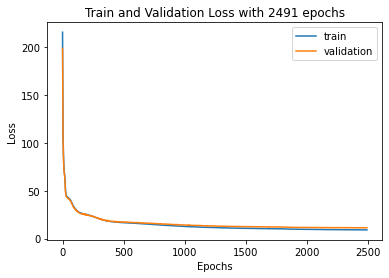

In [14]:
patience=25
# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+' epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [15]:
predict1=np.zeros((82)) #82
predict1=predictions[-3]
    
predict2=np.zeros((82))
predict2=predictions[-2]
    
predict3=np.zeros((82))
predict3=predictions[-1]

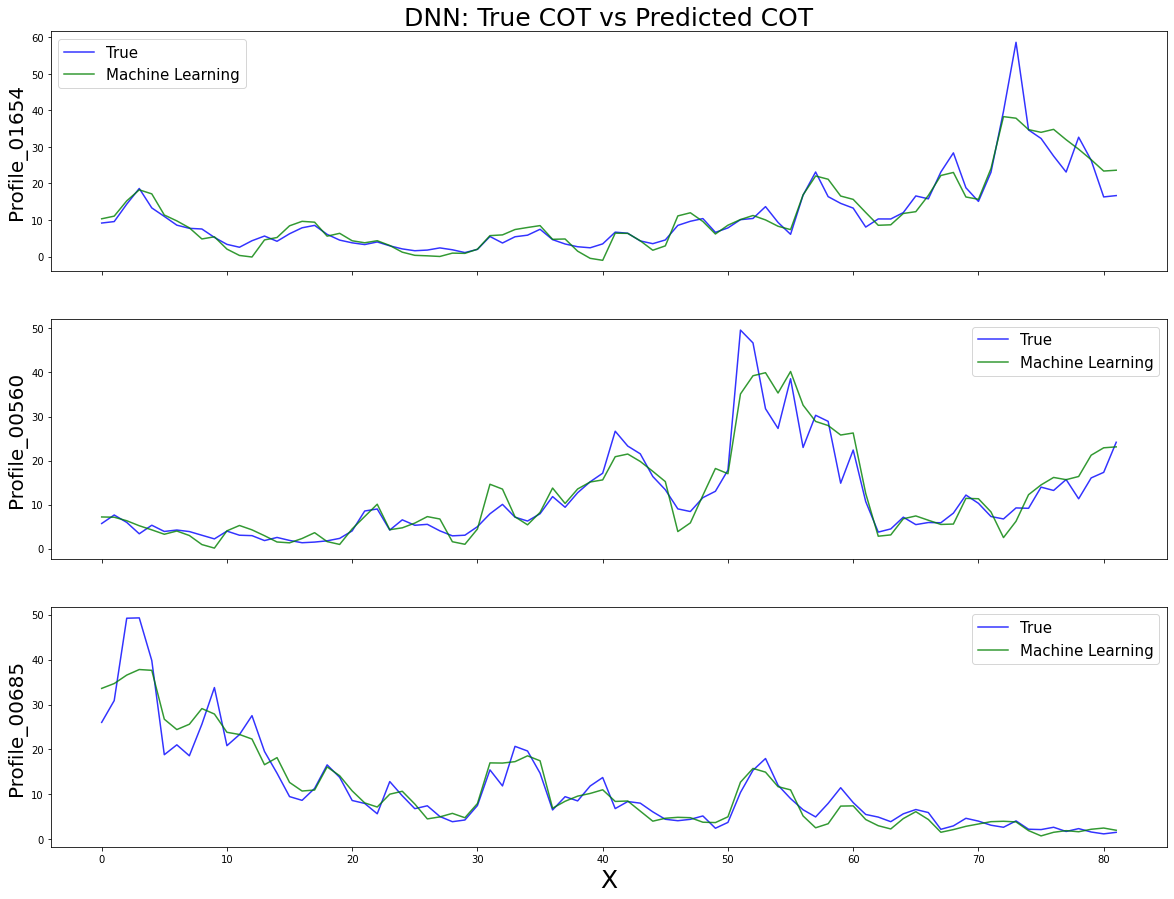

In [17]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_DNN"+"_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"DNN: True COT vs Predicted COT",fontsize=25)
ax.plot(range(82),c[num-3],alpha=0.8,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.8,color="green") 
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),c[num-2],alpha=0.8,color="blue")
ax.plot(range(82),predict2,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00560",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),c[num-1].T,alpha=0.8,color="blue")
ax.plot(range(82),predict3,alpha=0.8,color="green")
ax.legend(["True", "Machine Learning"],fontsize=15)
ax.set_ylabel(r"Profile_00685",fontsize=20)  
ax.set_xlabel('X',fontsize=25)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [18]:
std=[]
mean=[]

for k in range(82):
    tmp=[]
    for j in range(test_size):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))

    std.append(np.std(tmp))
    mean.append(np.mean(tmp))
std=np.array(std)
mean=np.array(mean)
std1 = np.std(mean)

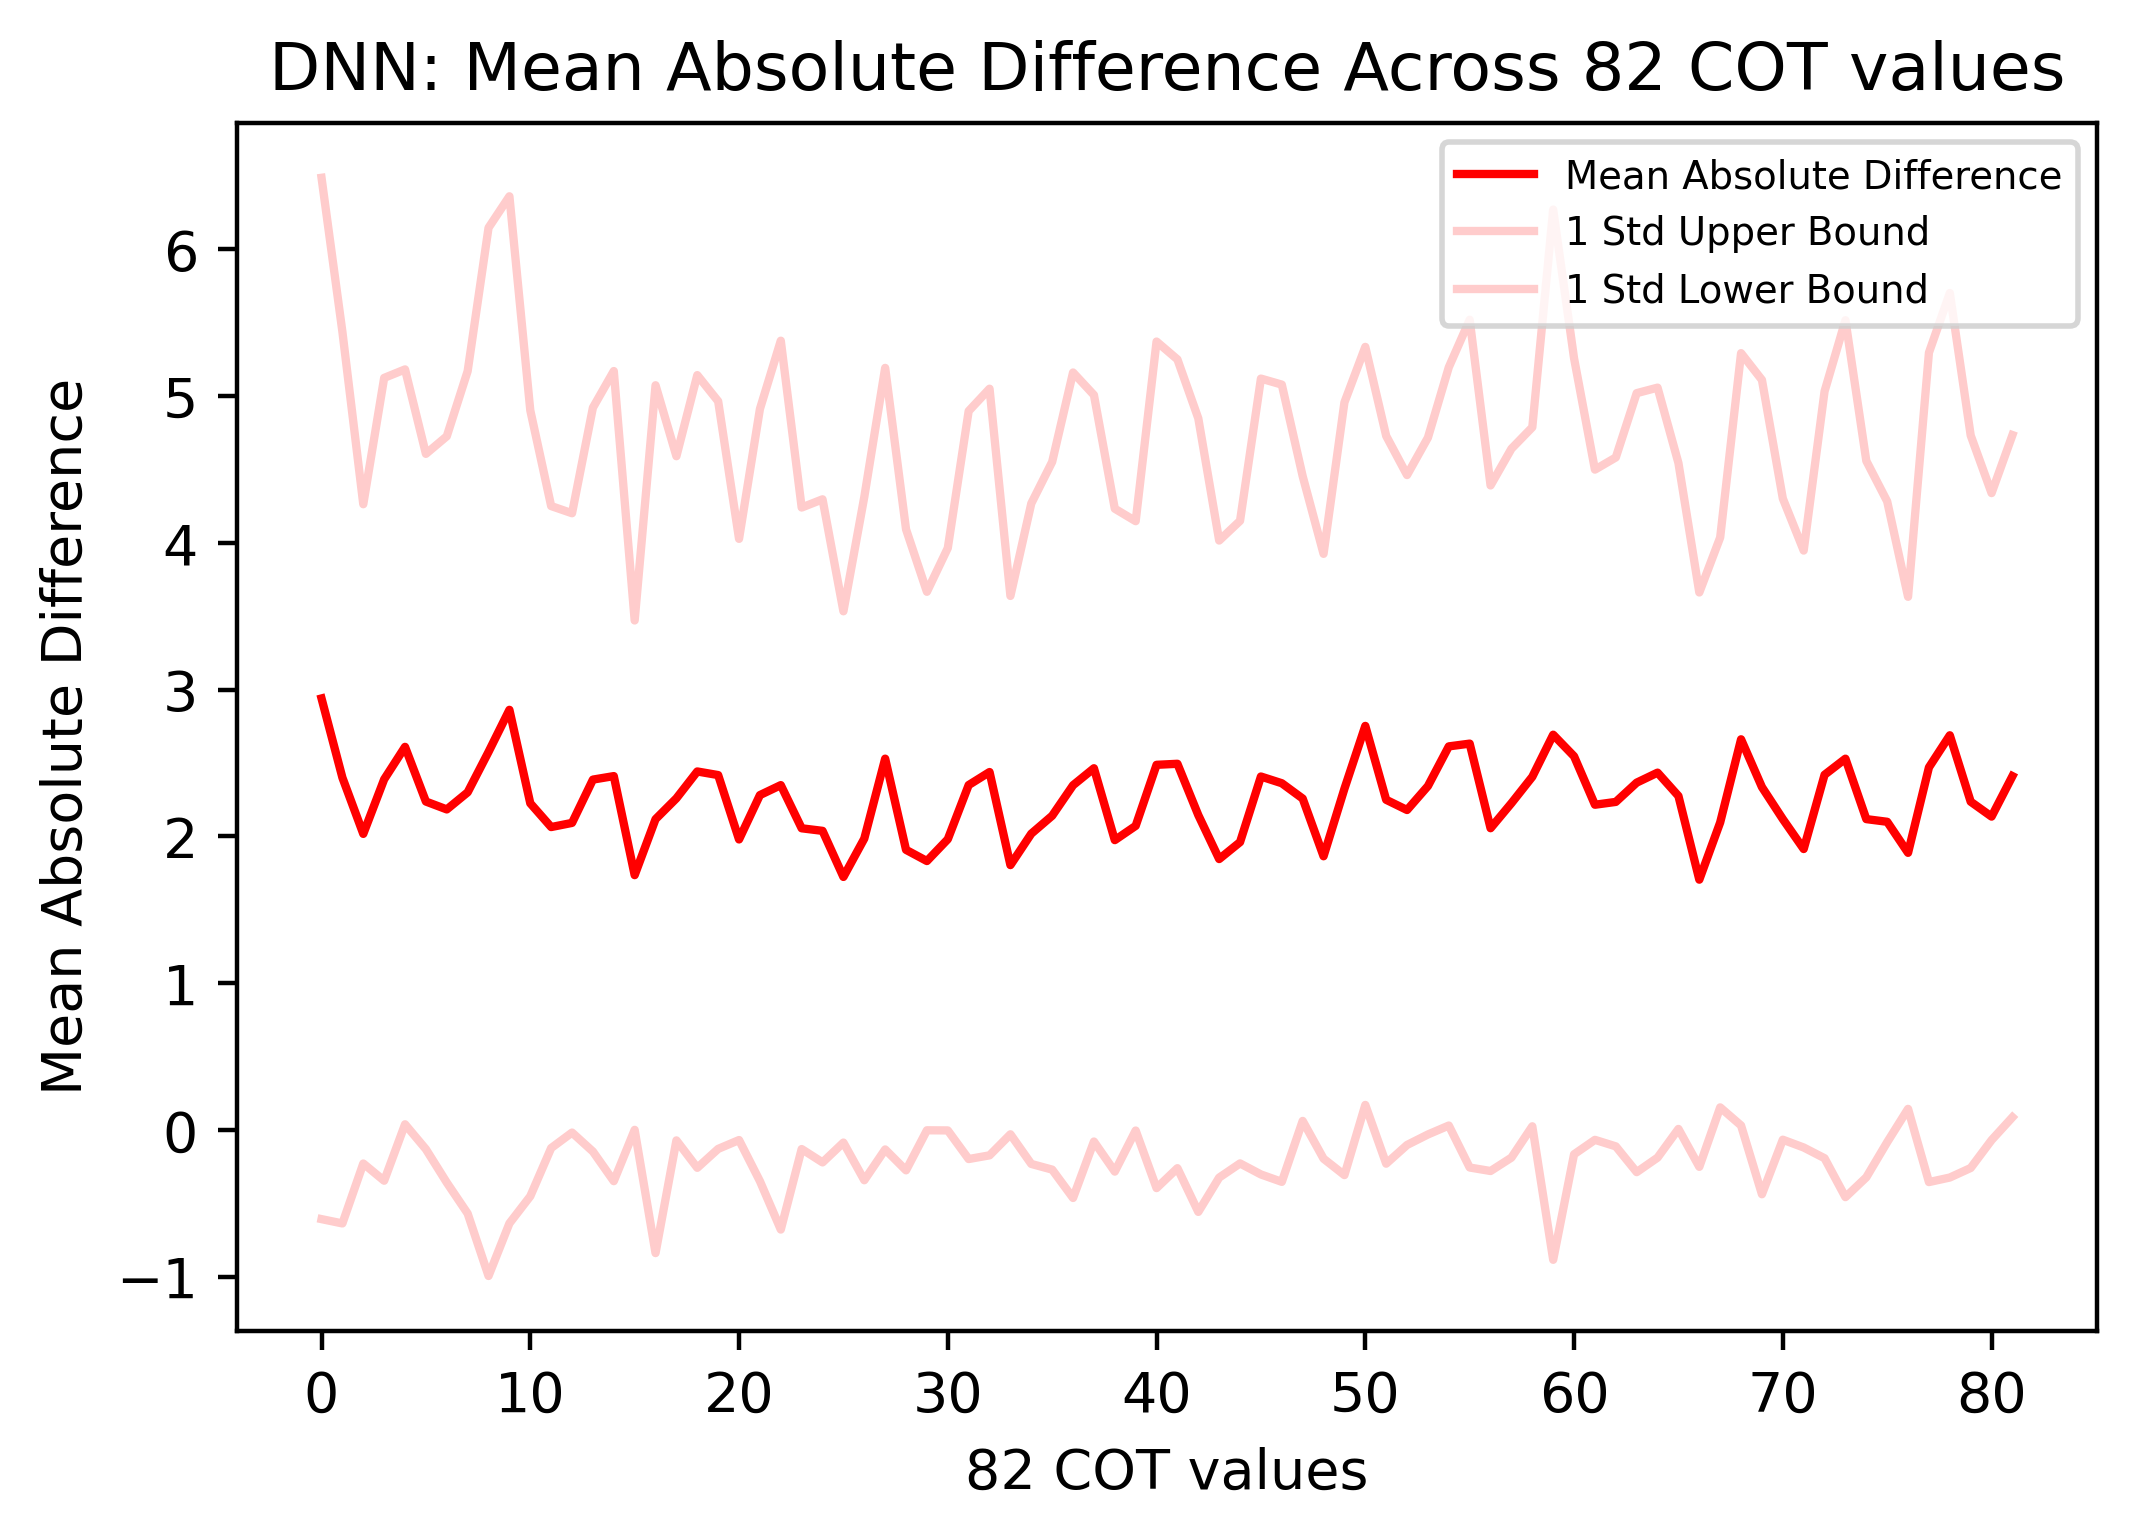

In [19]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("DNN: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/DNN_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

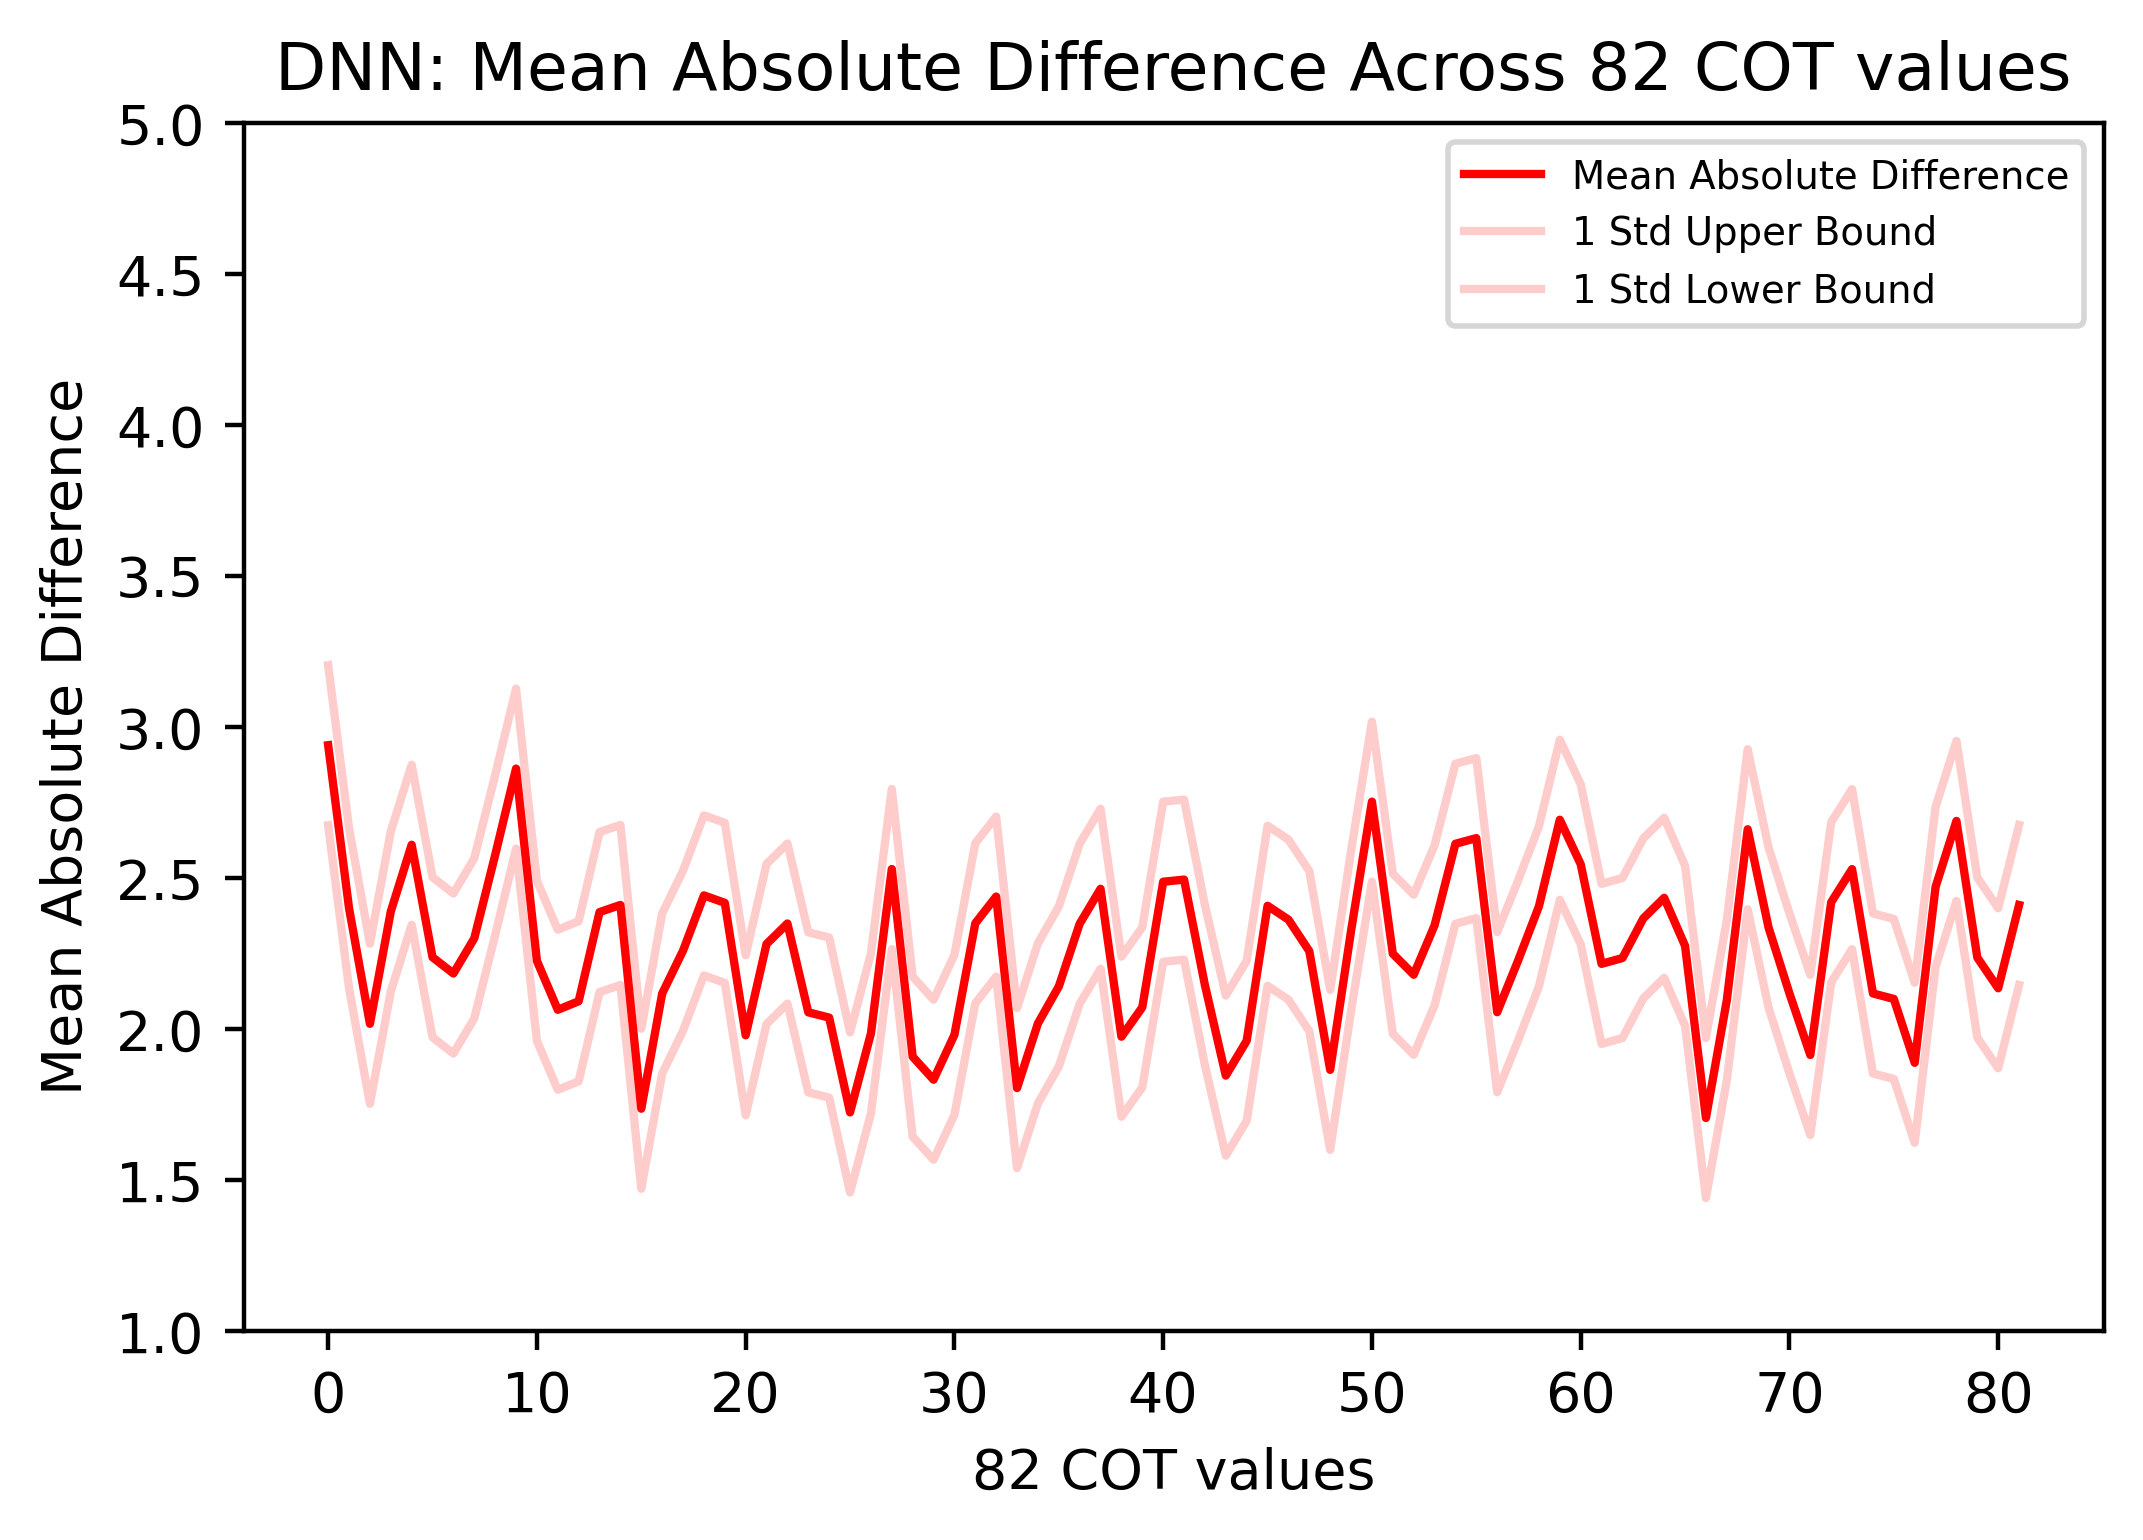

In [23]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std1, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std1, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylim((1,5))
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("DNN: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/DNN2_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)